## 1. Tree-Based Methods

Import packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import floor
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score,roc_auc_score
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC

### (a) Download the APS Failure data

I have downloaded the Failure datasets, one for training and one for testing.

### (b) Data Preparation

#### (i) Research what types of techniques are usually used

Mean/Median/Mode Imputation: Replace missing values with the mean (for continuous data), median (when there are outliers in continuous data), or mode (for categorical data).

Constant Imputation: Replace missing values with a constant.

Linear Interpolation: Useful for time series data.

K-Nearest Neighbors (KNN) Imputation: Replace missing values using the average of k nearest neighbors.

Multiple Imputation: Use algorithms to make multiple imputations (guesses) for the missing value.

Model-Based Methods: Train a model (like regression) to predict missing values.

Iterative Imputer: Model each feature with missing values as a function of other features.

For this dataset, since all attributes are numeric and given the domain, using Mean or Median Imputation or KNN Imputation might be more appropriate. However, the best choice often depends on the nature of the data and the missingness mechanism.

#### (ii) Calculate the coefficient of variation

In [2]:
# 1. Reading the data
train_df = pd.read_csv('../Data/aps_failure_training_set.csv', skiprows=20)
test_df = pd.read_csv('../Data/aps_failure_test_set.csv', skiprows=20)

# 2. Replace 'na' values with NaN for computation
train_df.replace('na', np.nan, inplace=True)
test_df.replace('na', np.nan, inplace=True)

# 3. Convert columns to appropriate numeric types (if they are not already)
train_df.iloc[:, 1:] = train_df.iloc[:, 1:].astype(float)
test_df.iloc[:, 1:] = test_df.iloc[:, 1:].astype(float)

# 4. Calculate the mean for numeric columns
mean_train = train_df.iloc[:, 1:].mean()
mean_test = test_df.iloc[:, 1:].mean()

# 5. Fill NA values with the calculated means
train_df.fillna(mean_train, inplace=True)
test_df.fillna(mean_test, inplace=True)

# 6. Calculate CV for each feature in train_df excluding the 'class' column
cv_values = (train_df.iloc[:, 1:].std() / train_df.iloc[:, 1:].mean()).sort_values(ascending=False)

print(cv_values)

cs_009    235.277605
cf_000    184.233092
co_000    183.949017
ad_000    183.847620
dh_000    114.984991
             ...    
bo_000      0.462564
bp_000      0.425967
bq_000      0.399192
br_000      0.382669
cd_000      0.000000
Length: 170, dtype: float64


#### (iii) Plot a correlation matrix

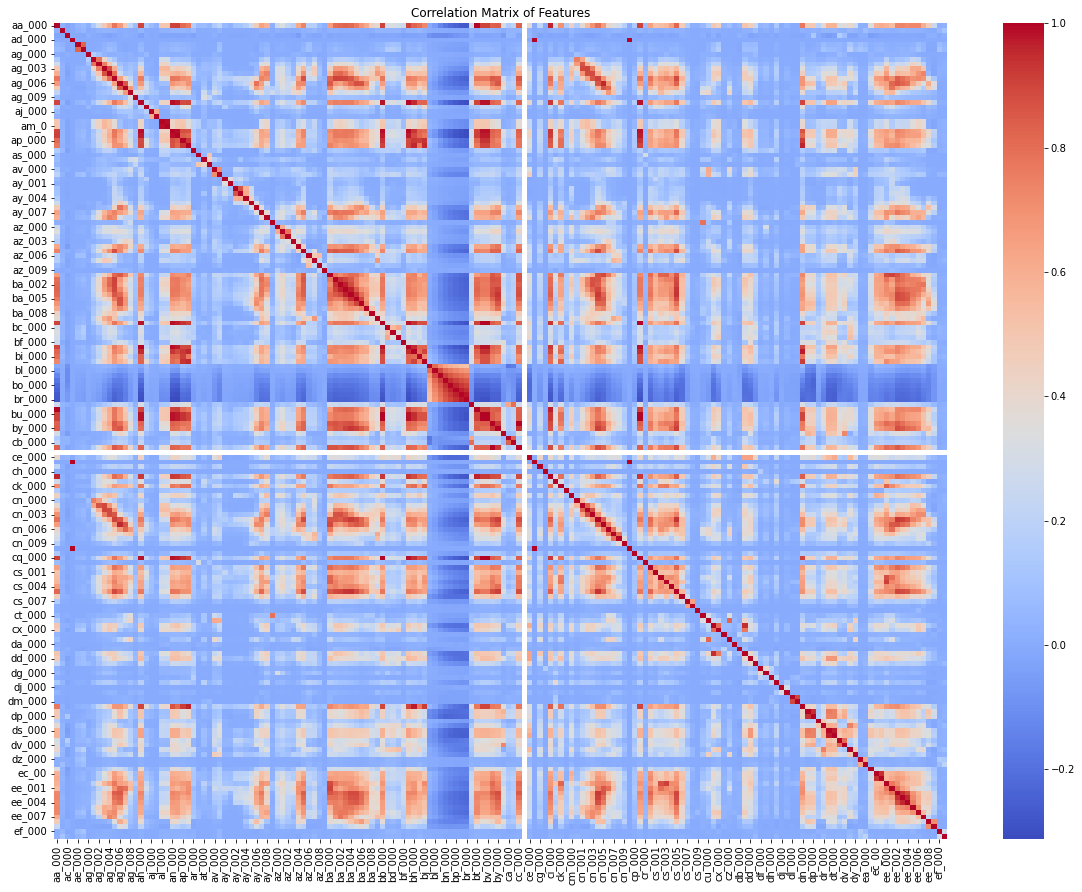

In [3]:
correlation_matrix = train_df.iloc[:, 1:].corr()

# Plotting the correlation matrix using a heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=False, fmt=".1f")
plt.title('Correlation Matrix of Features')
plt.show()

#### (iv) Make scatter plots and box plots

There's are outliers so the scatter plots doesn't fit too well, since the points haven't been standardized.

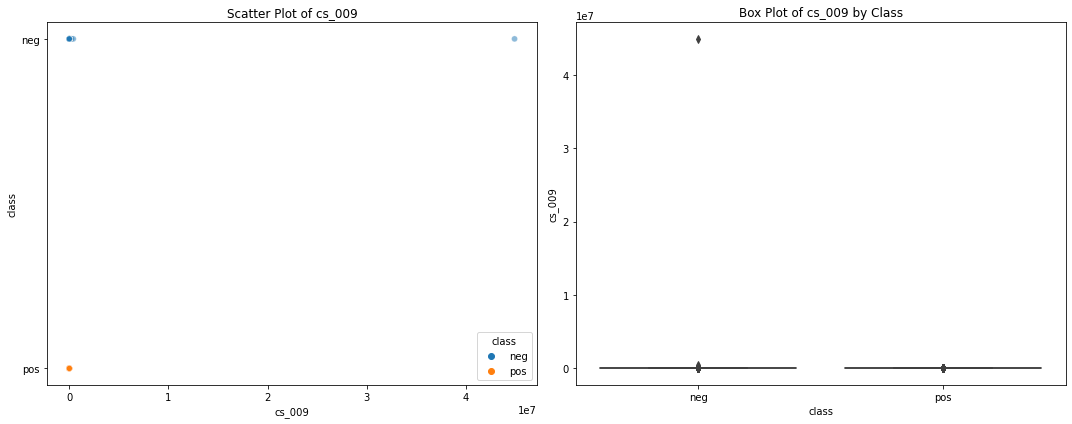

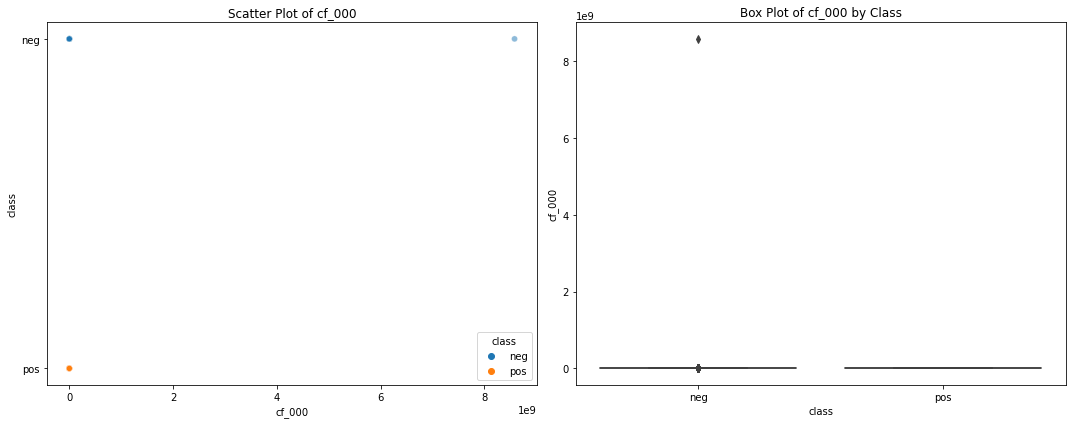

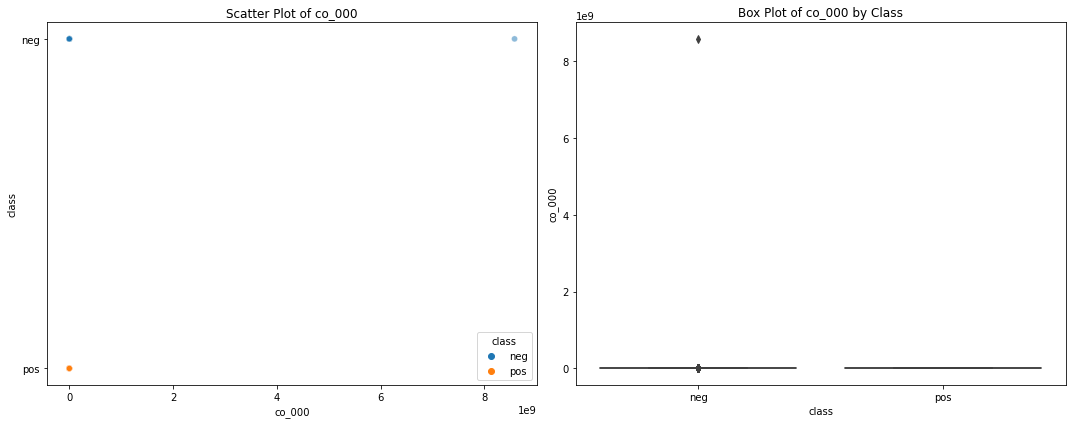

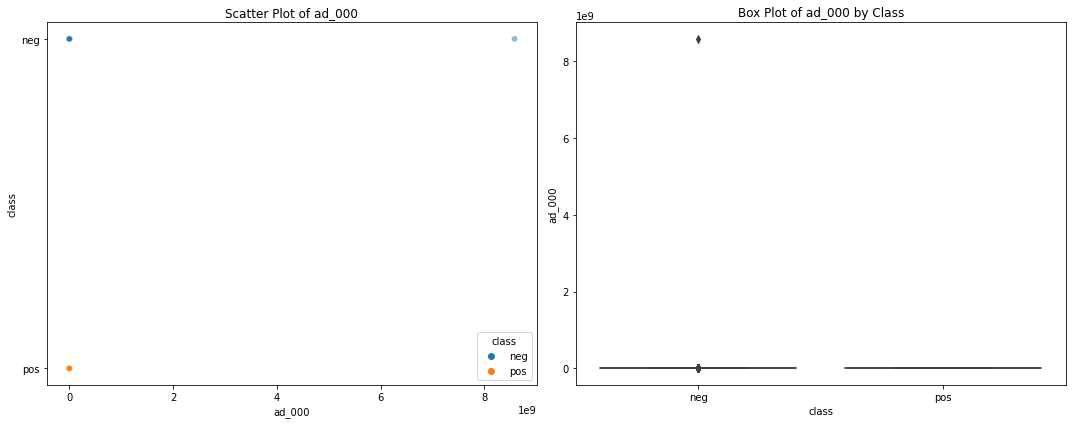

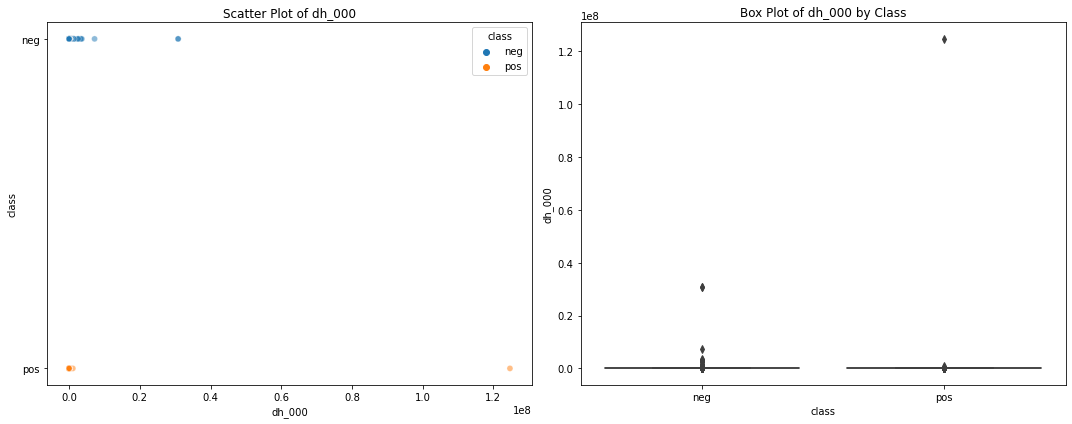

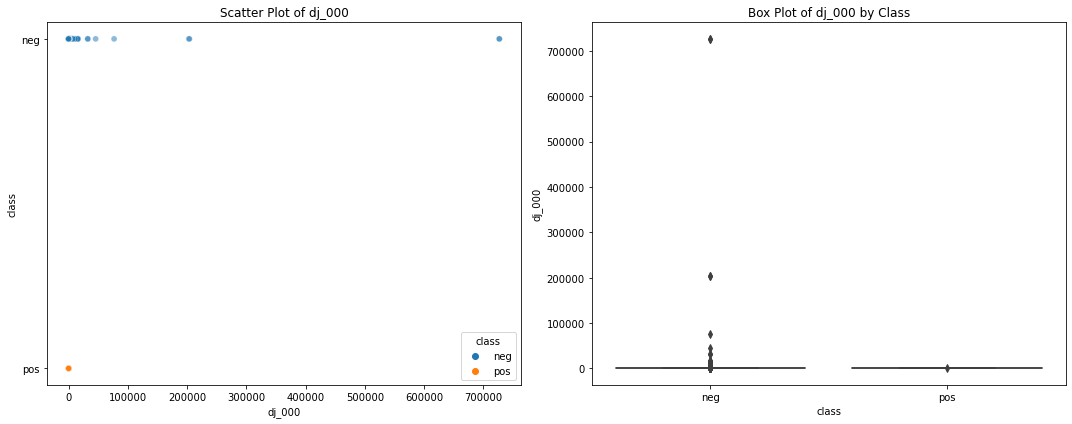

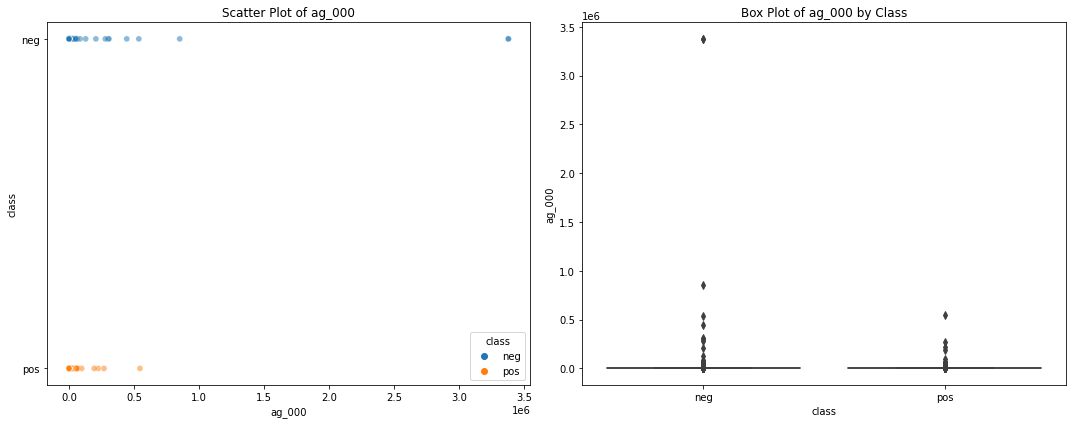

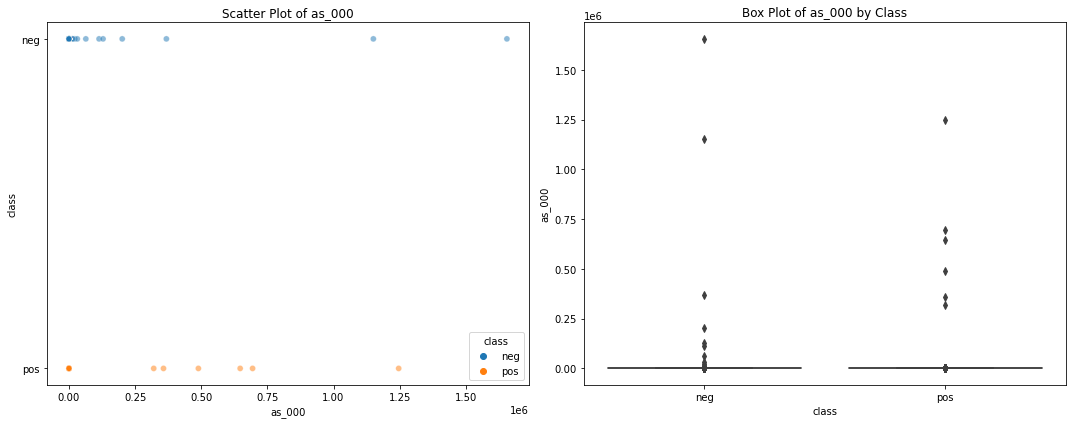

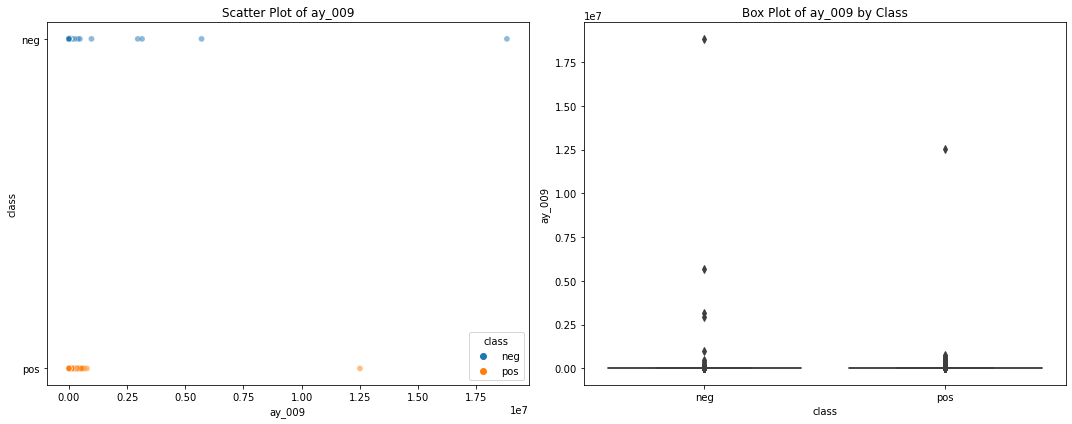

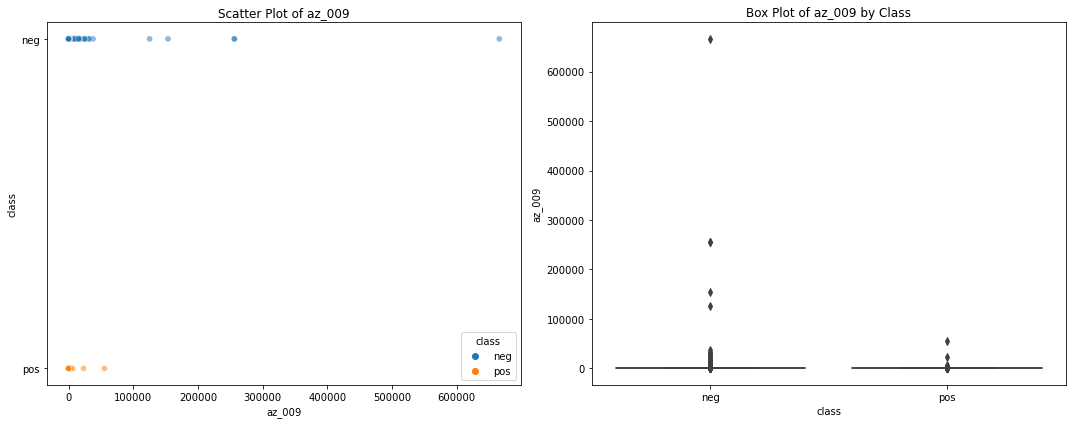

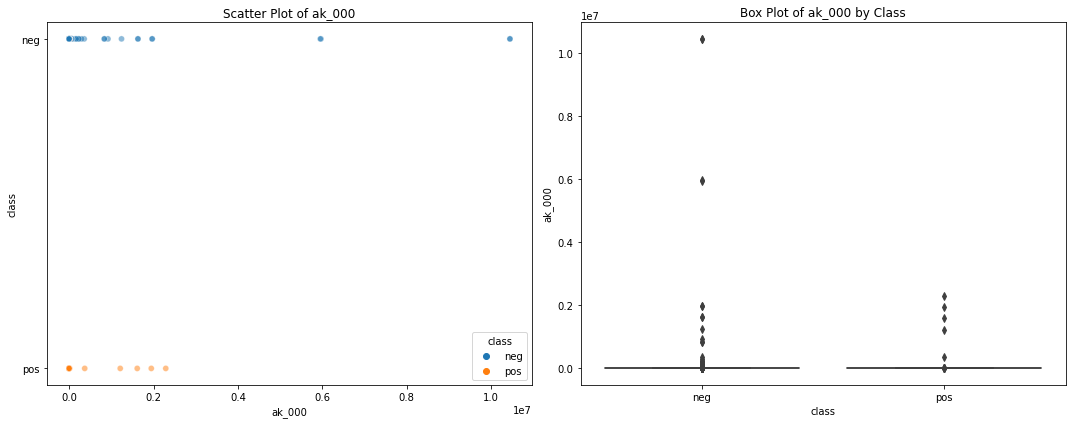

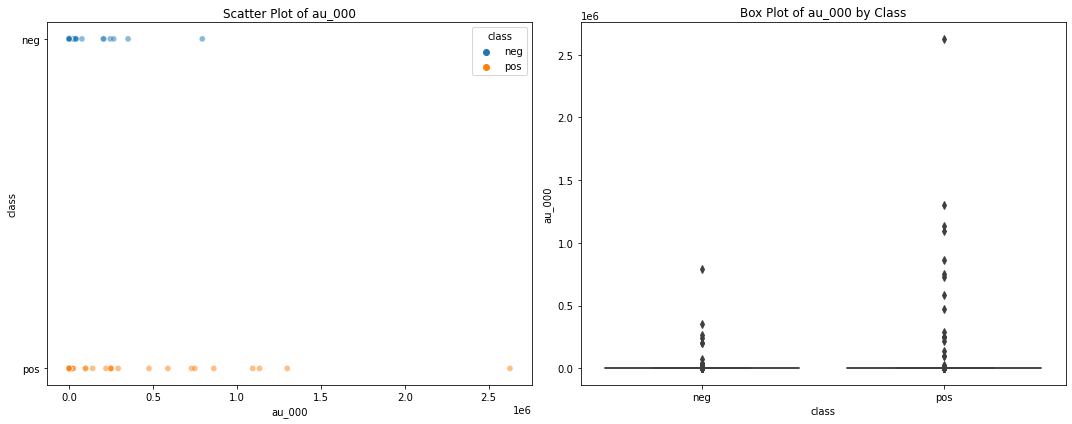

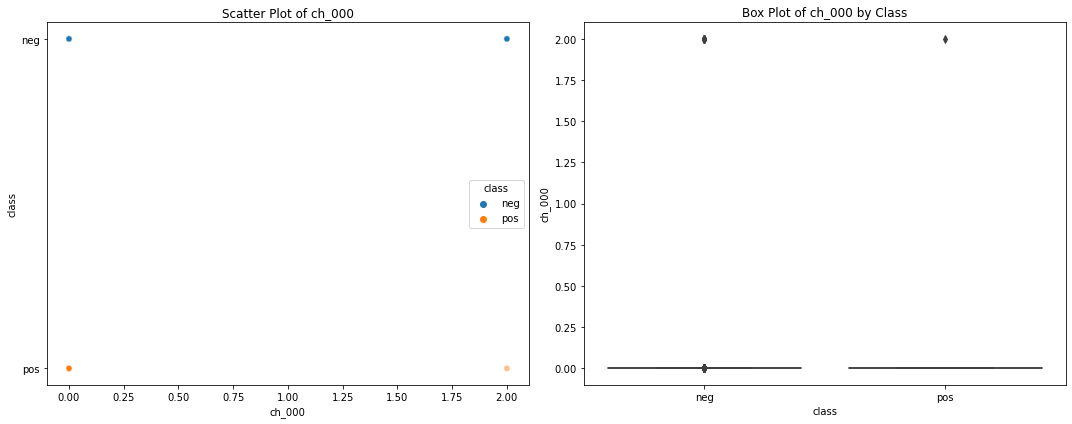

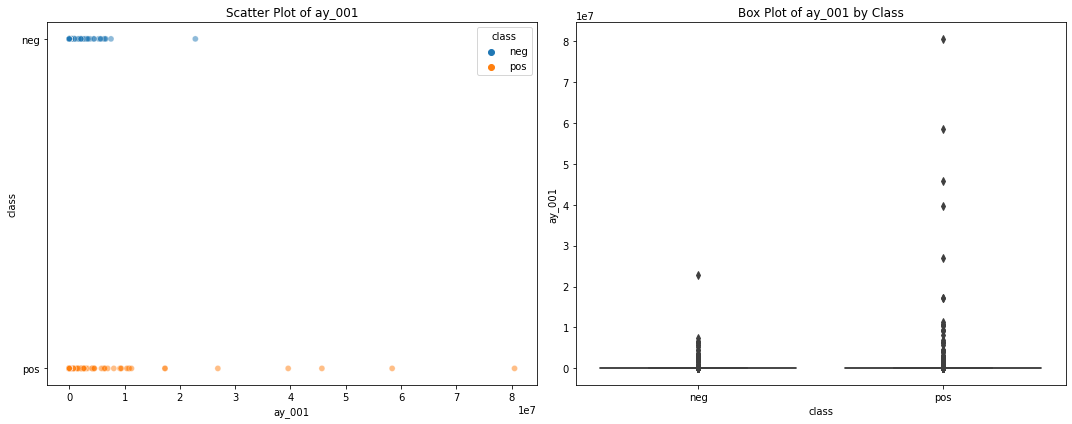

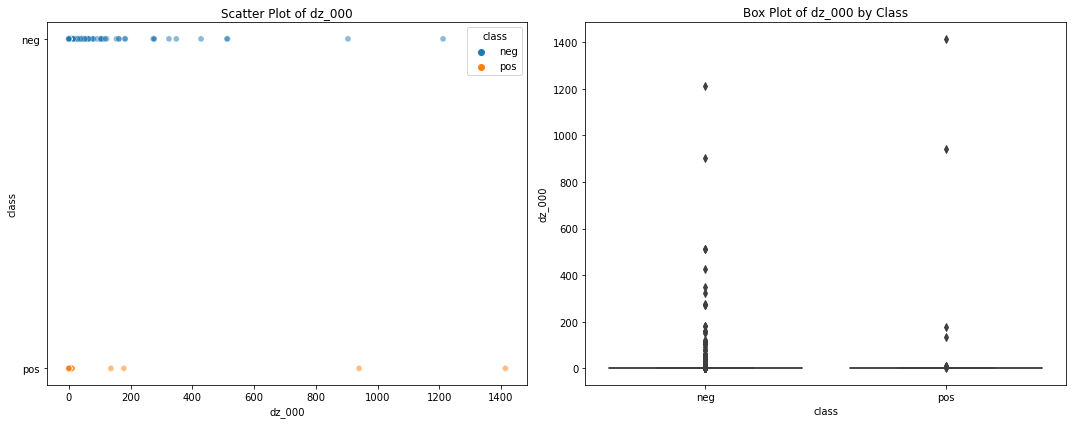

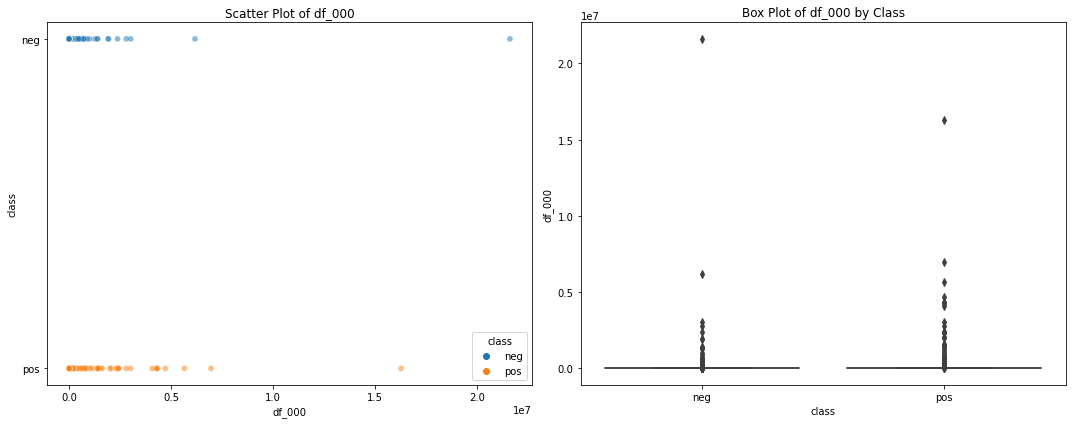

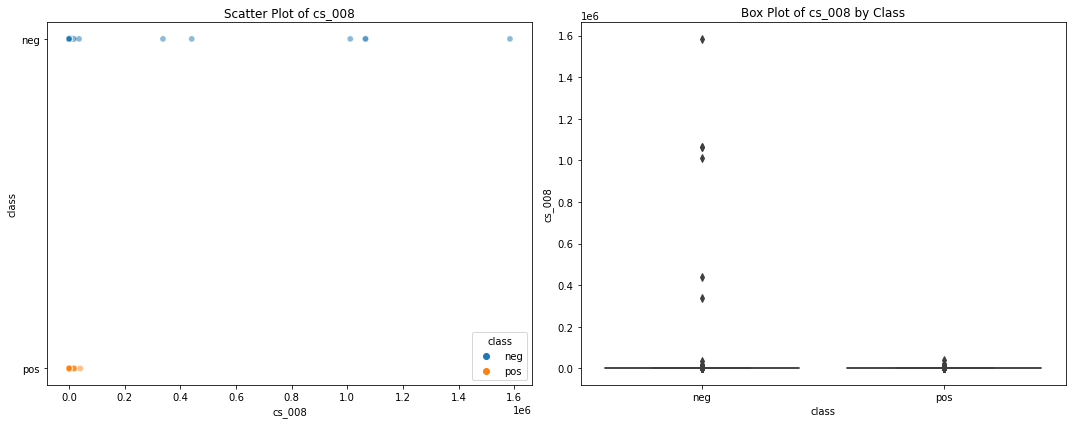

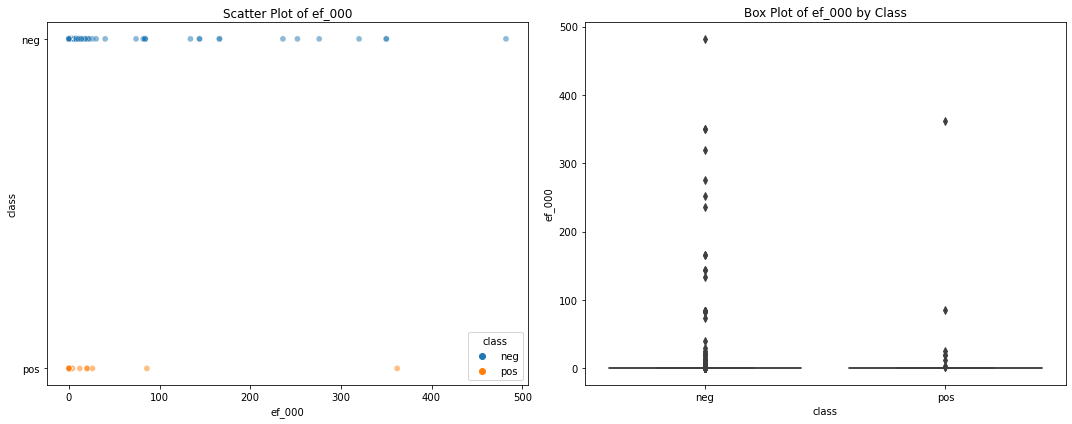

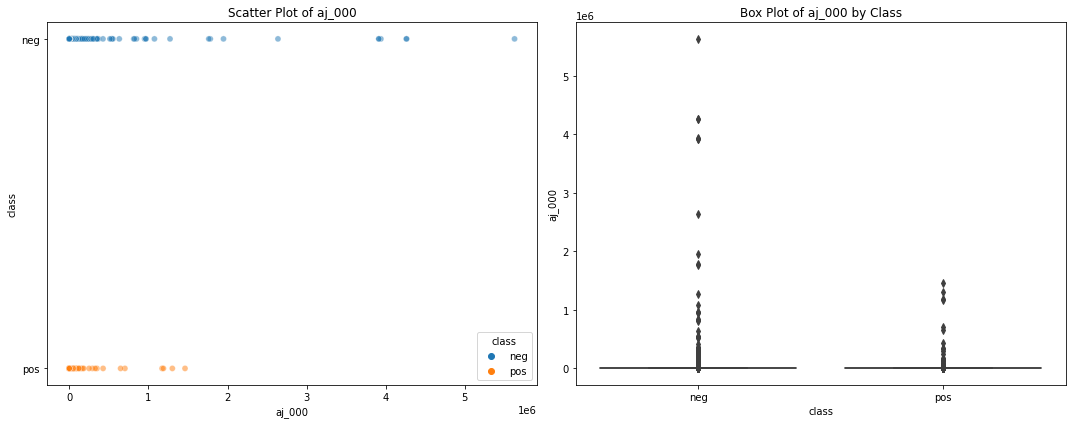

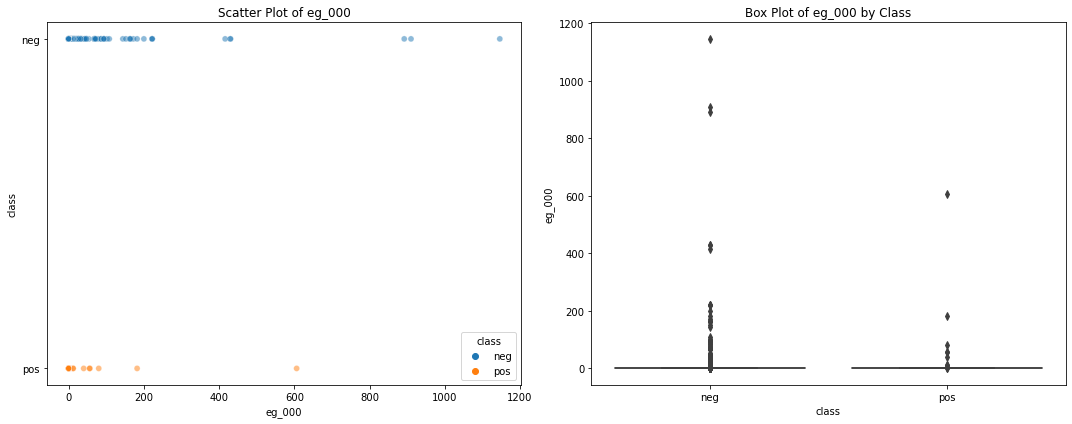

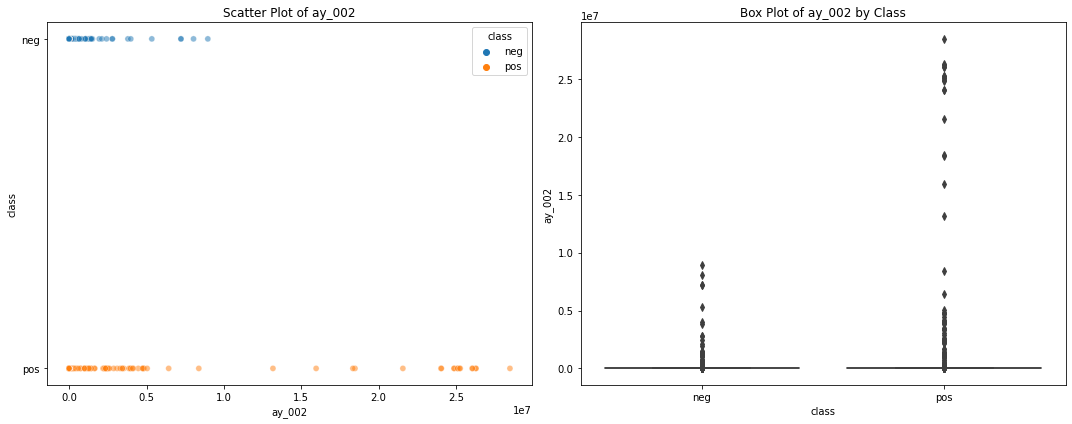

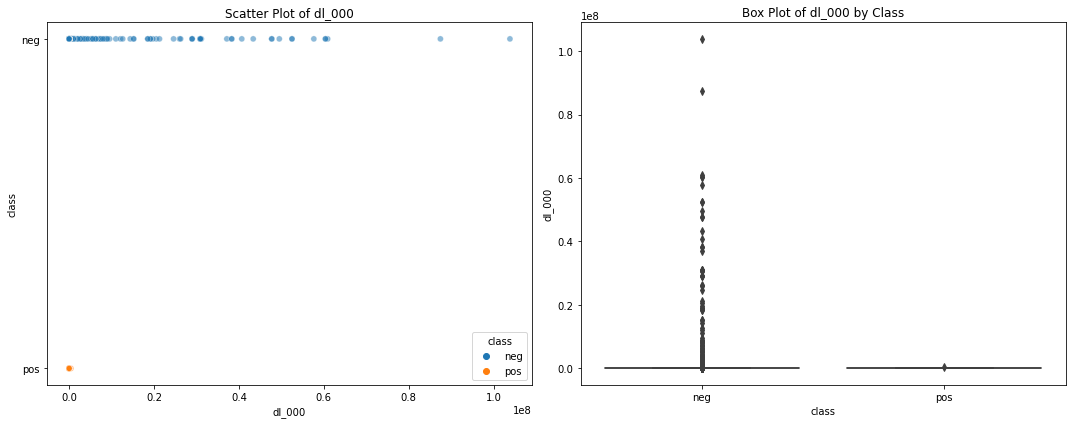

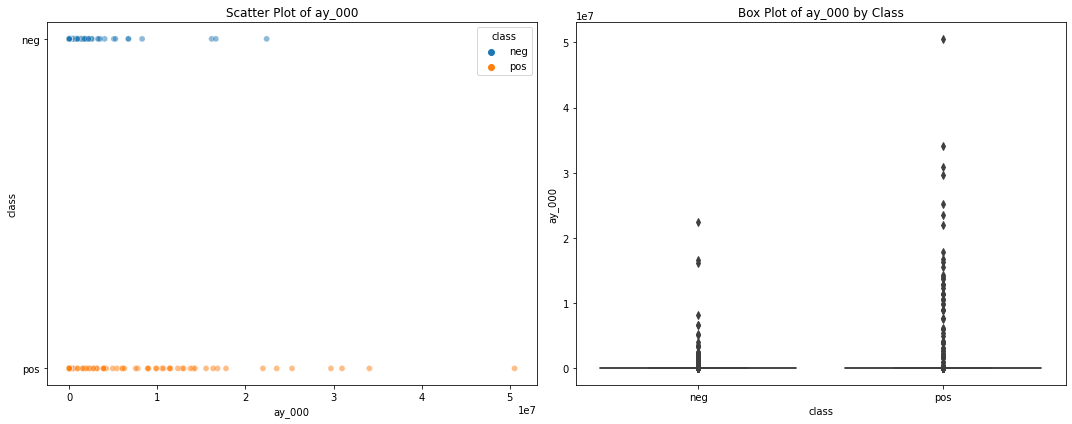

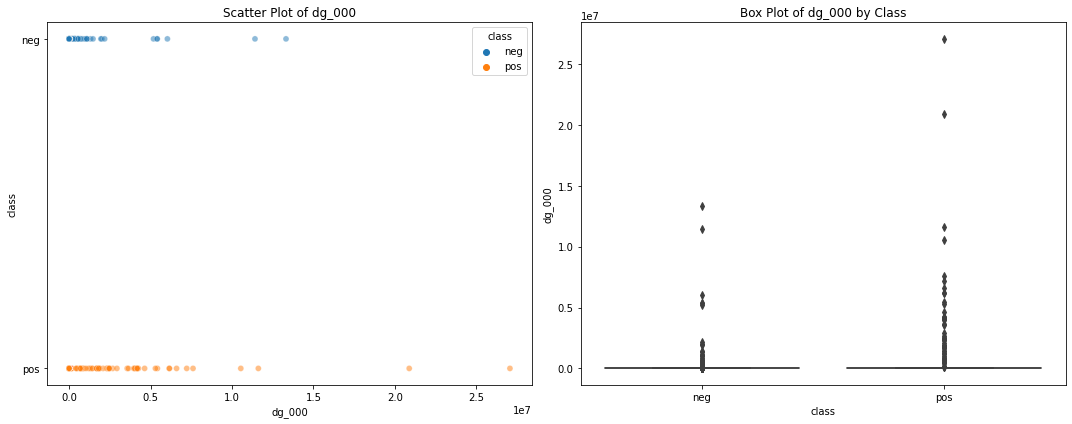

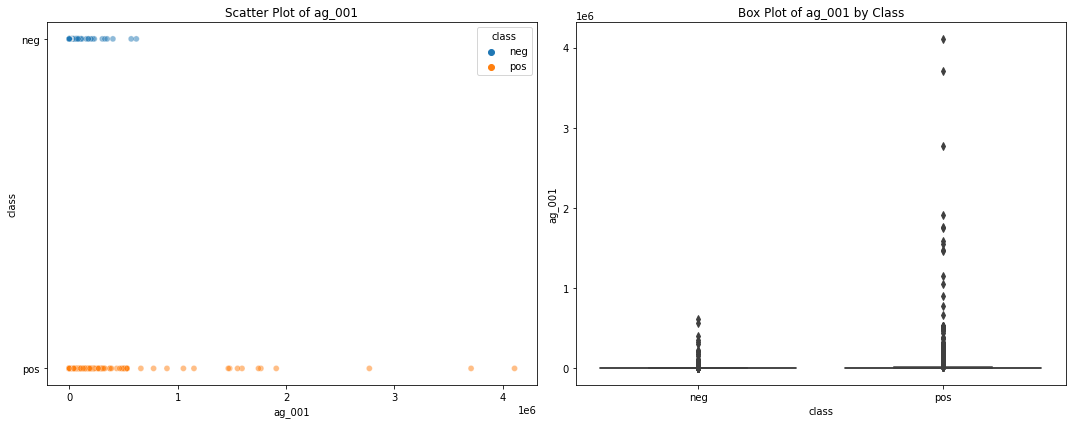

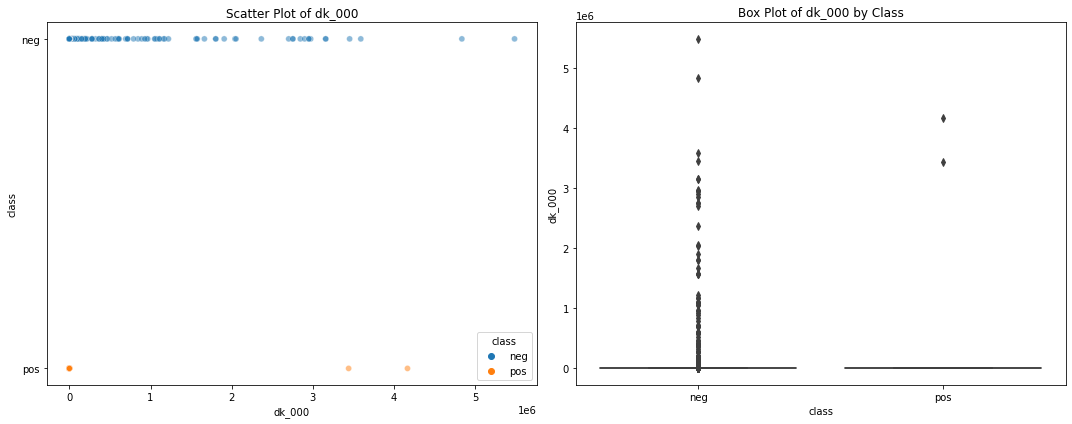

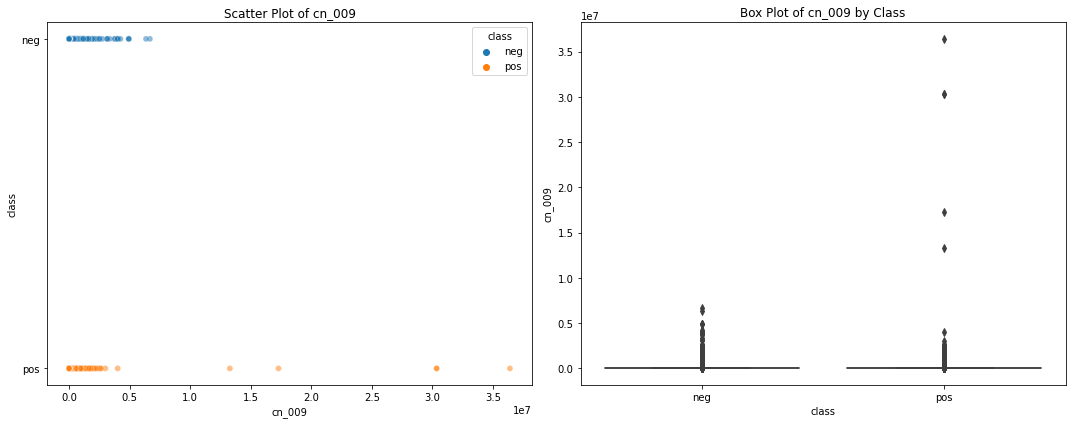

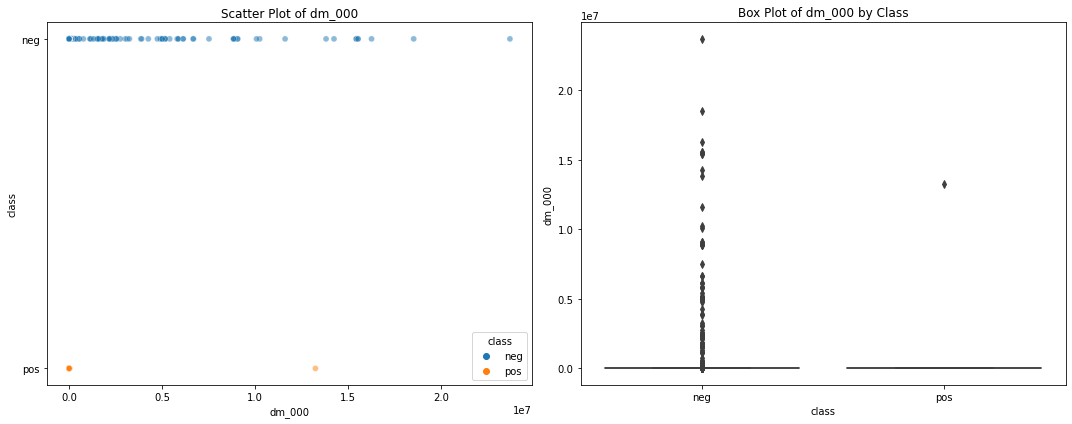

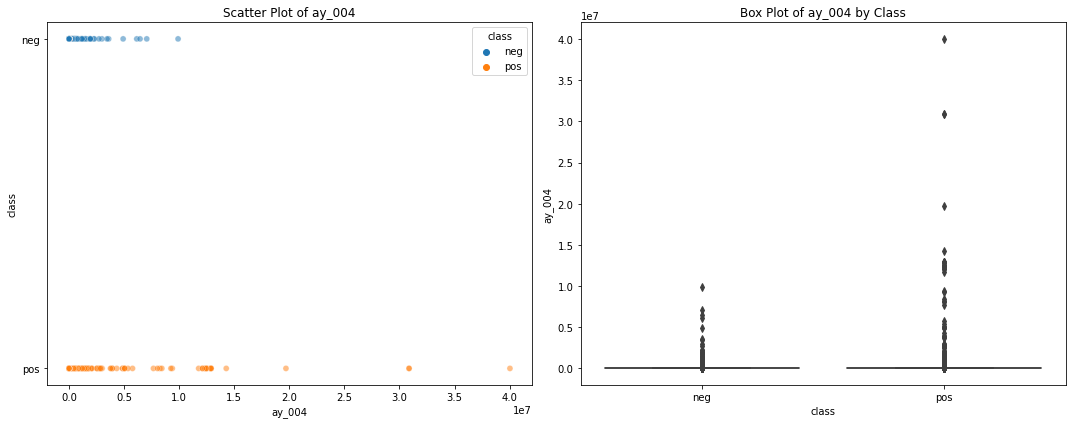

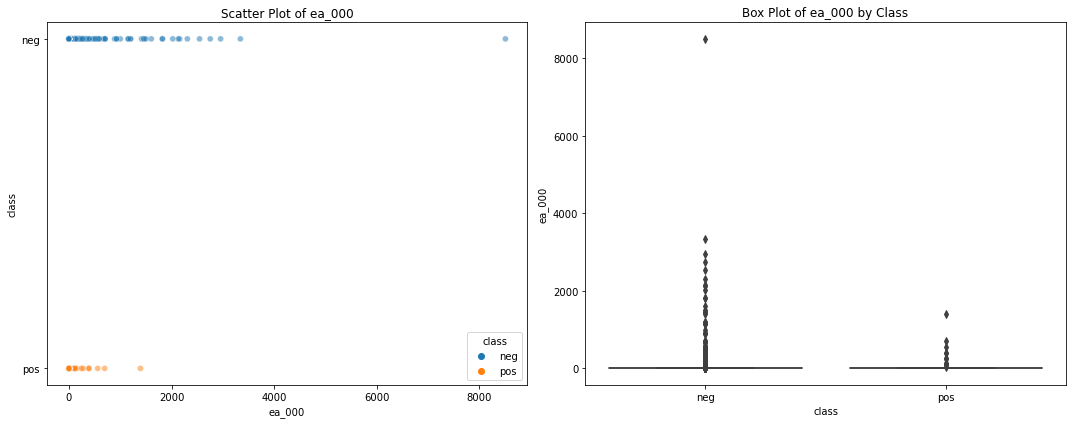

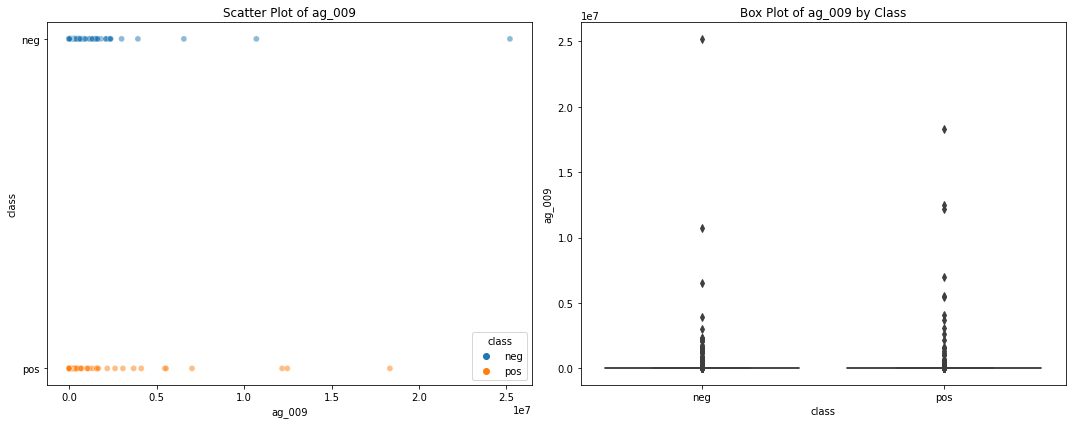

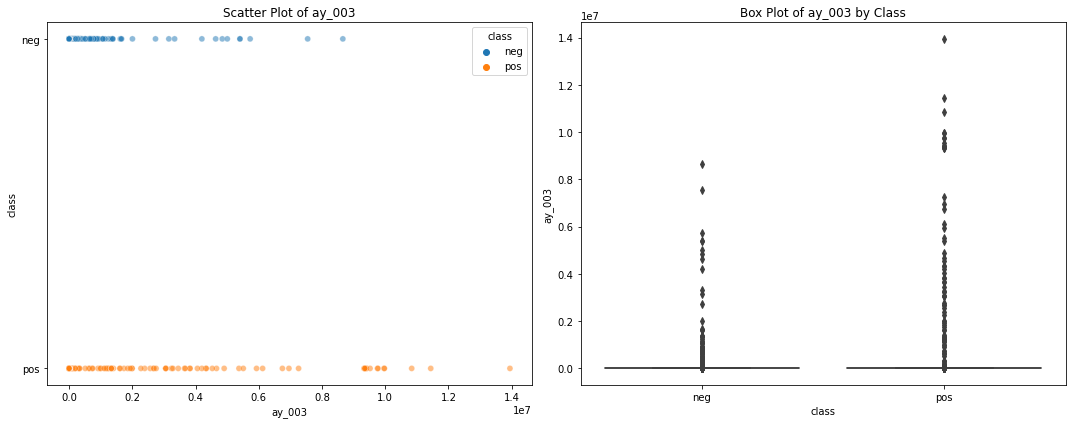

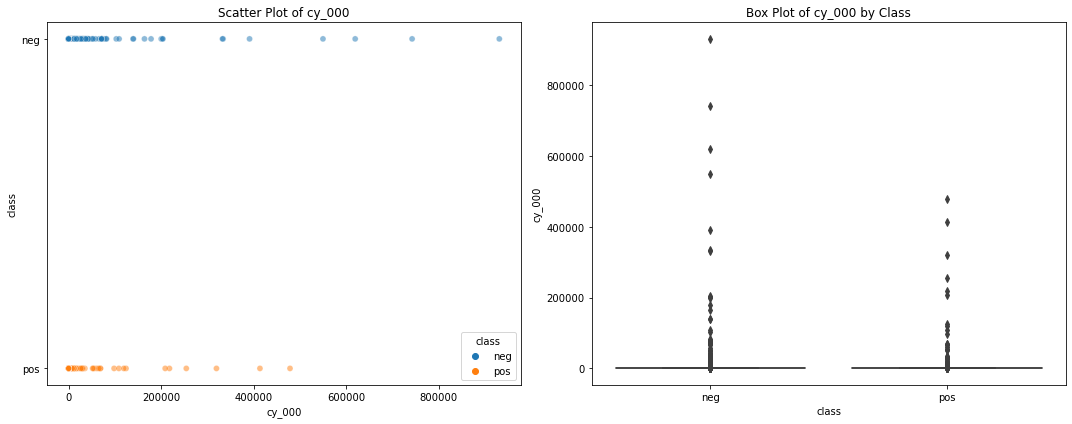

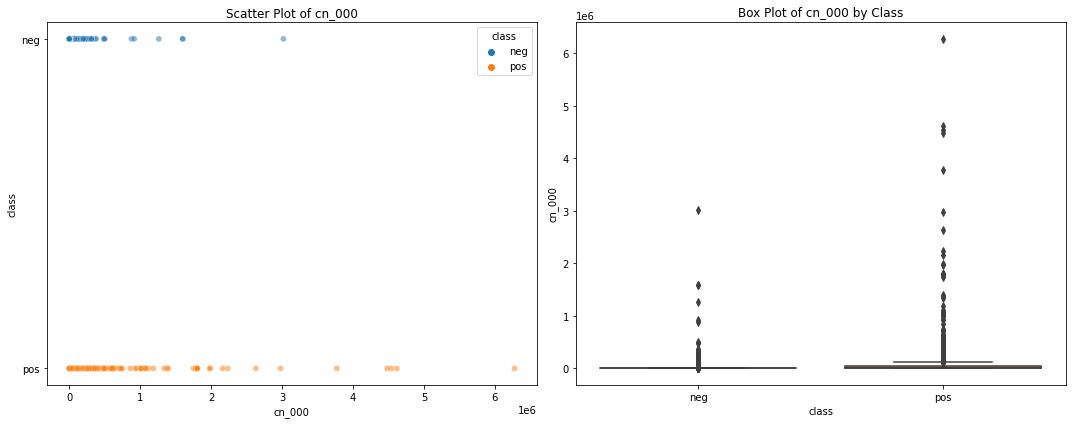

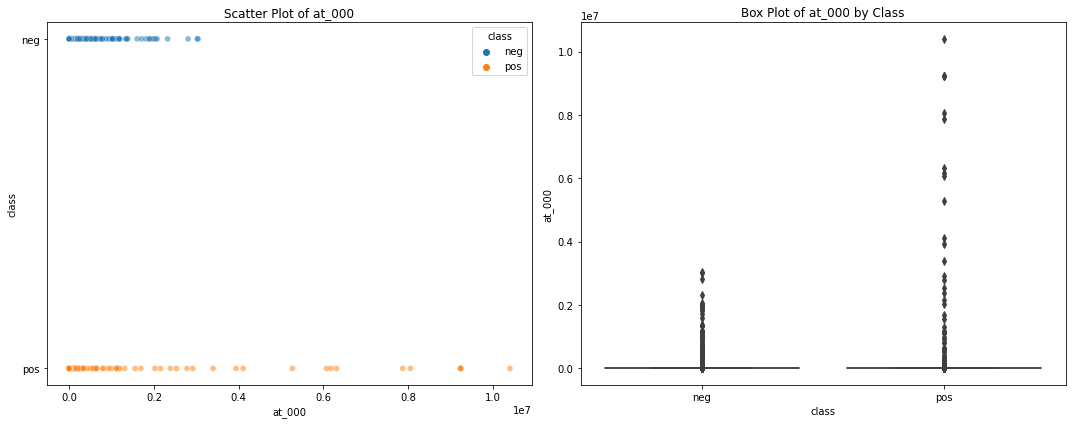

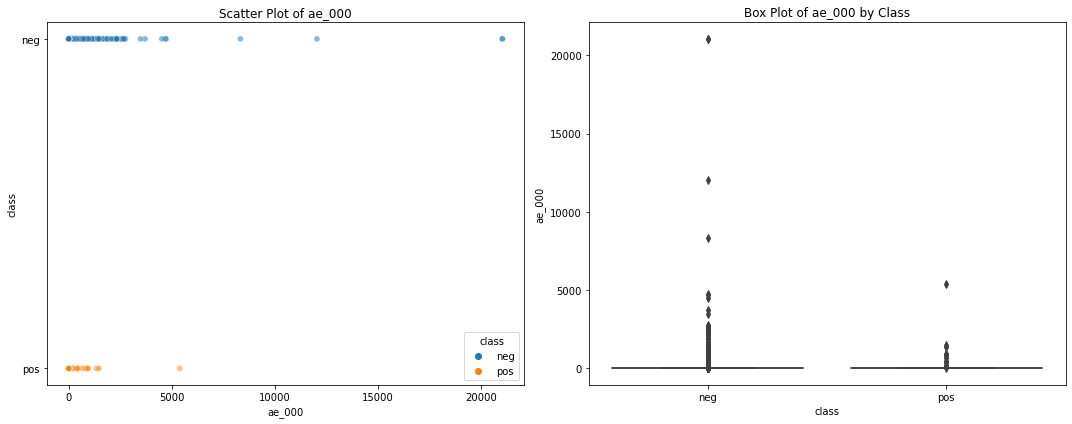

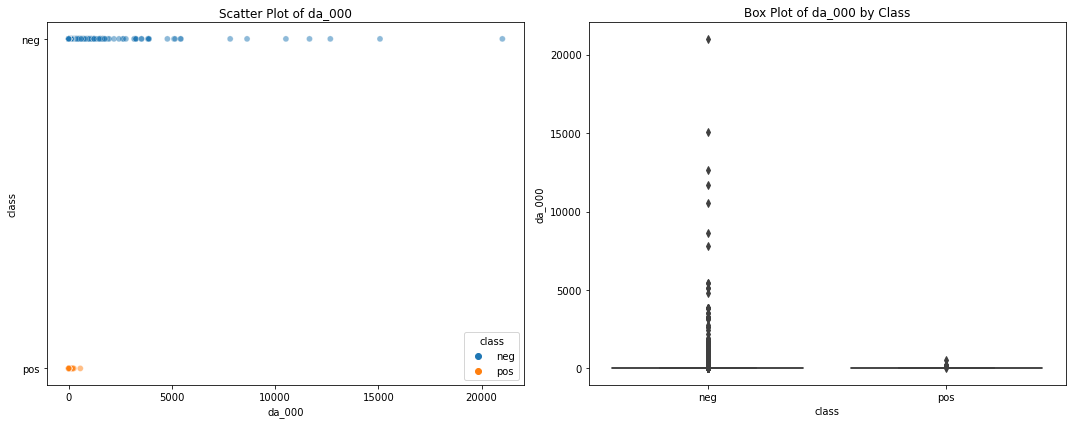

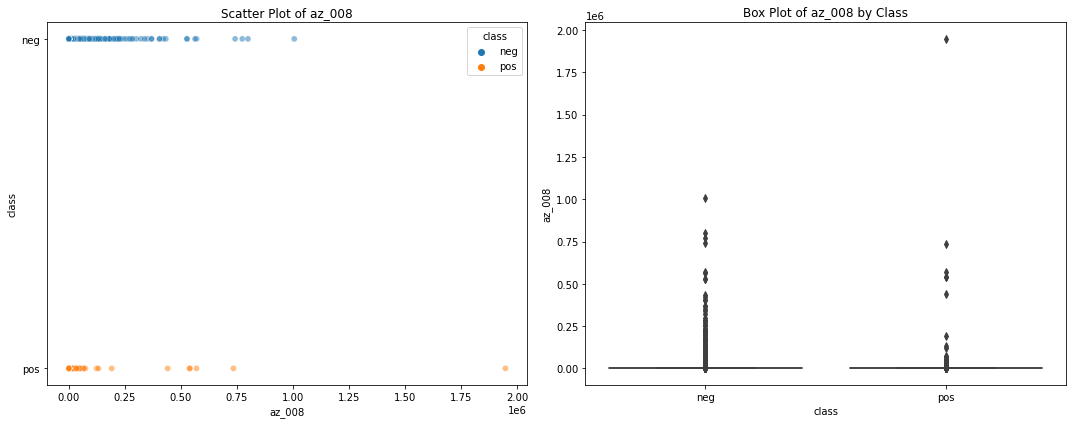

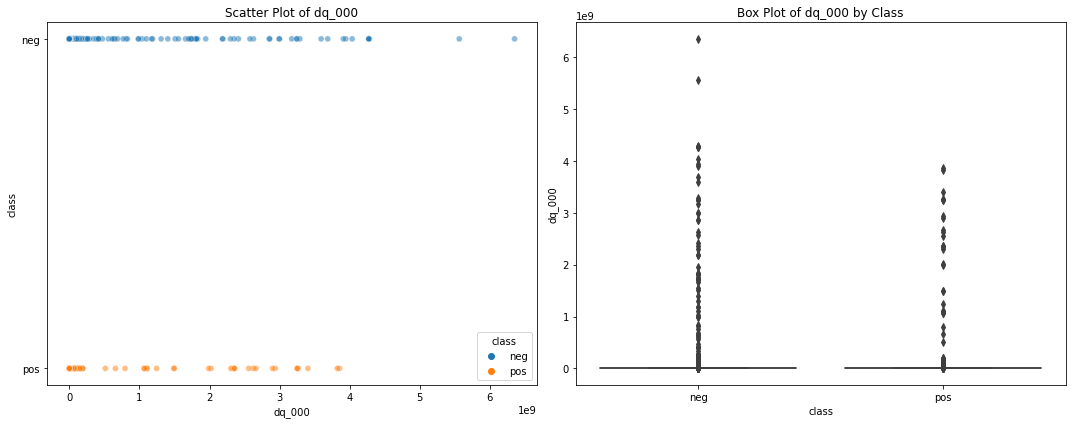

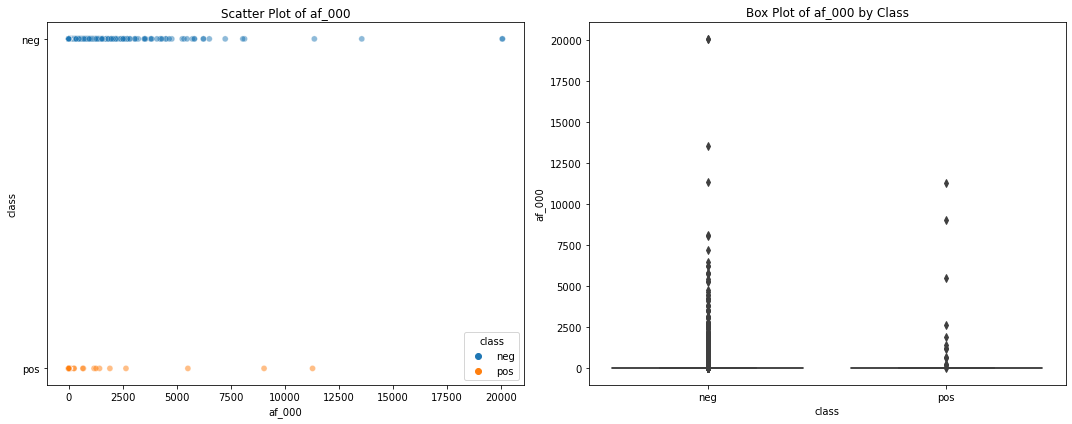

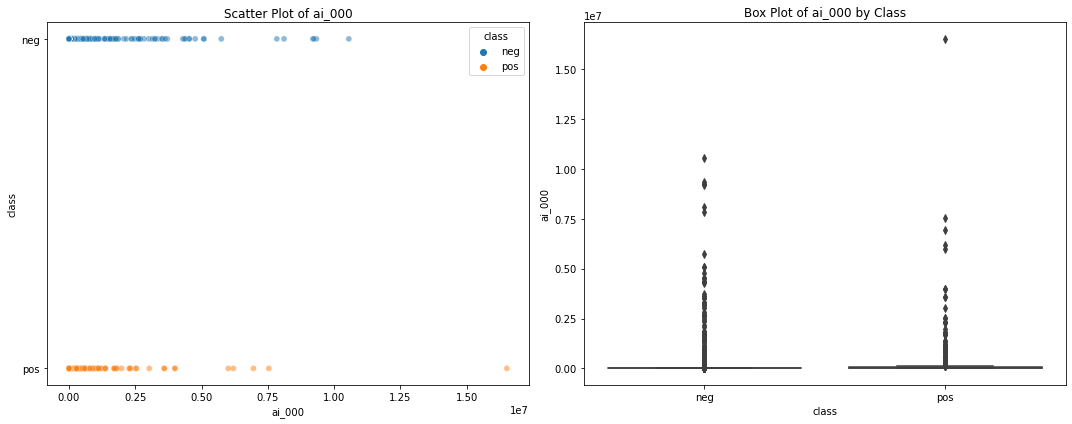

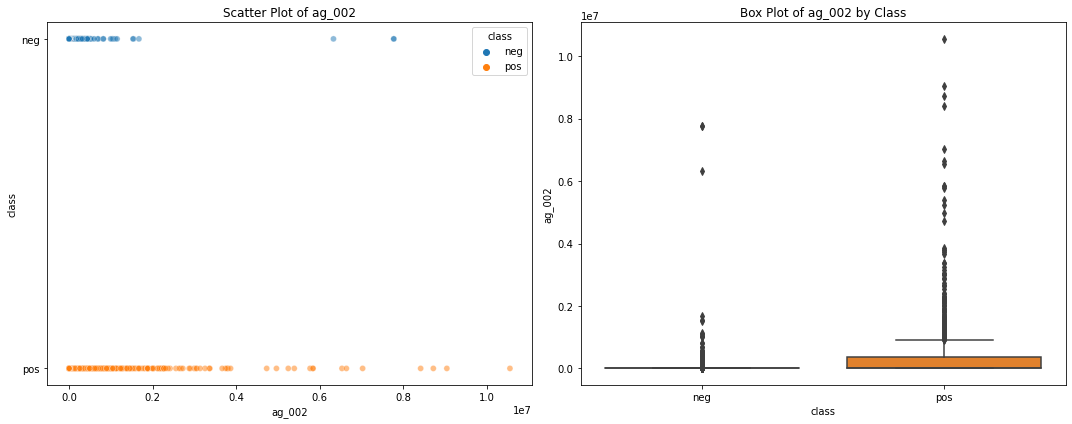

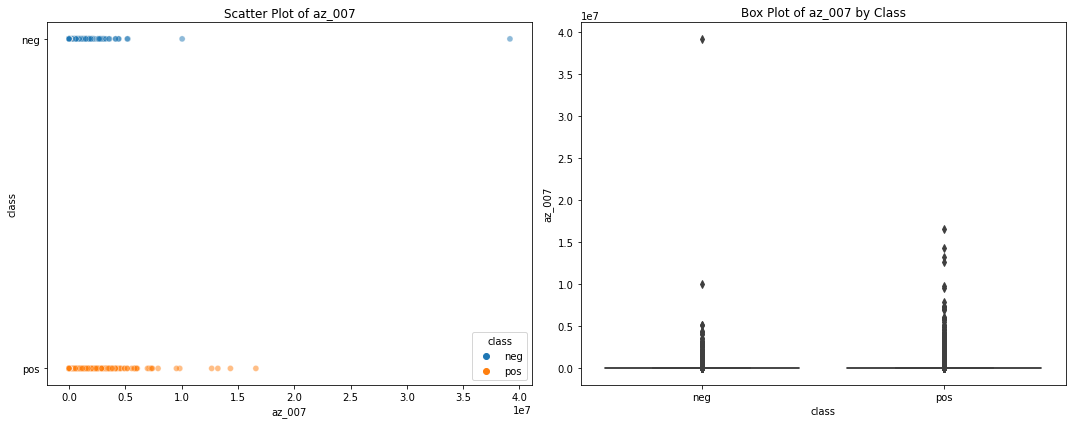

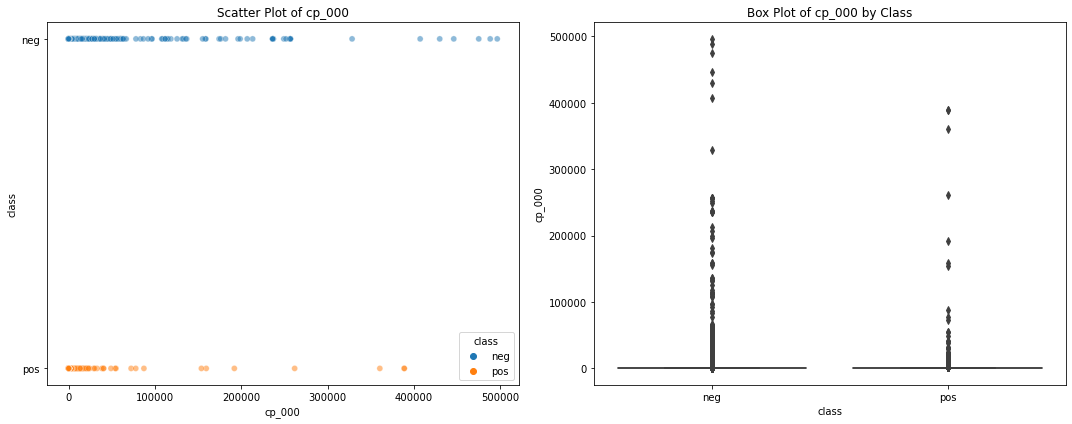

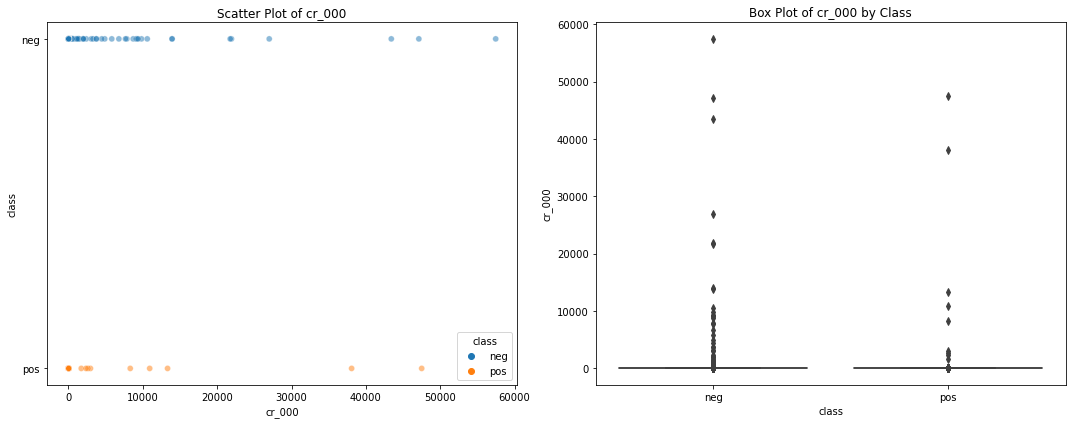

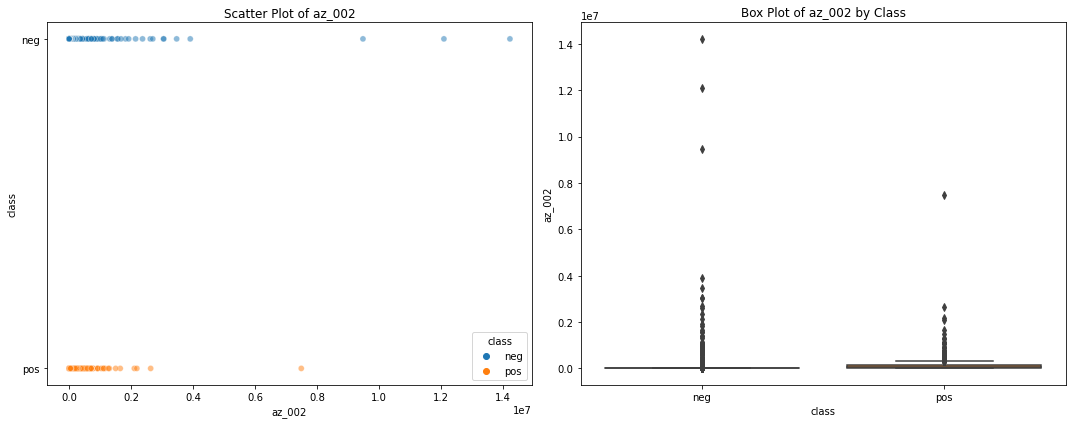

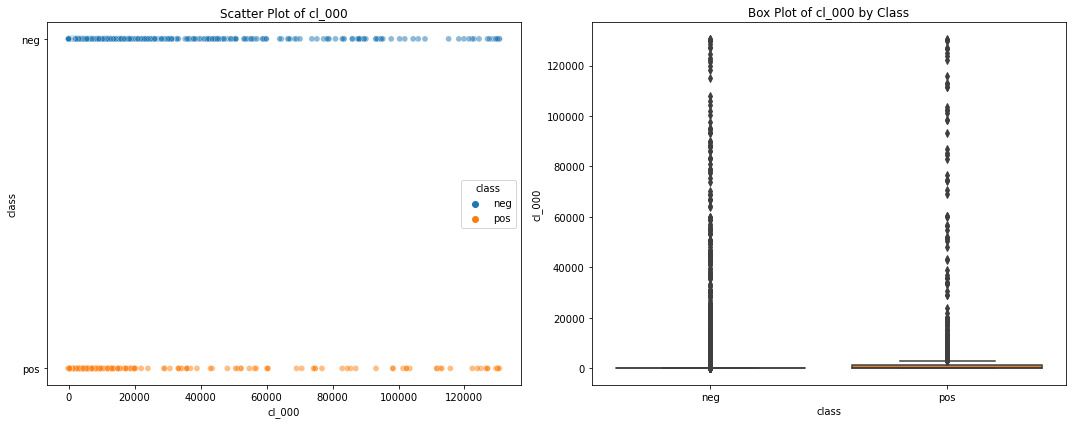

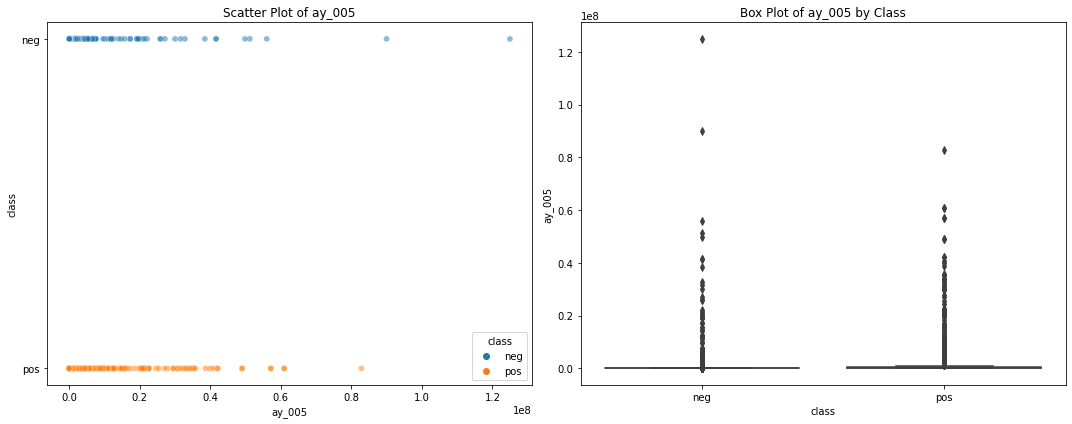

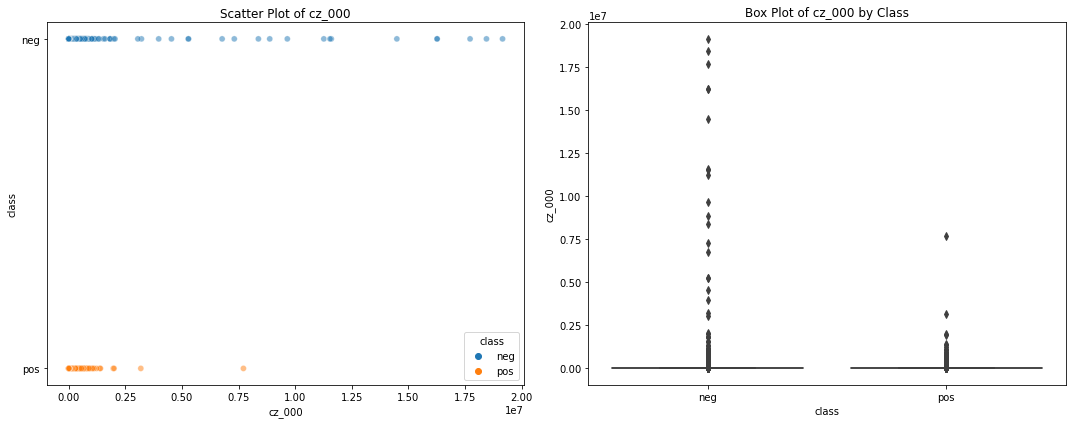

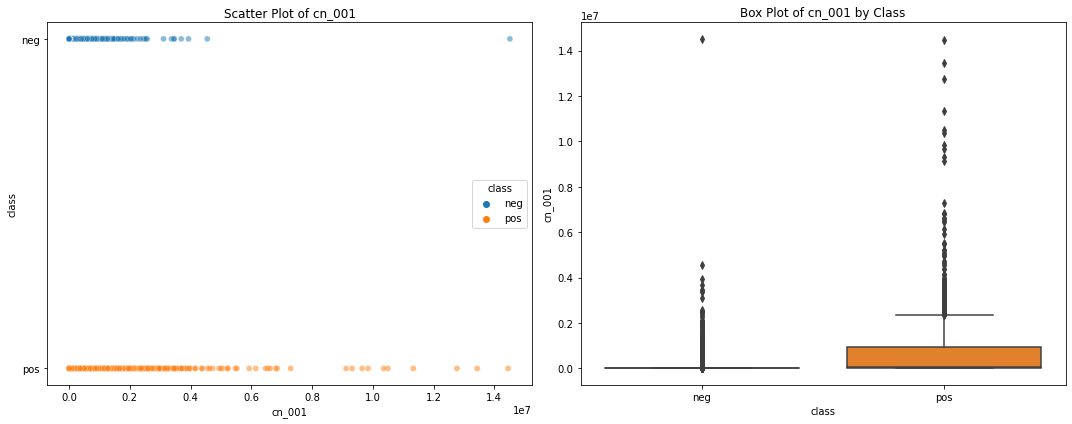

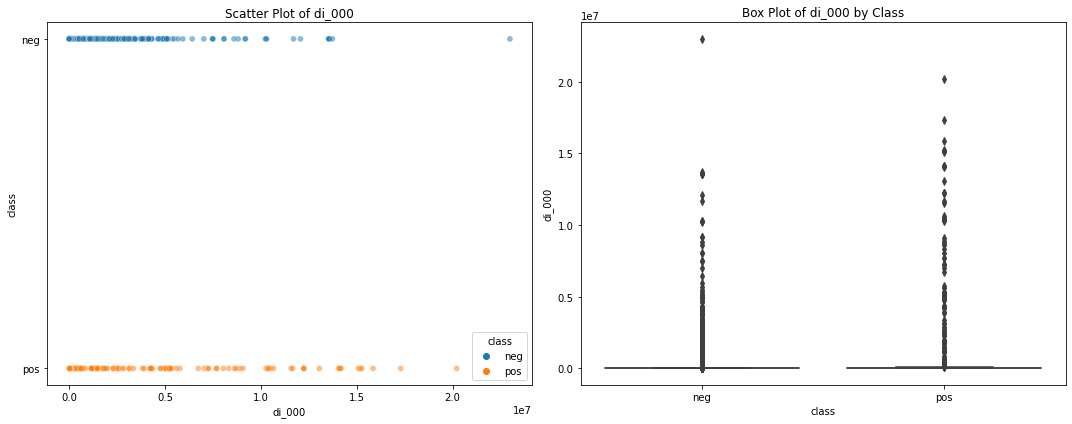

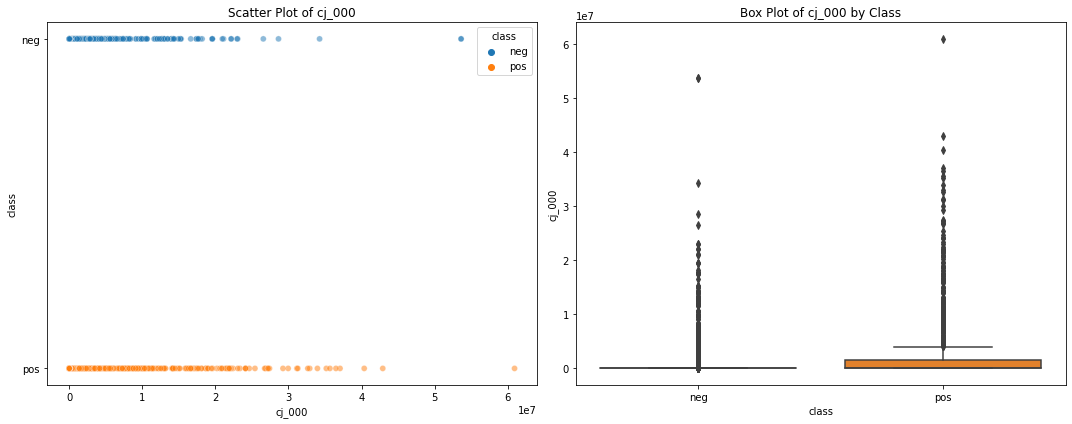

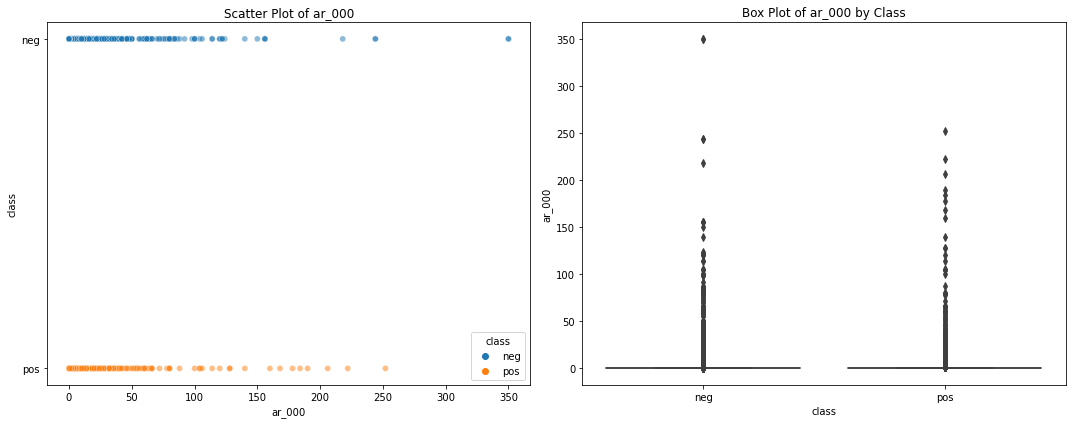

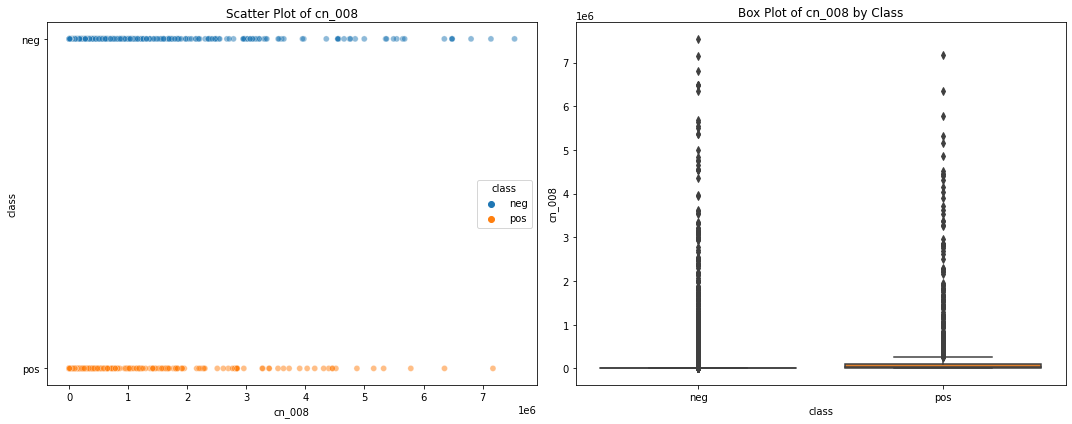

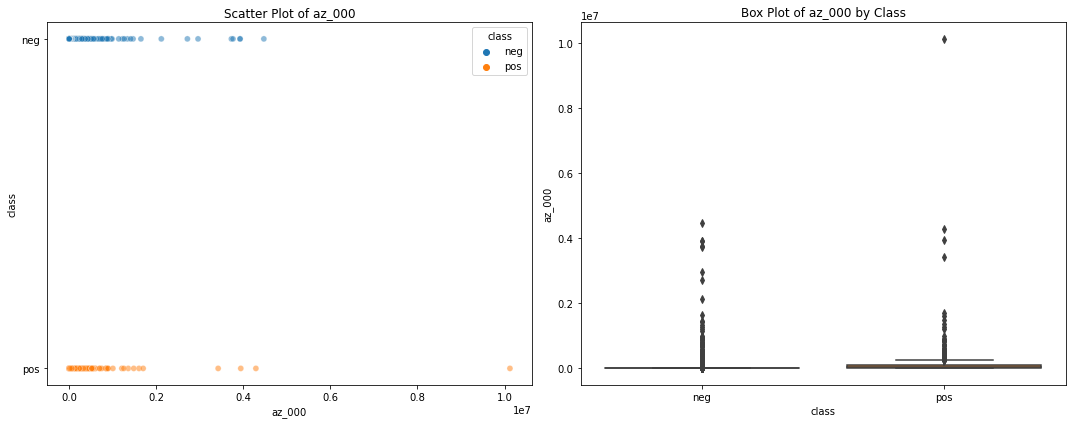

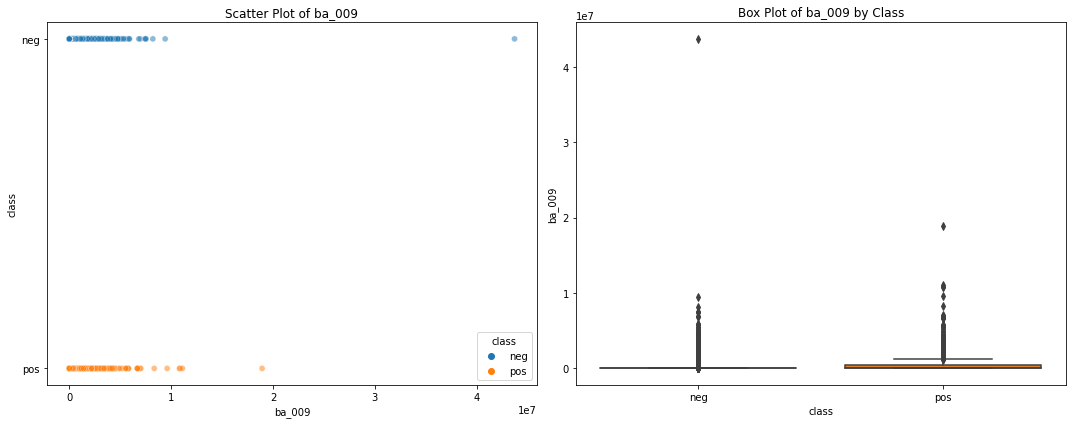

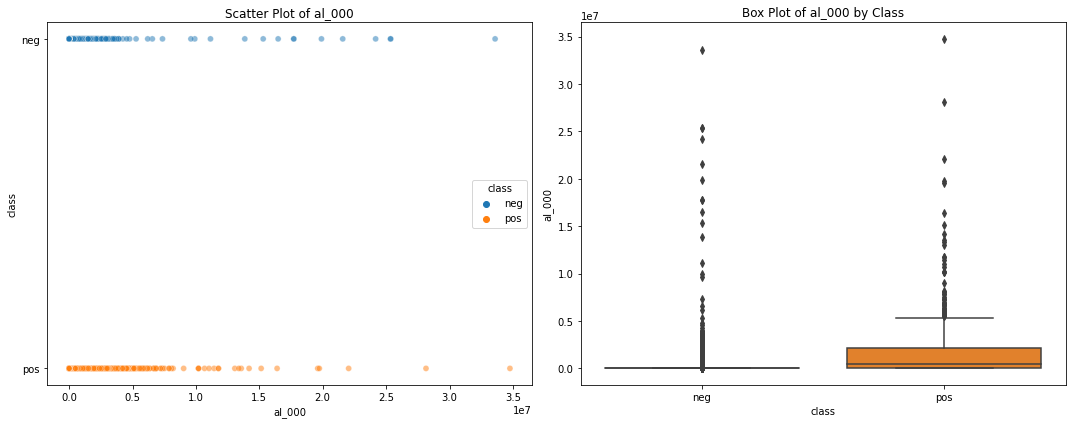

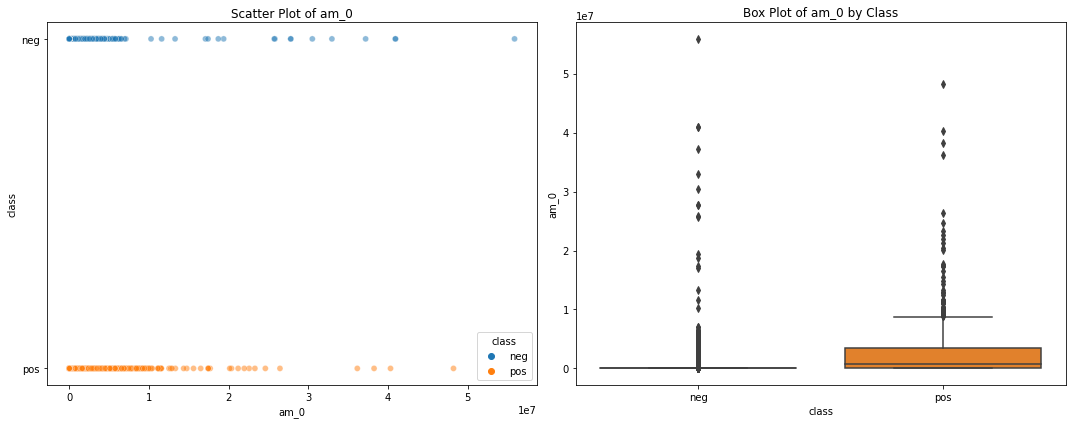

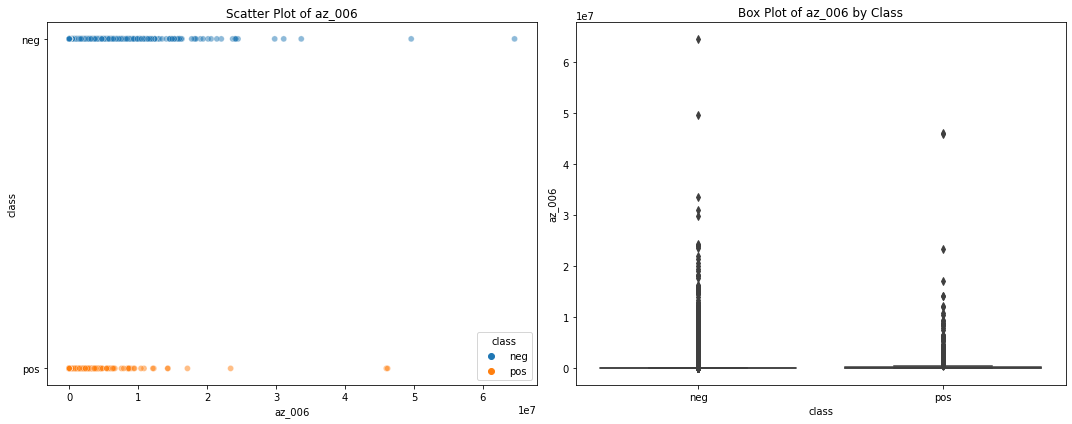

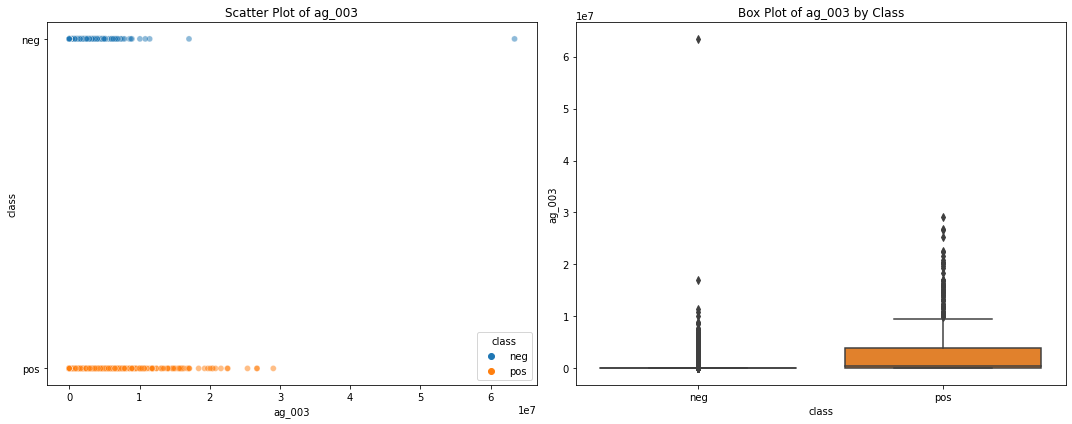

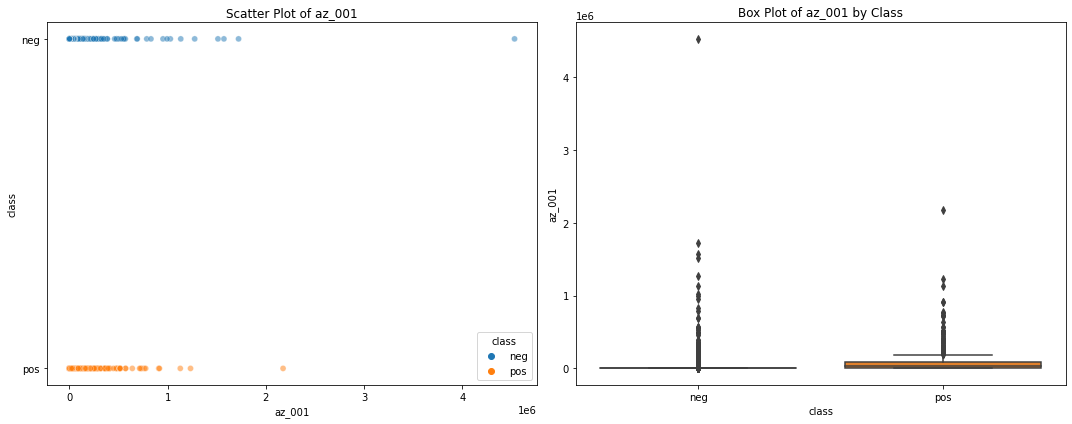

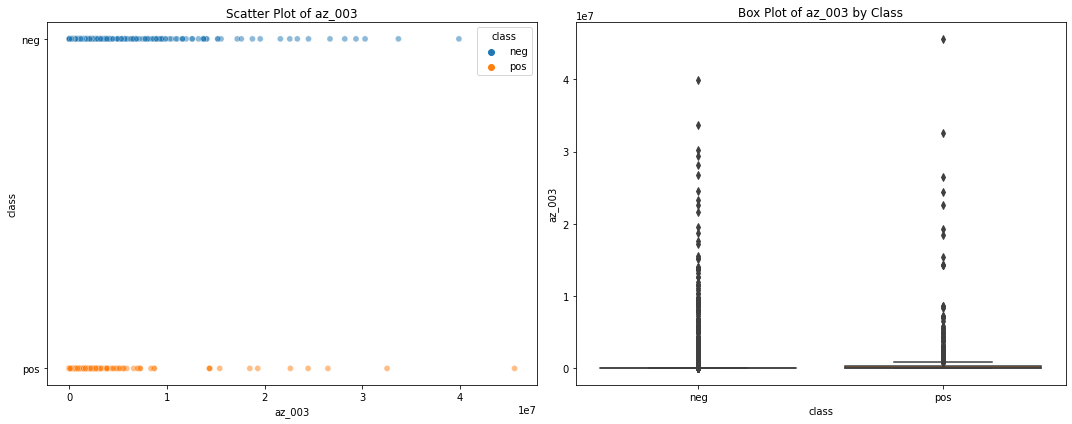

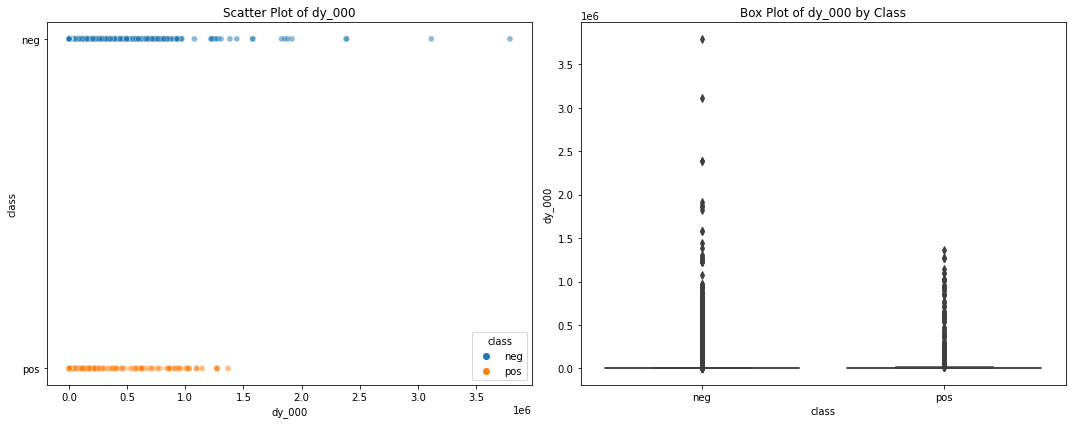

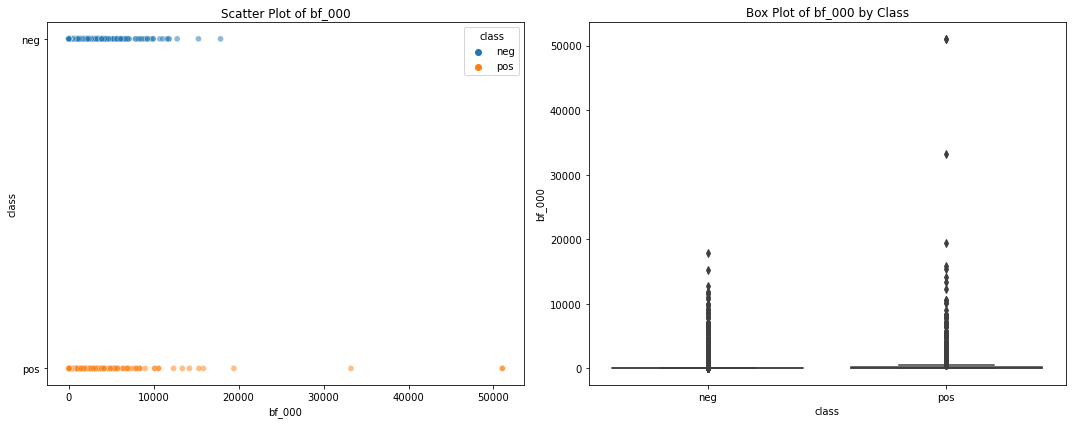

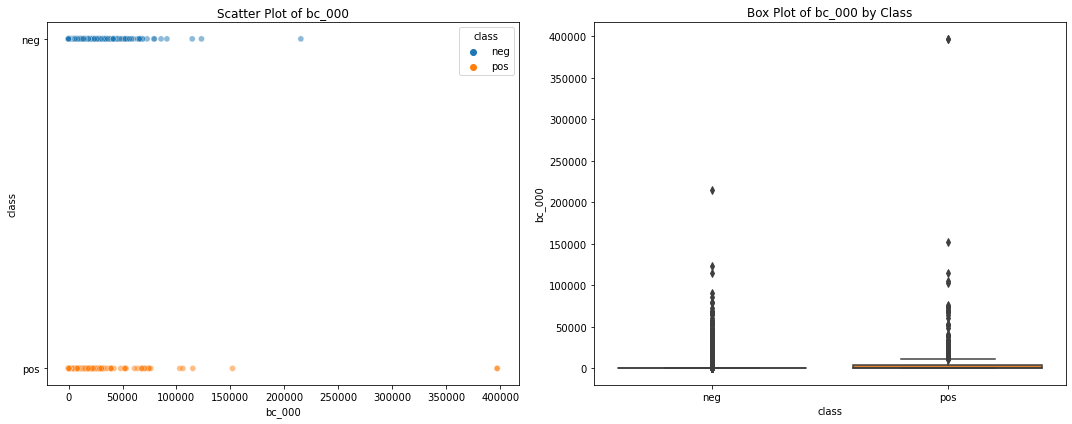

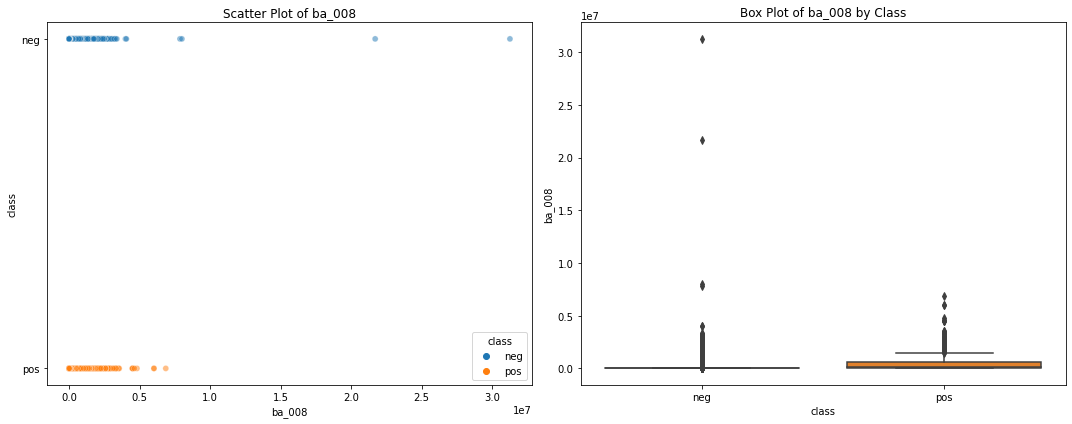

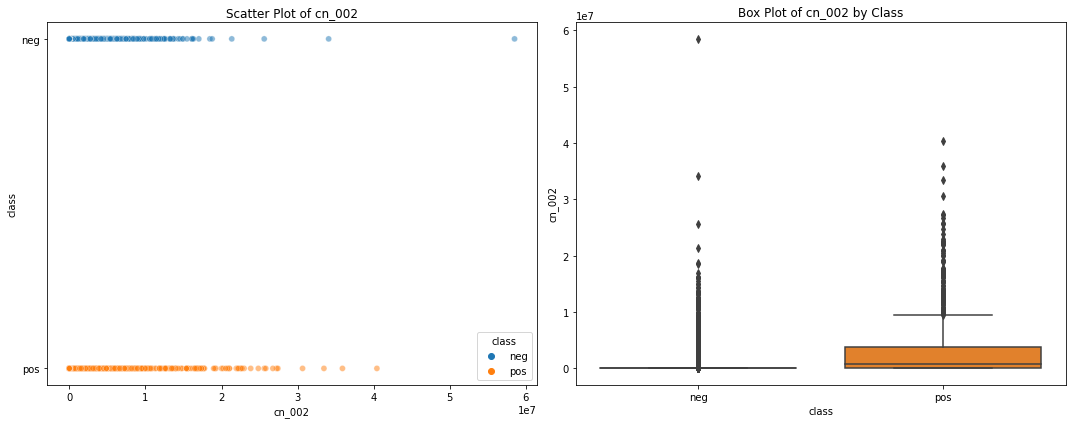

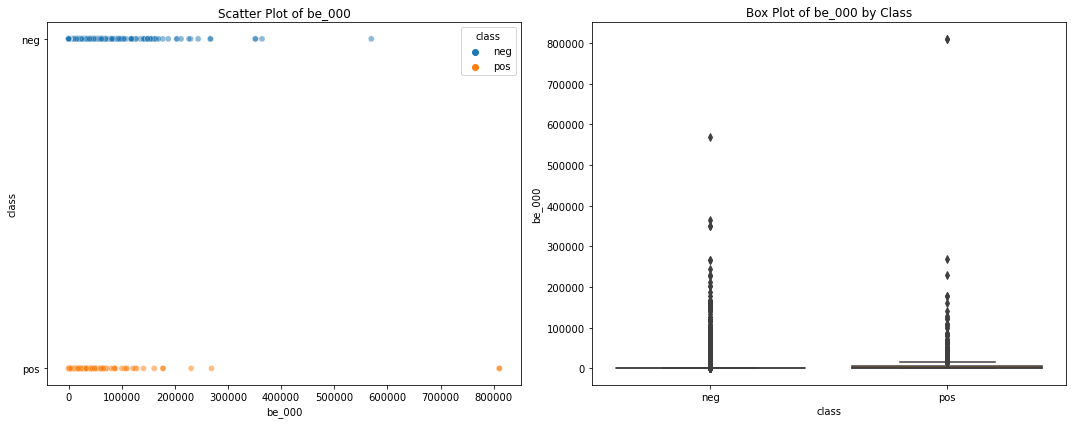

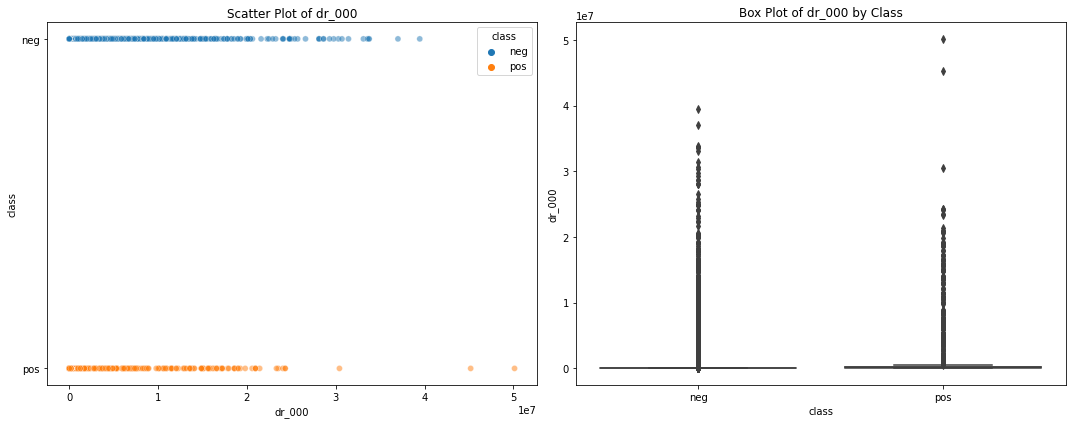

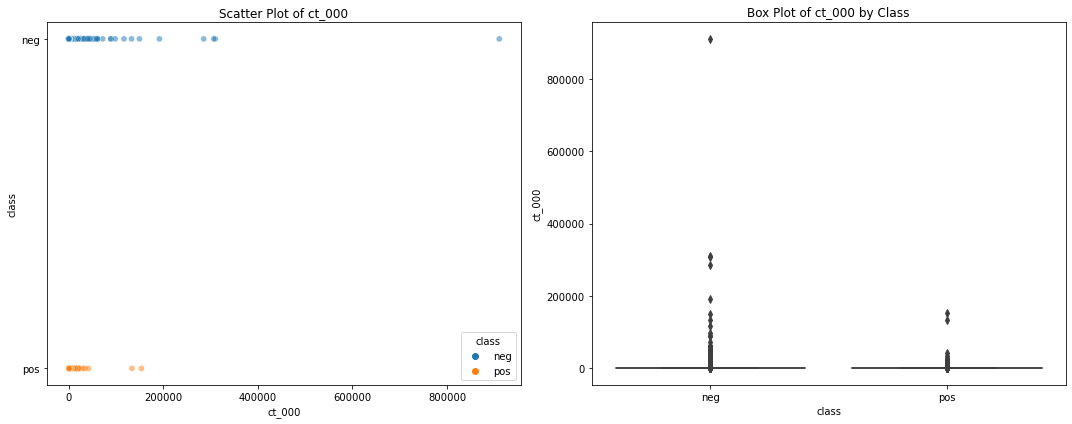

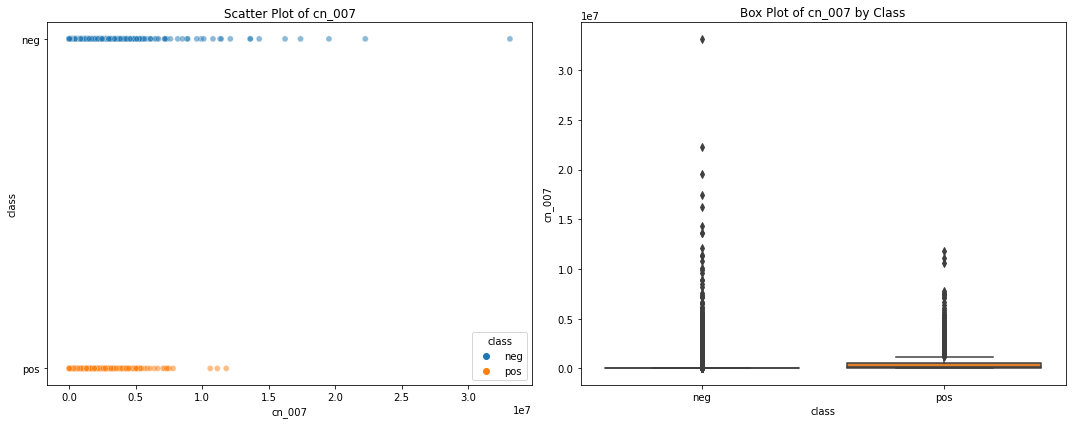

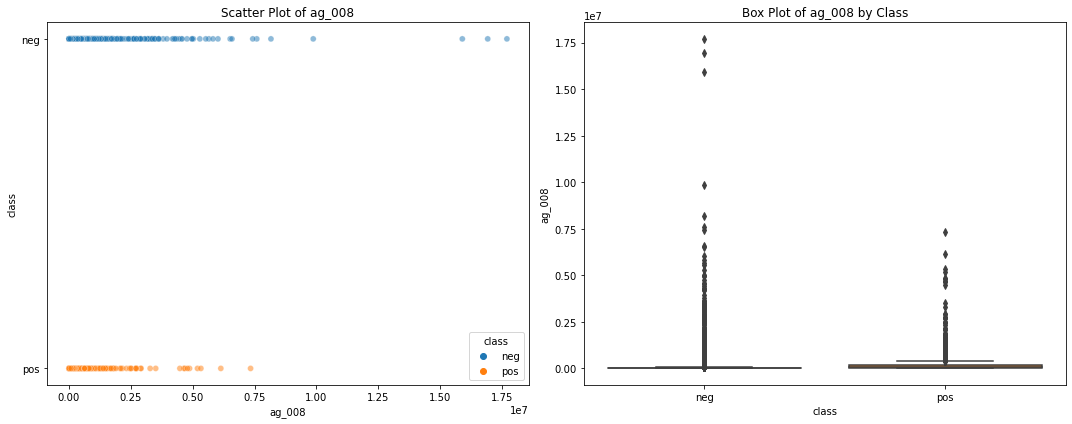

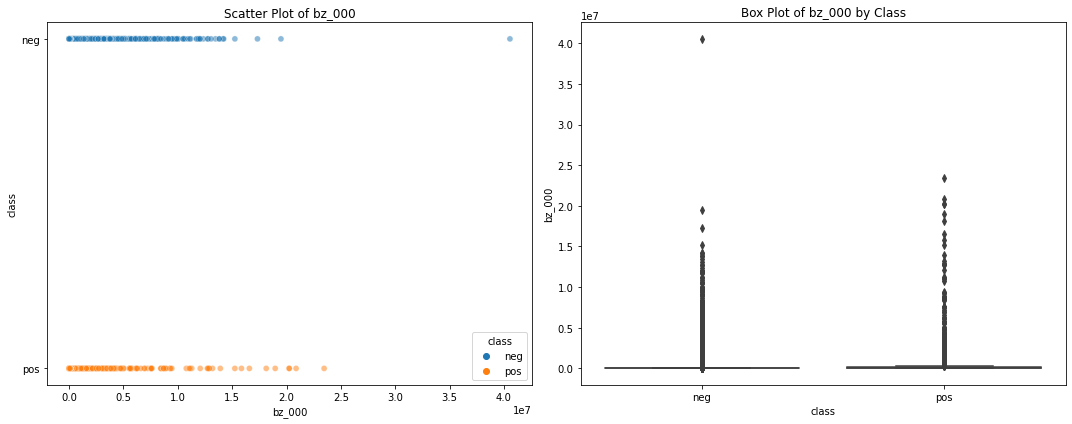

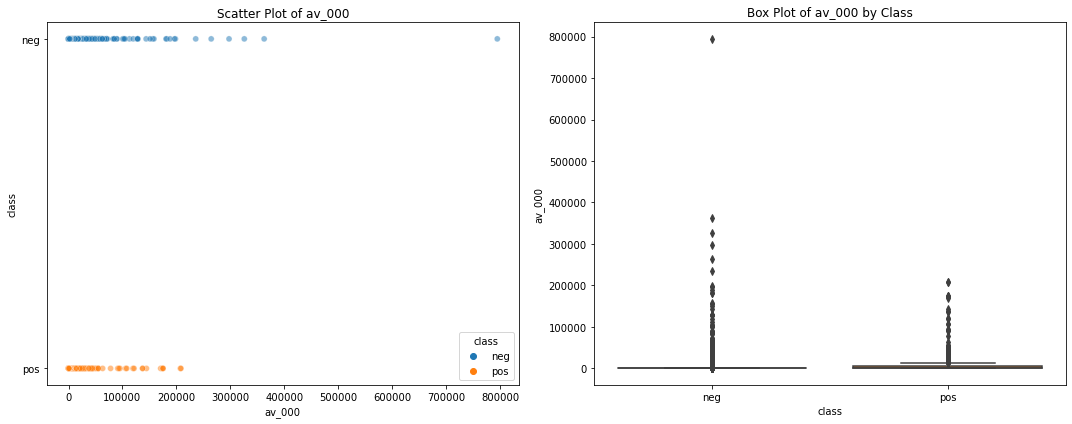

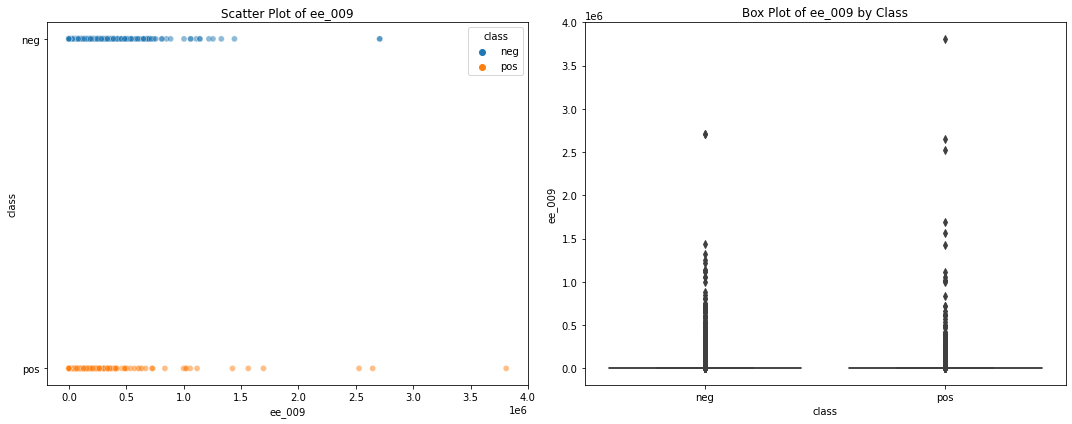

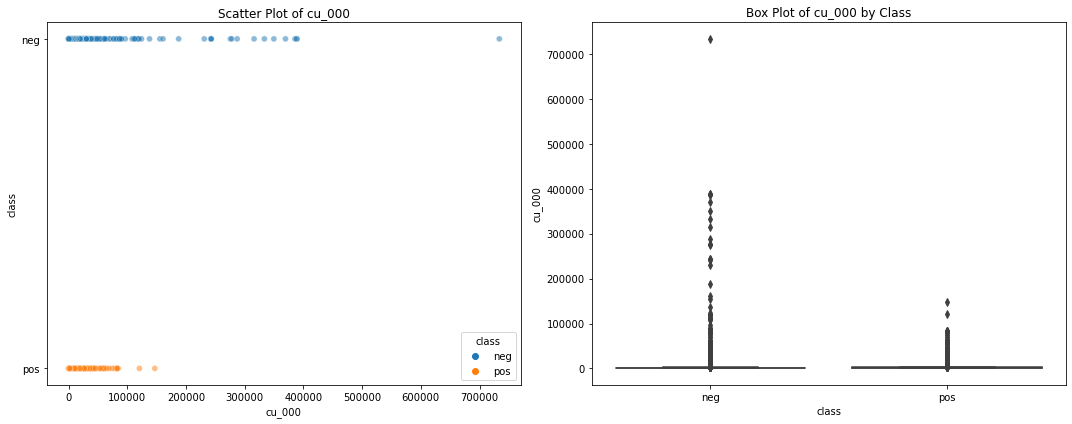

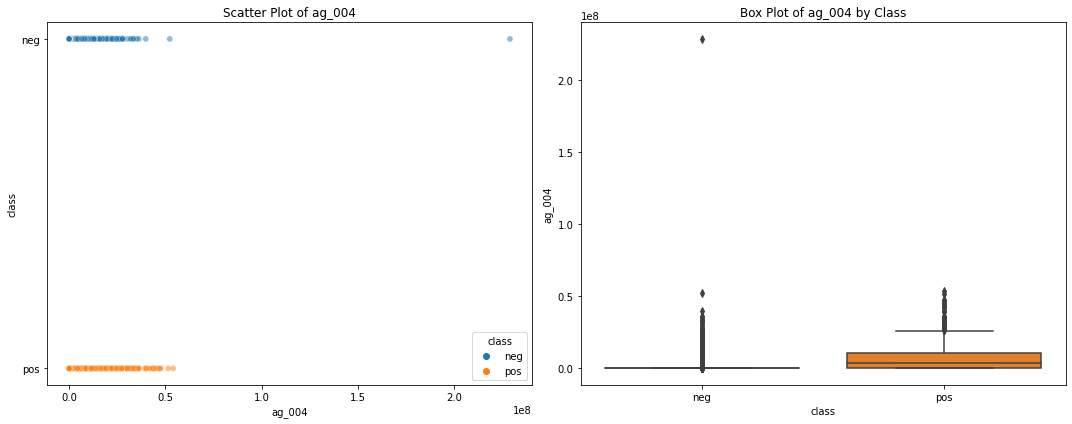

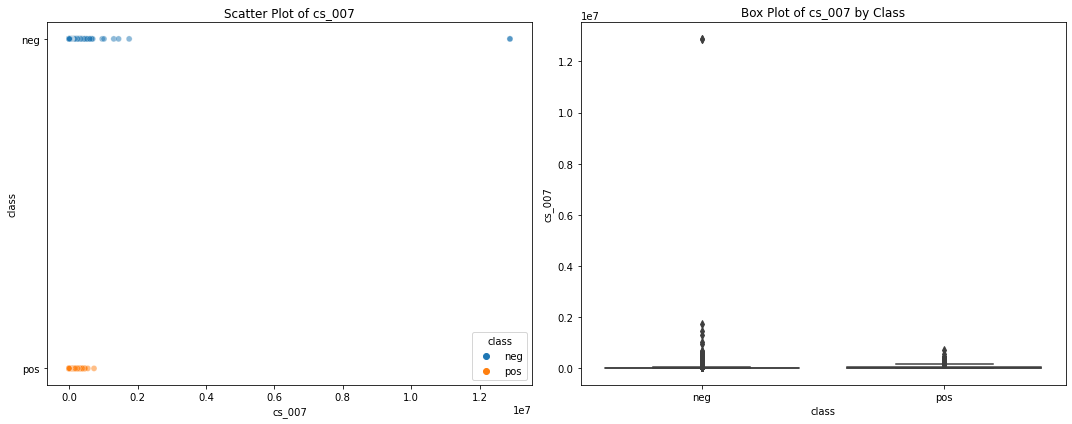

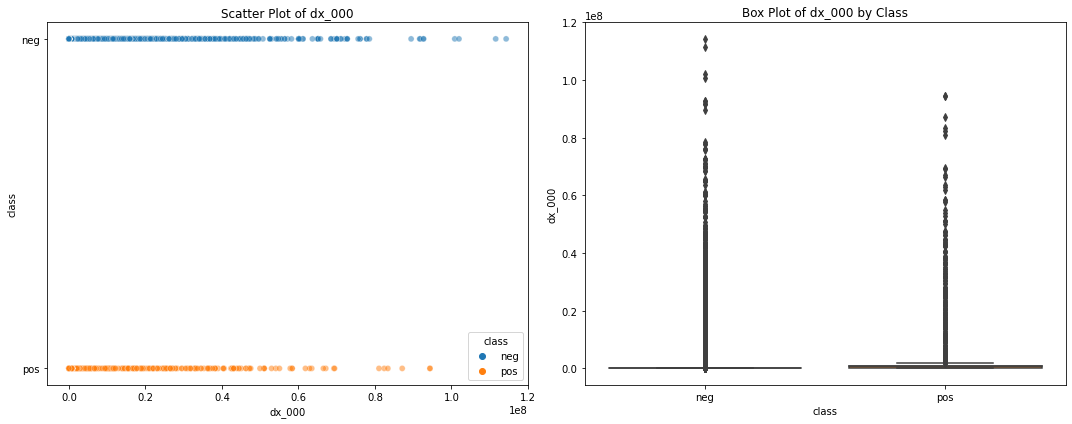

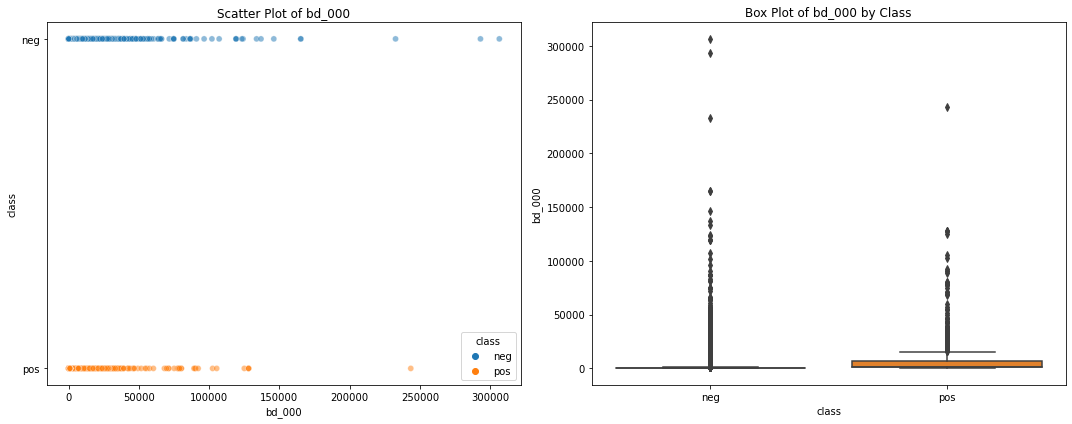

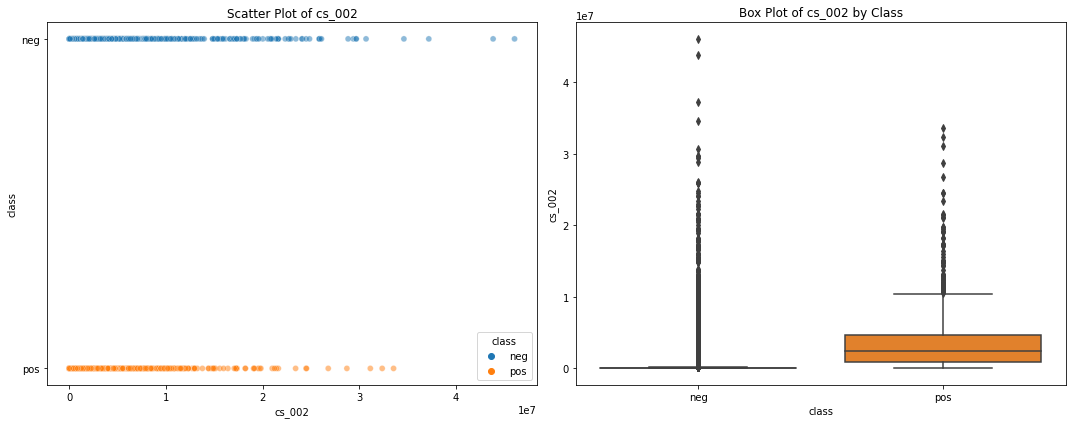

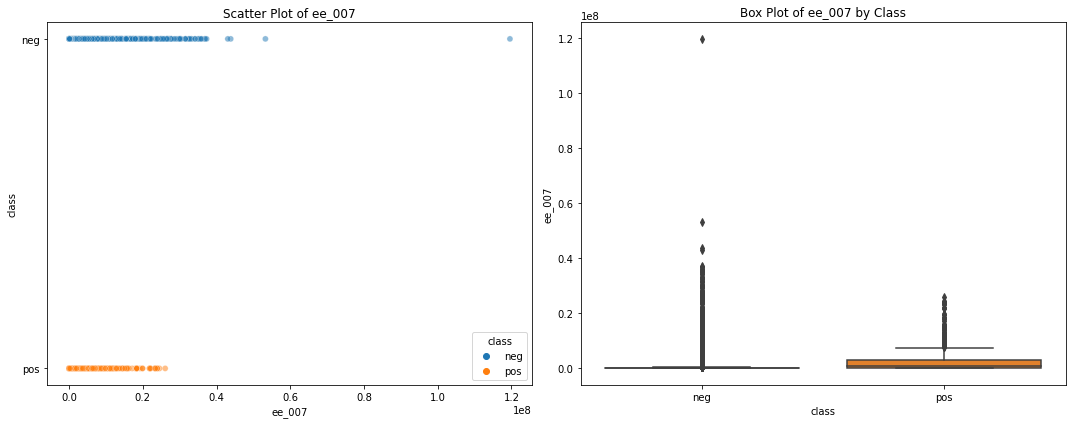

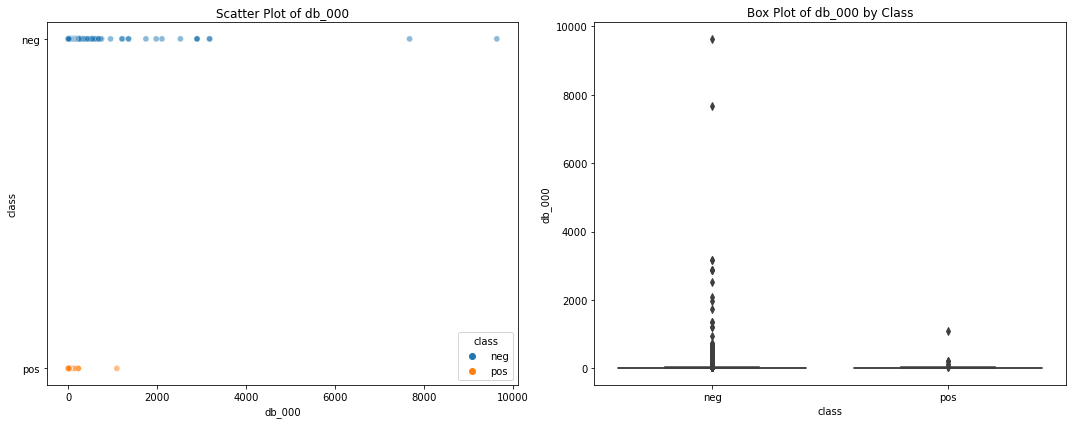

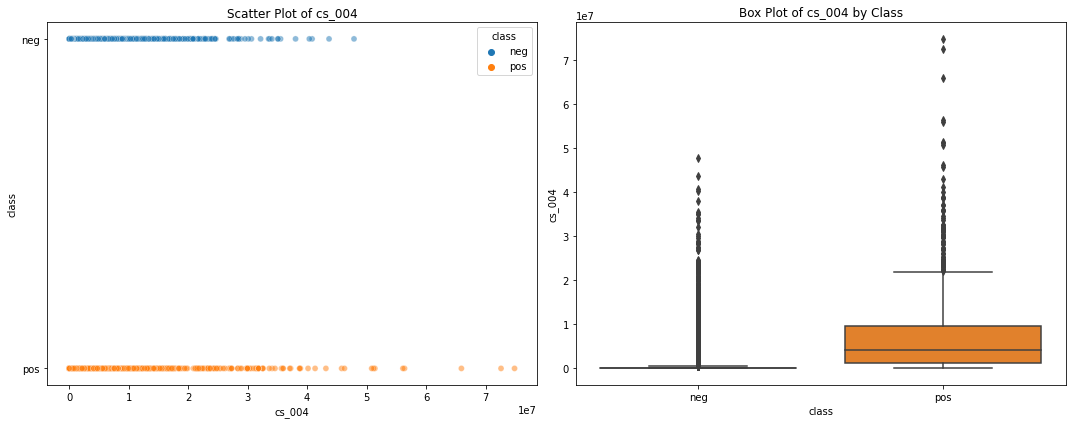

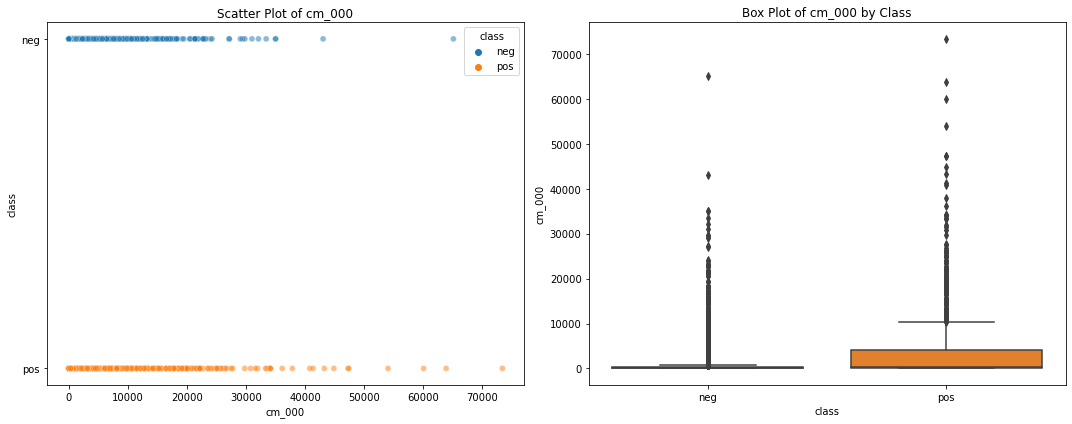

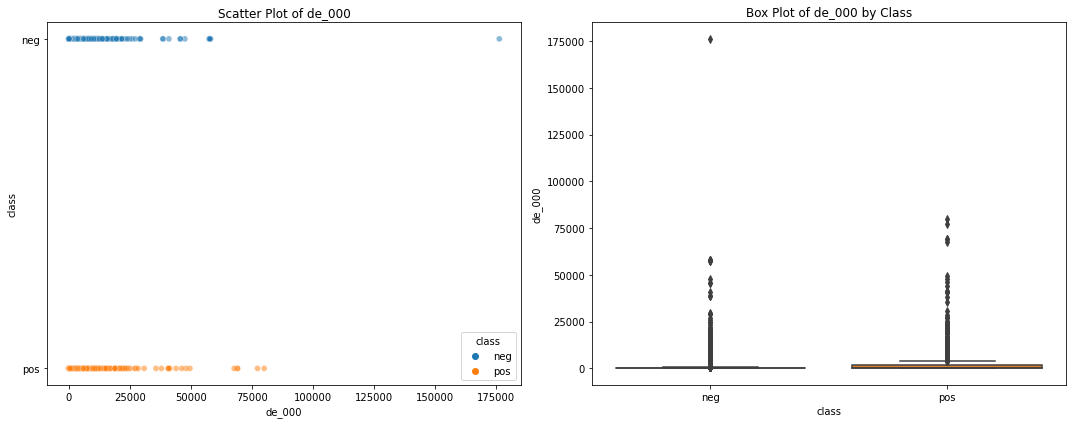

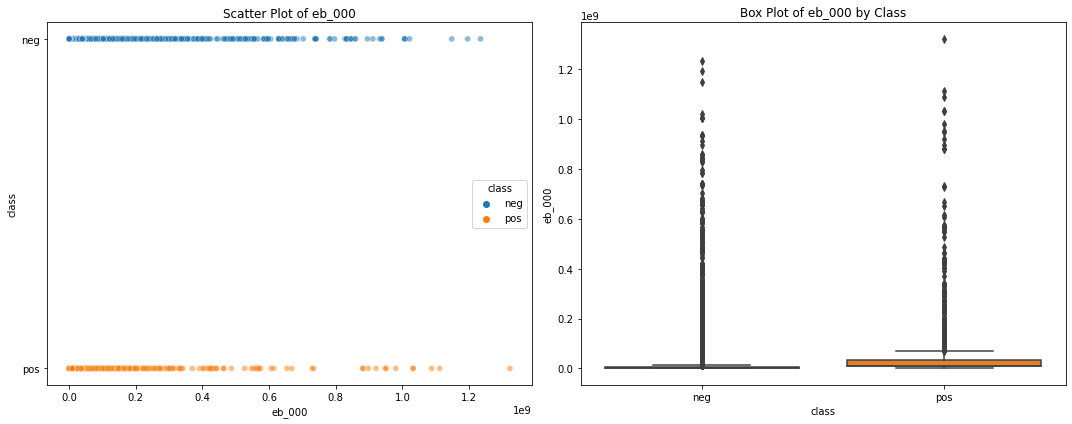

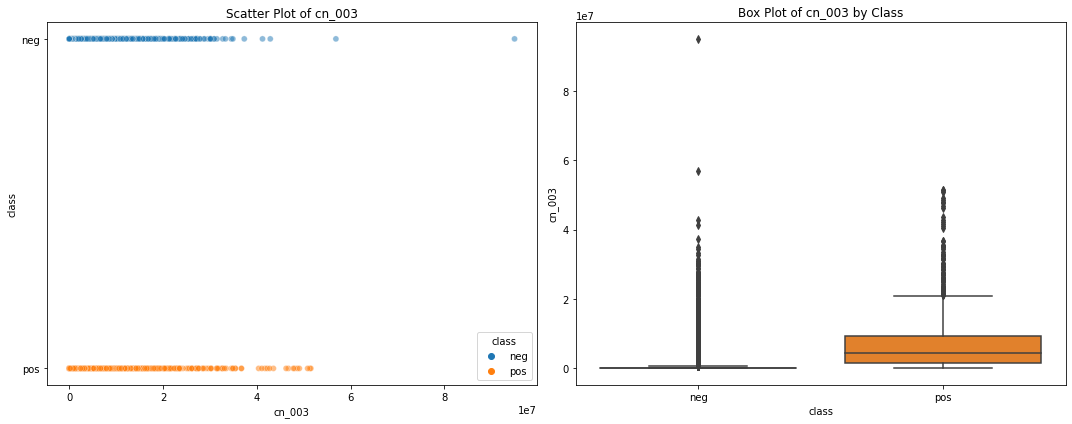

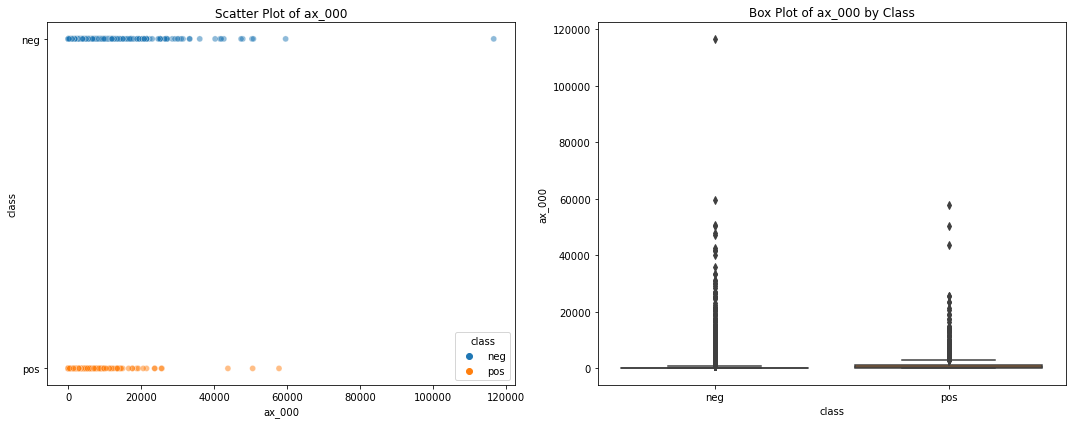

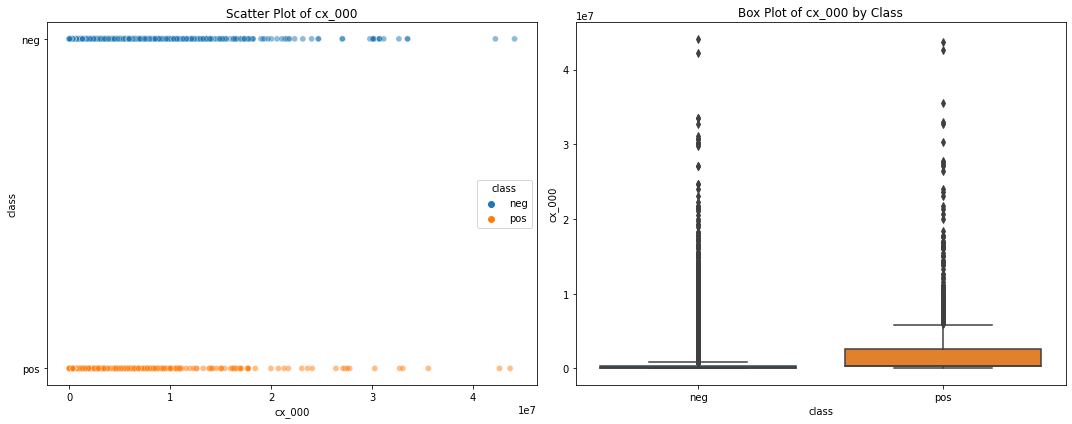

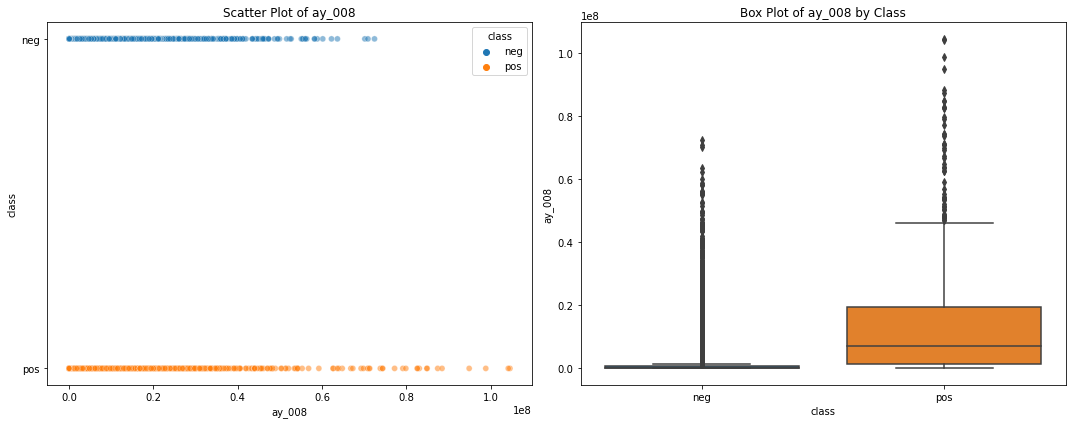

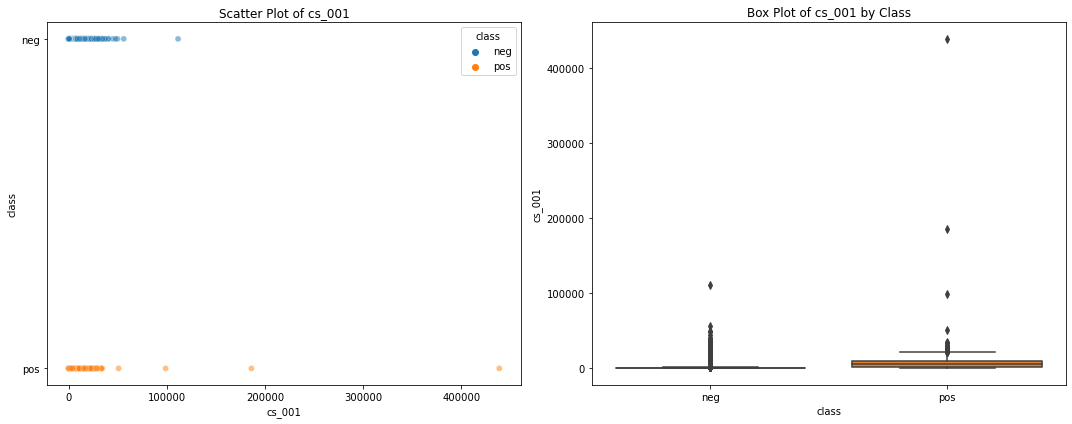

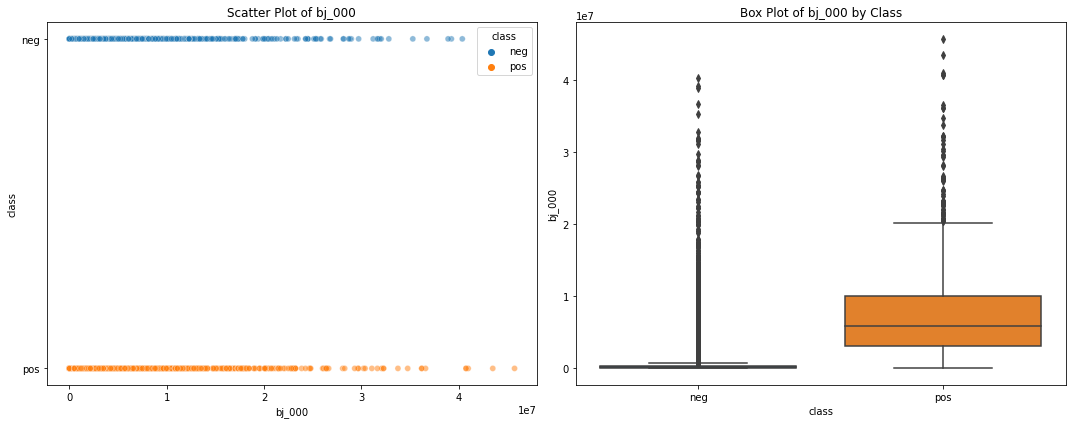

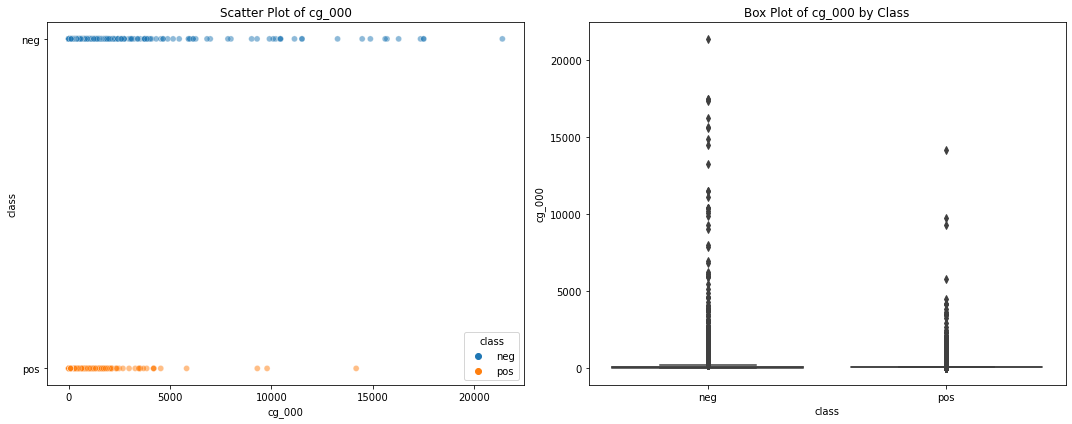

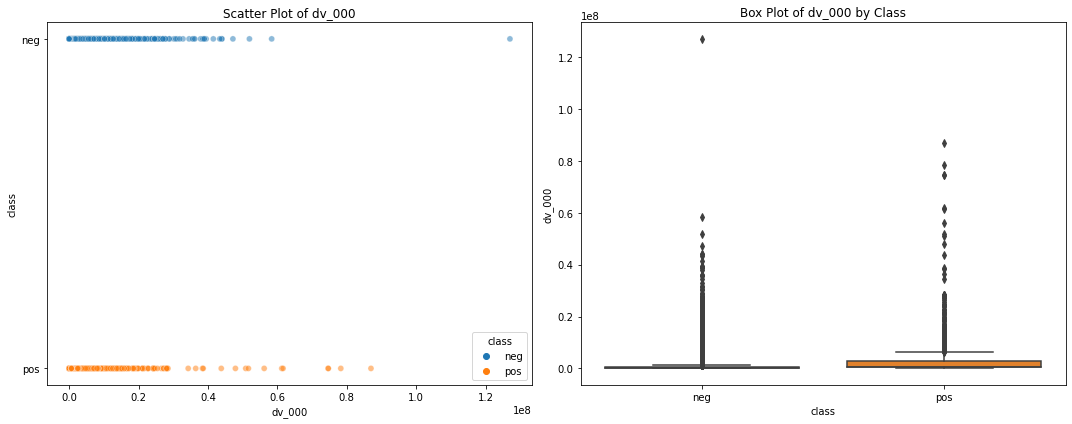

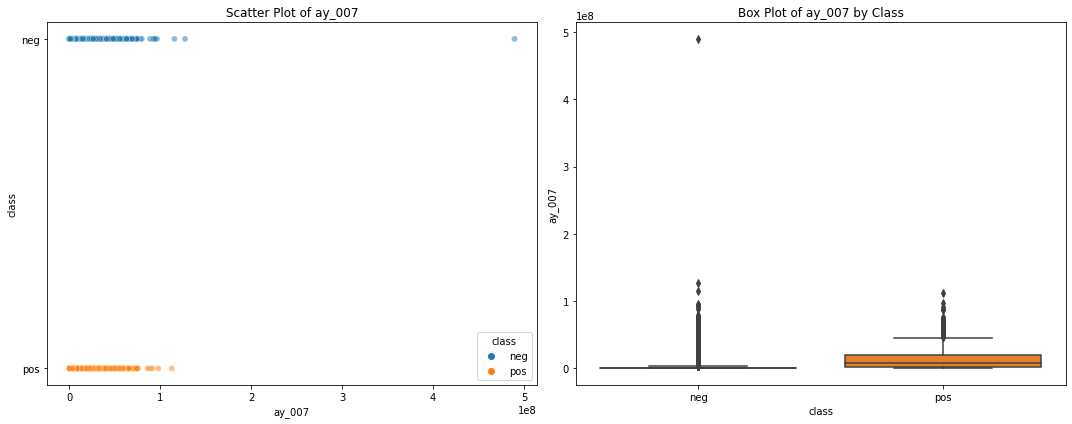

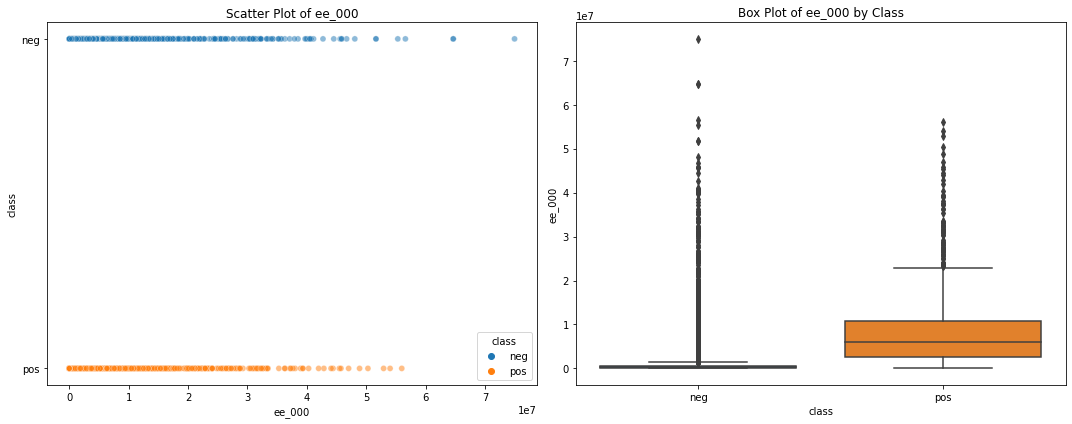

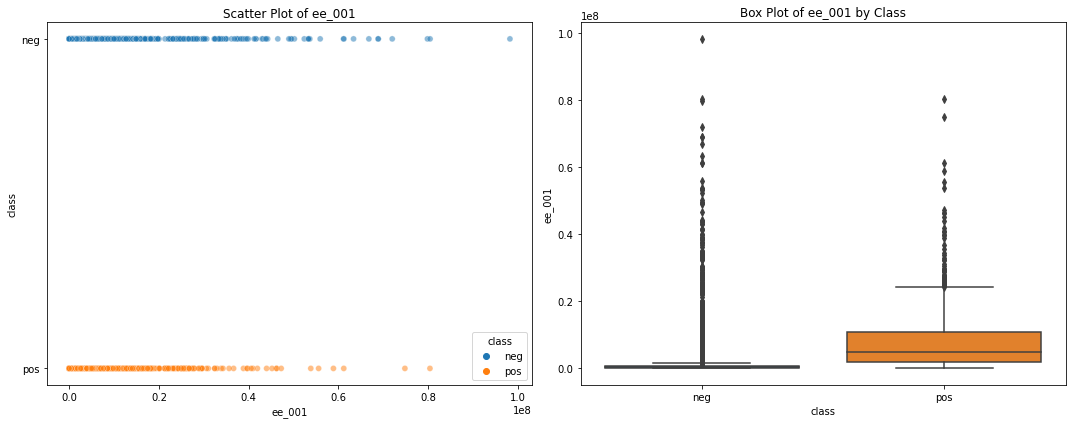

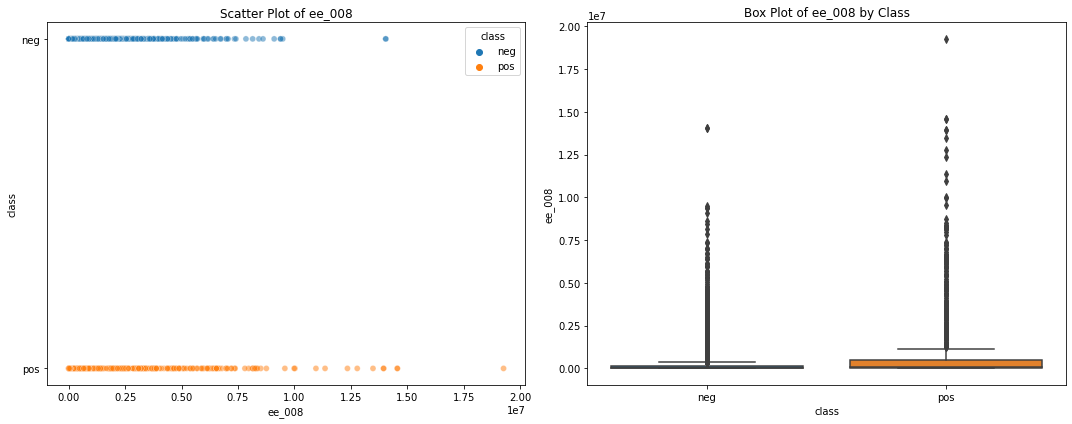

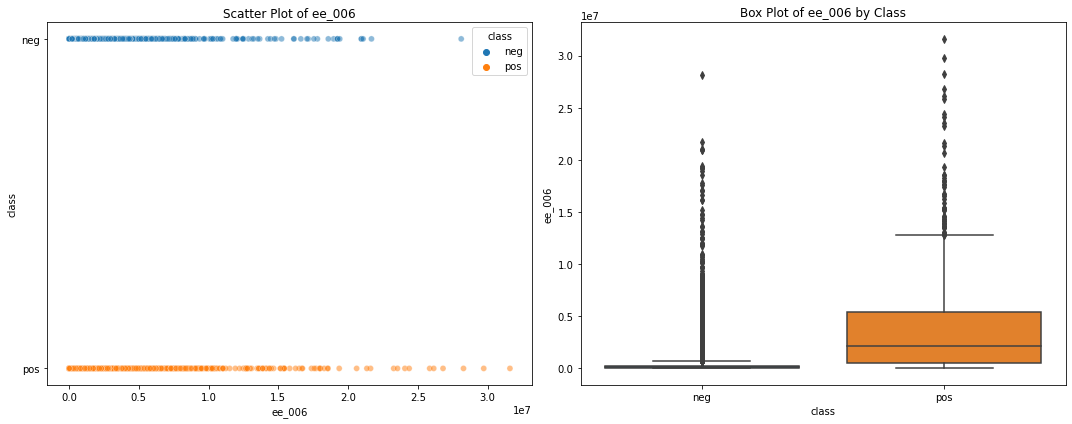

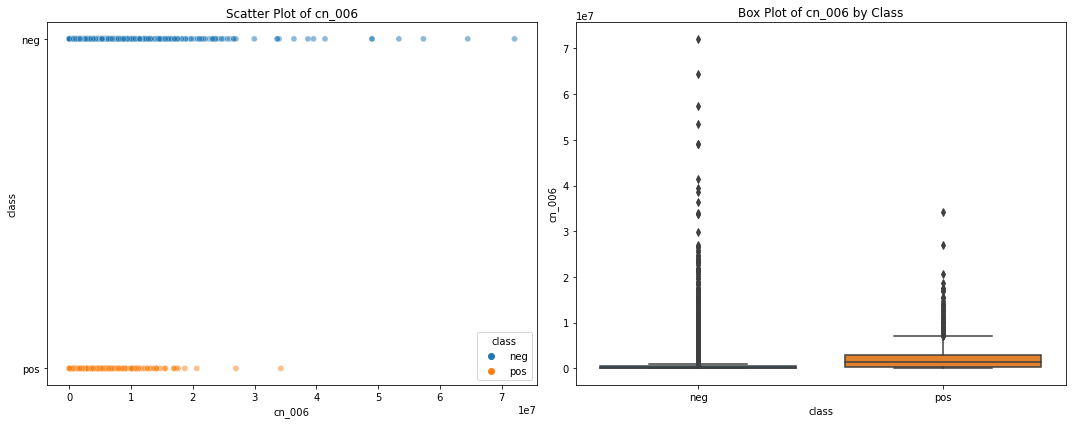

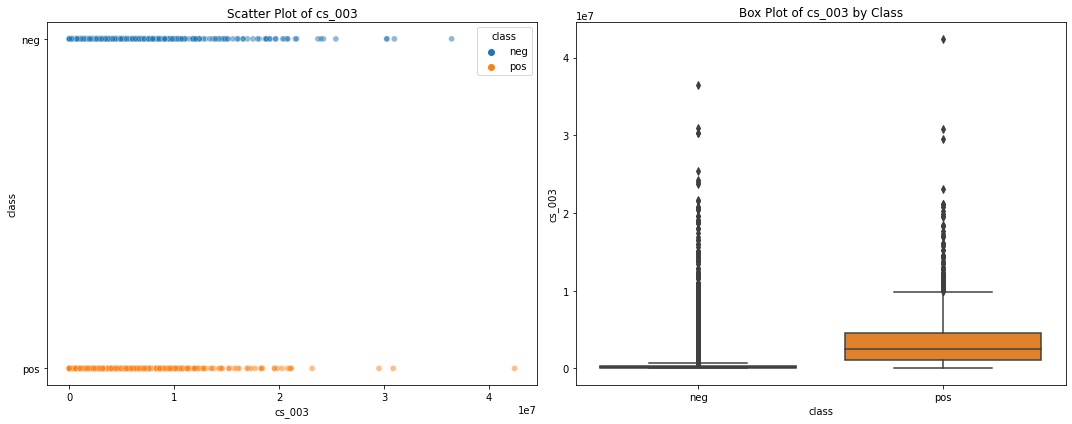

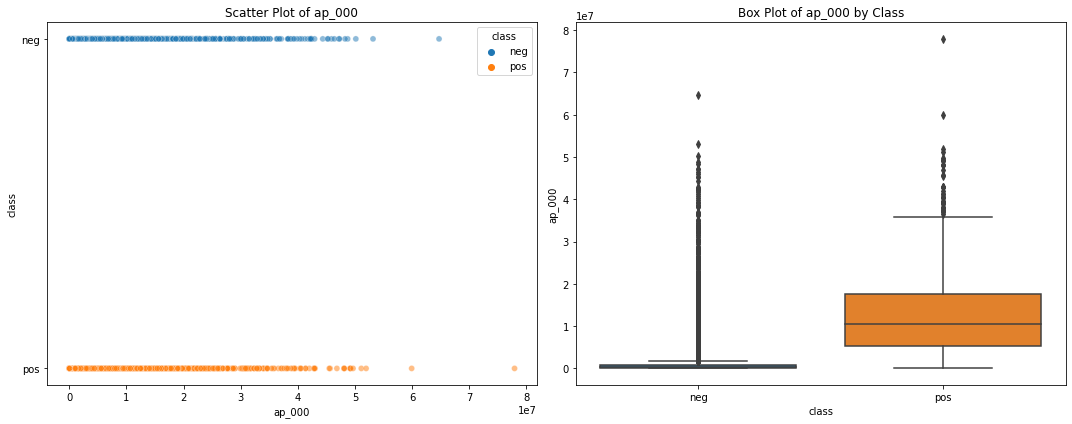

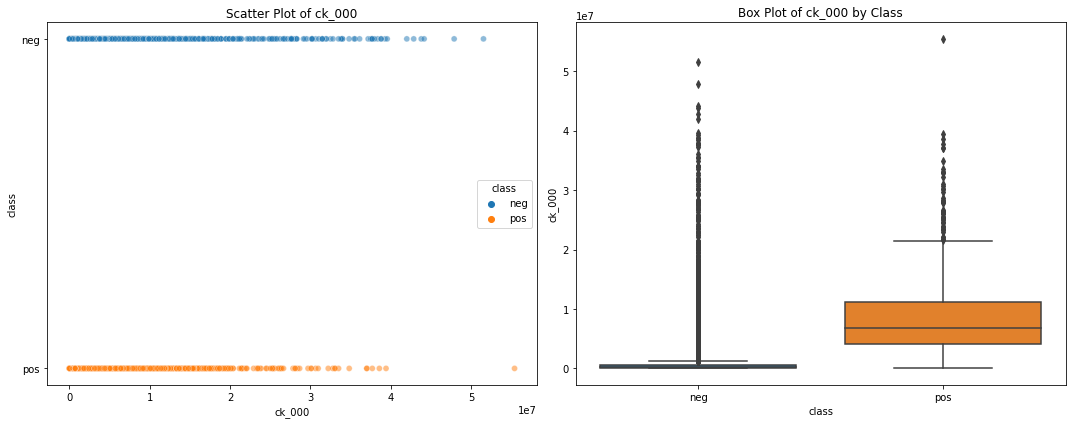

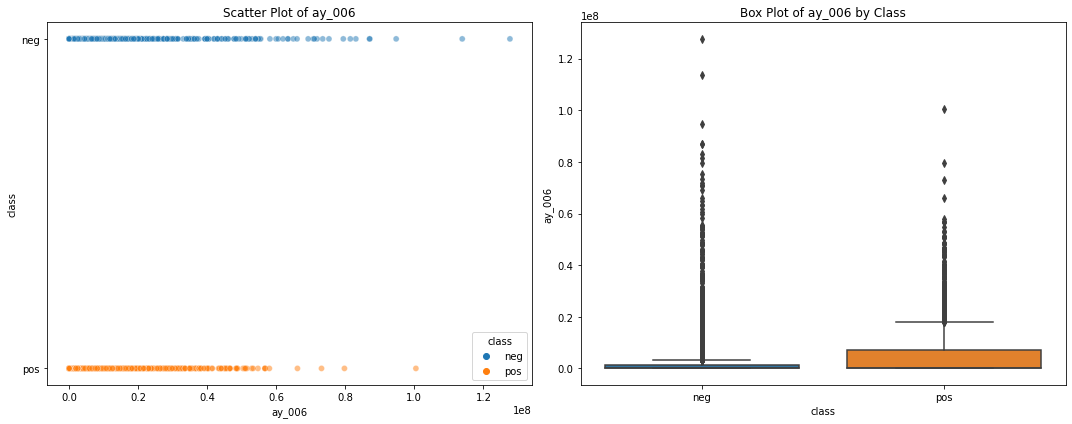

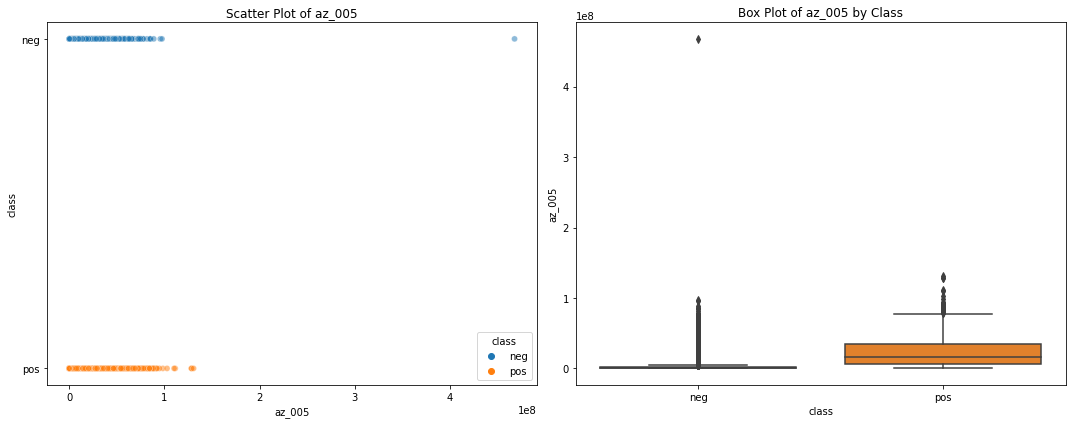

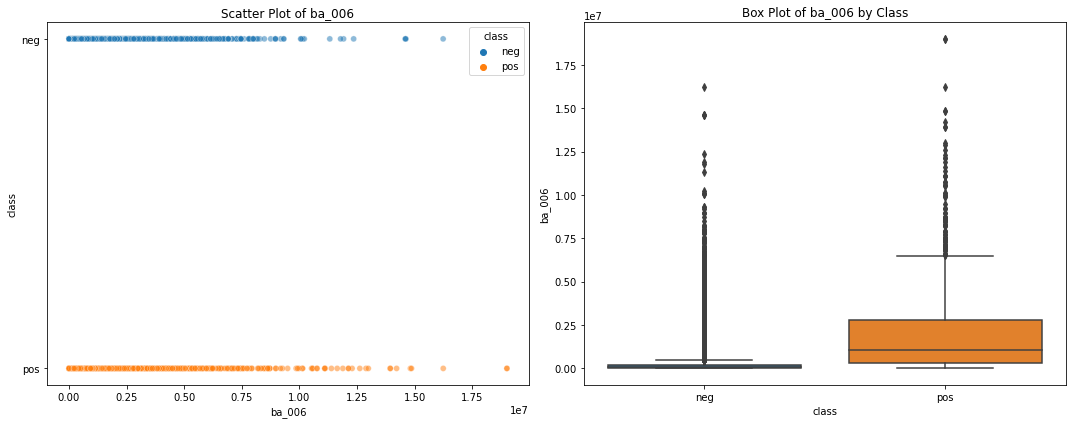

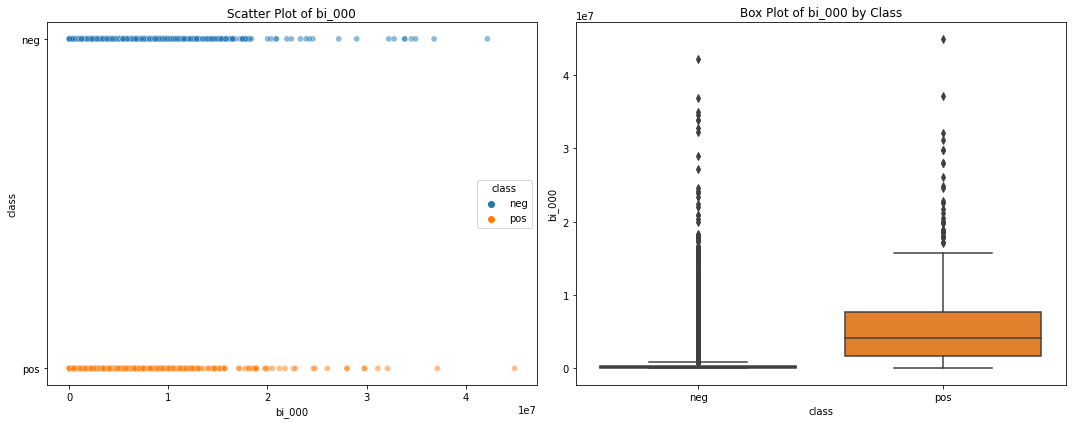

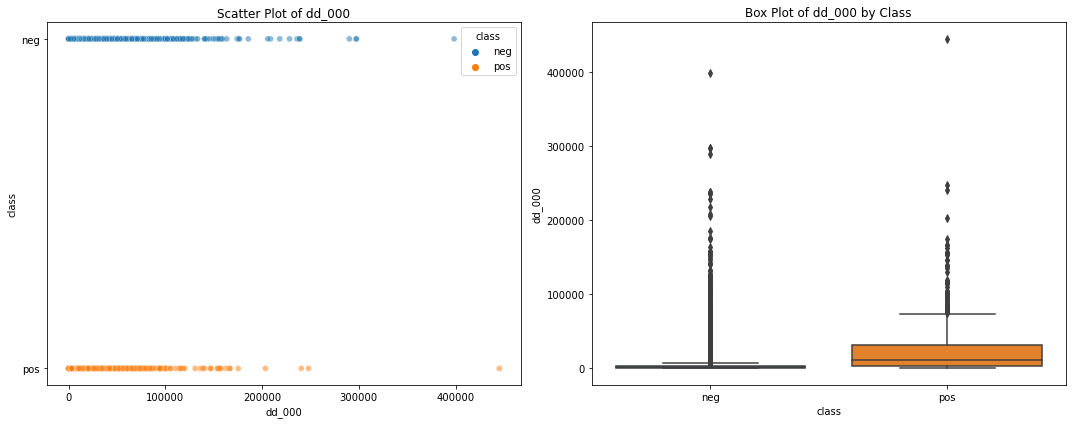

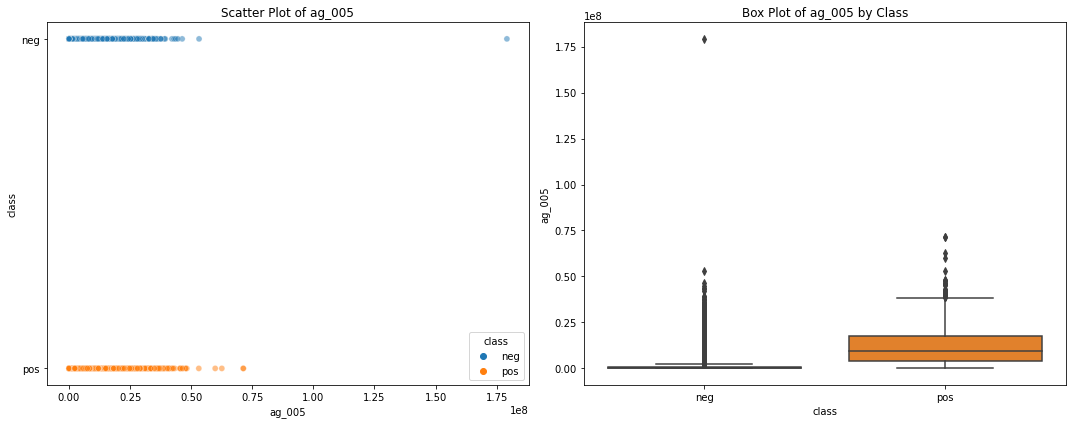

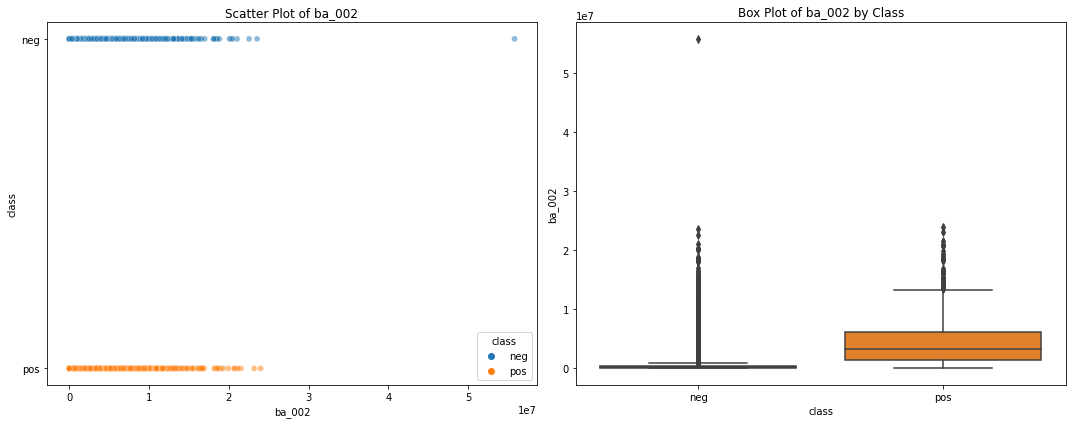

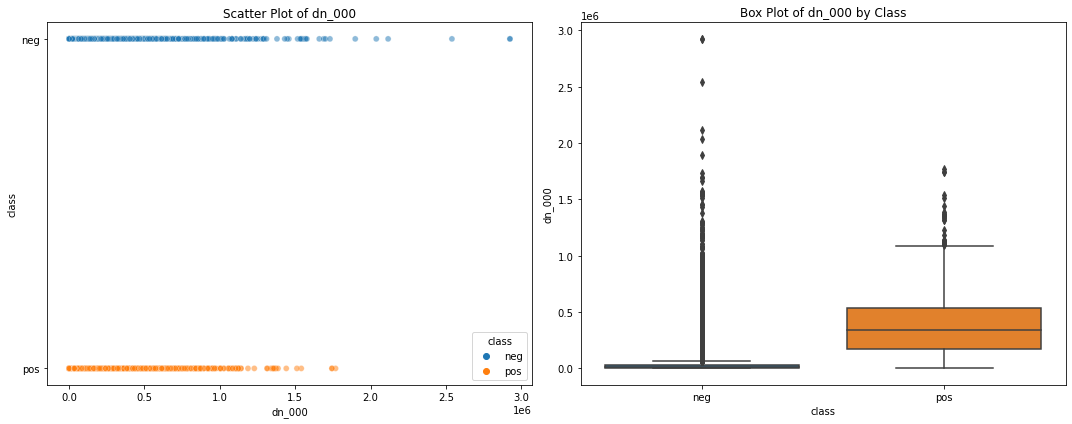

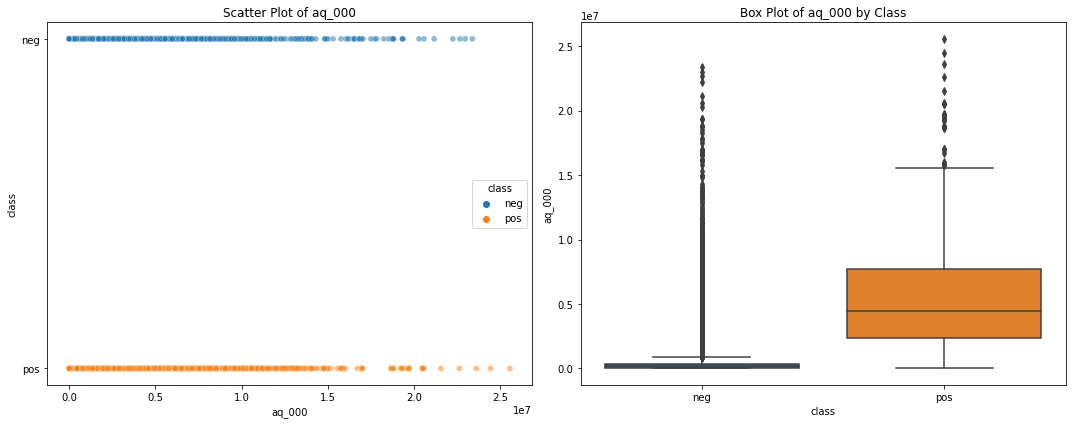

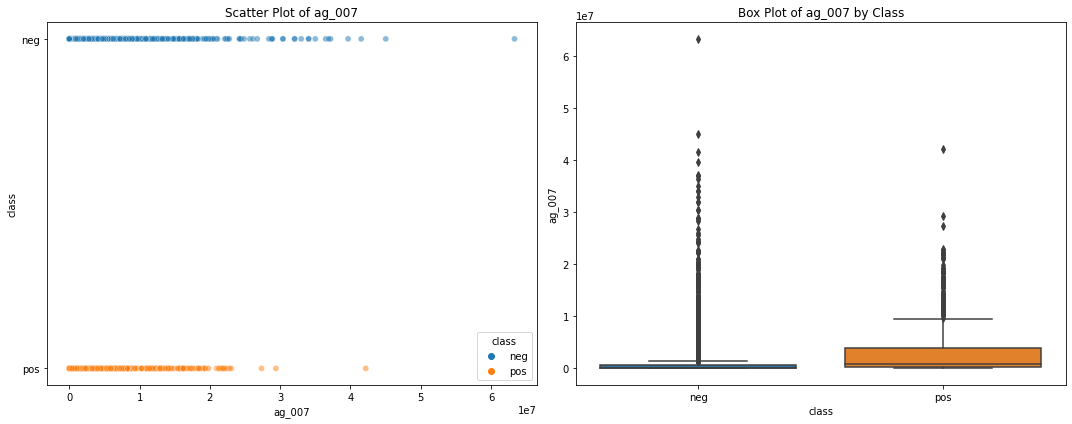

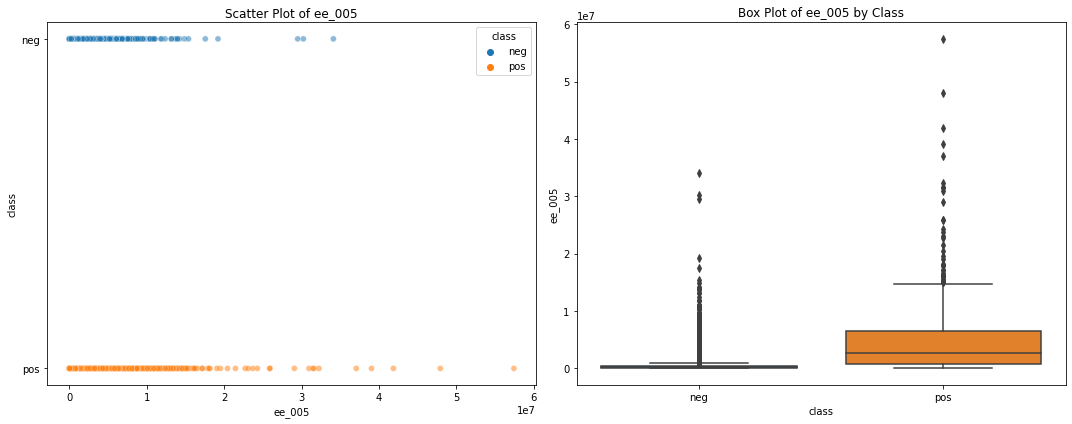

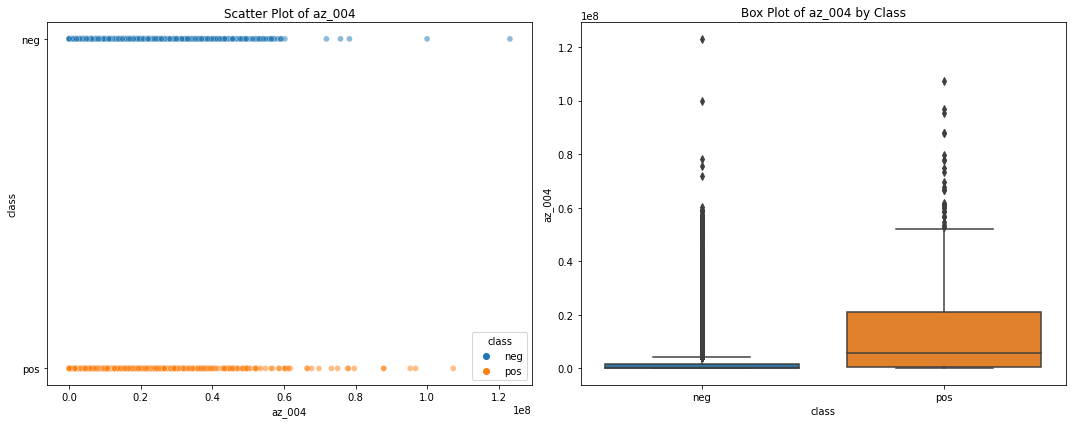

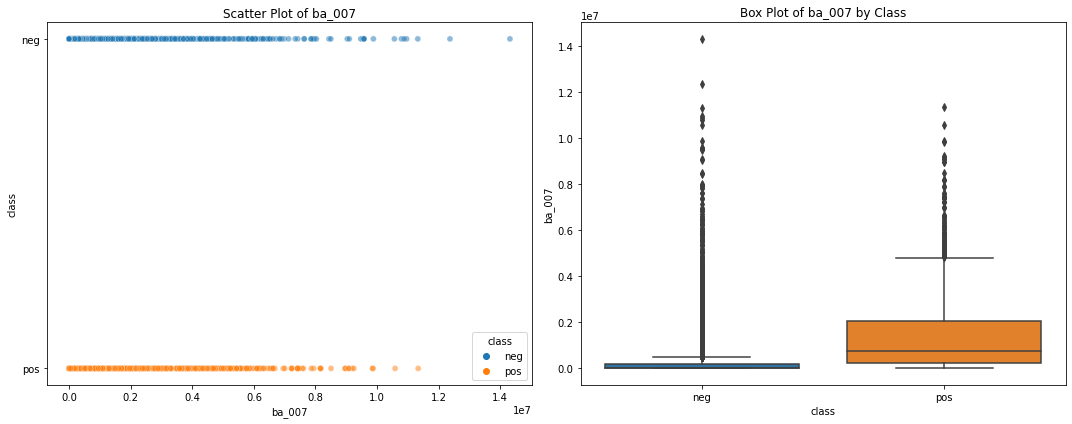

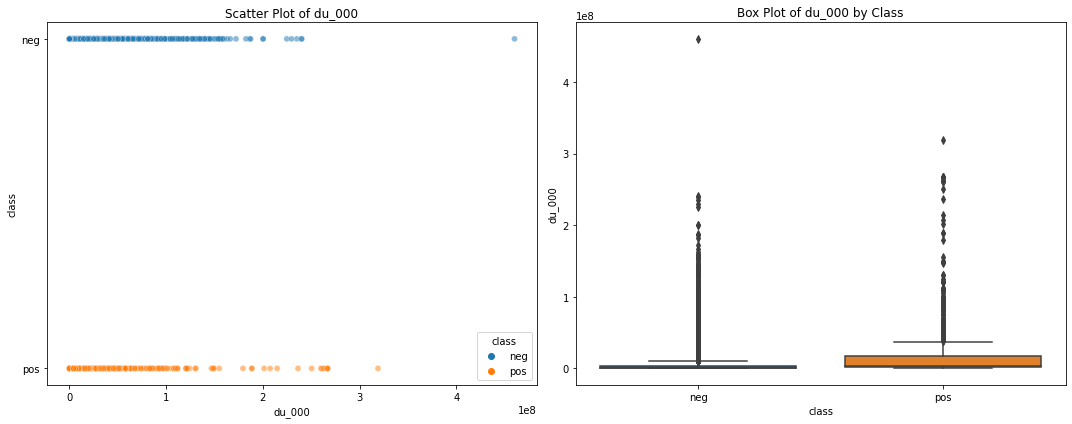

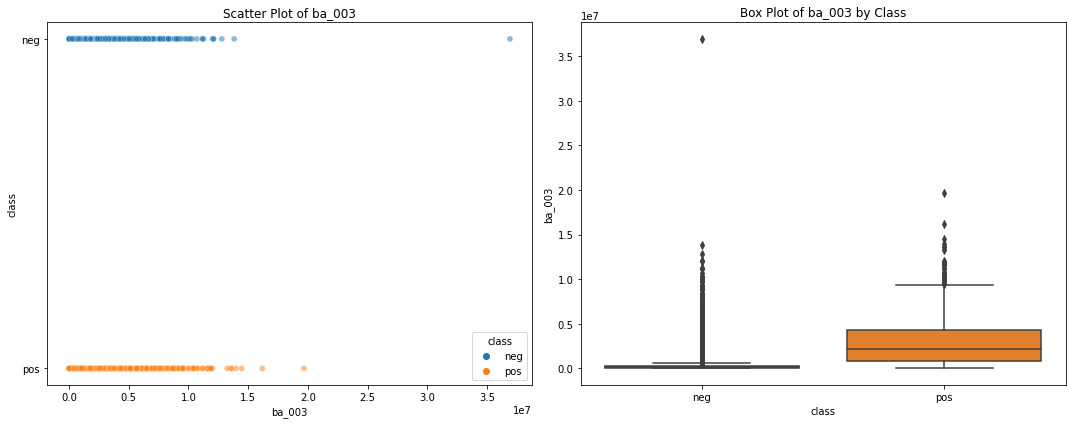

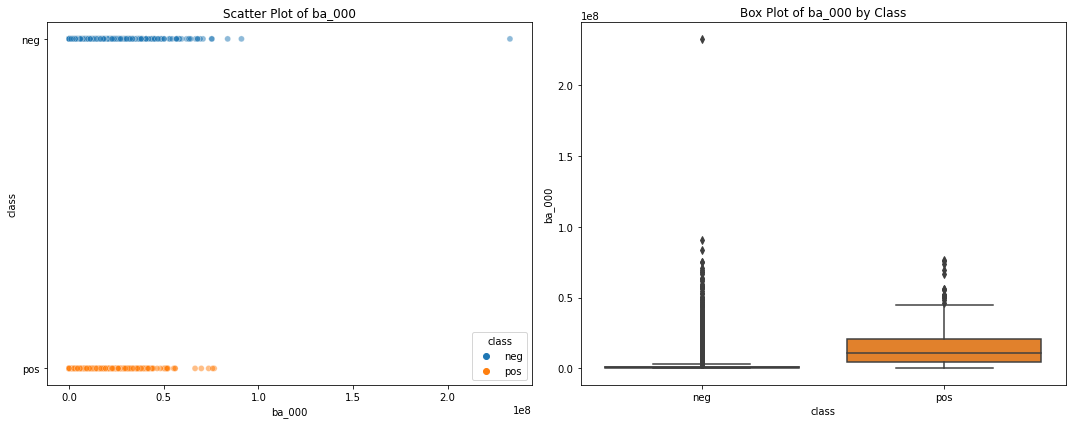

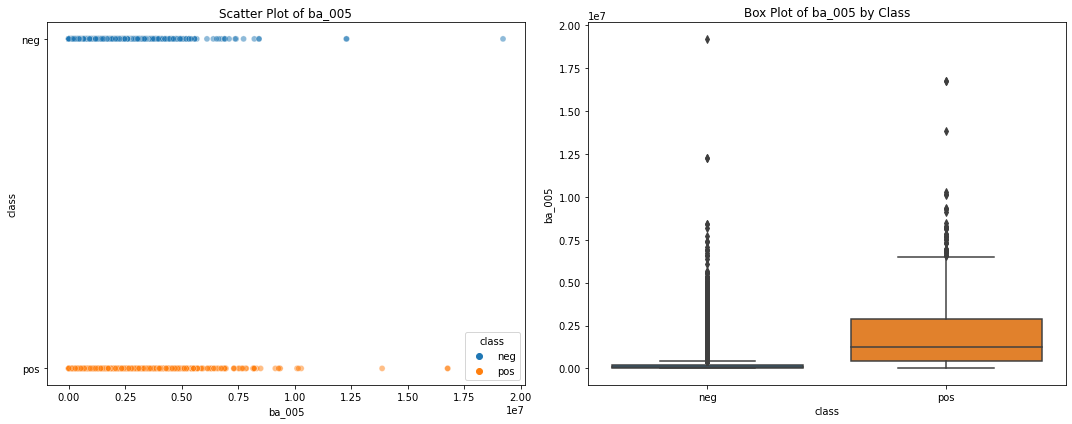

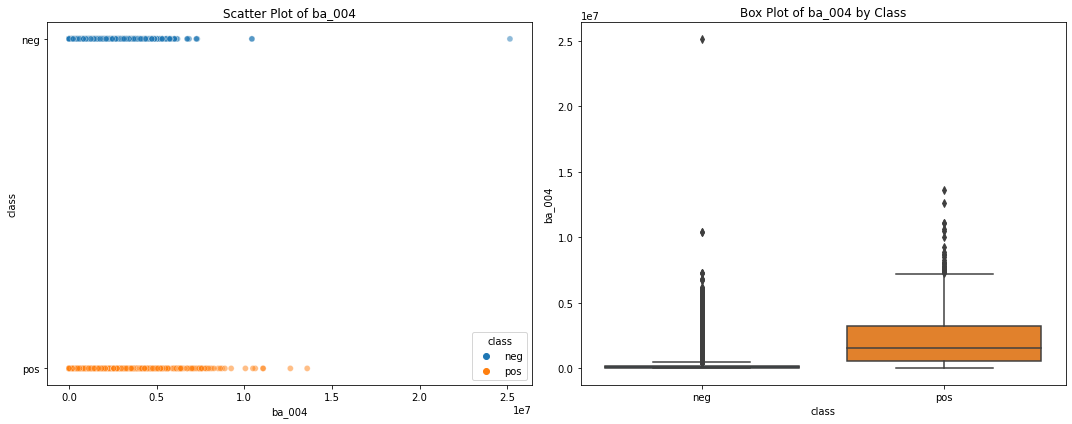

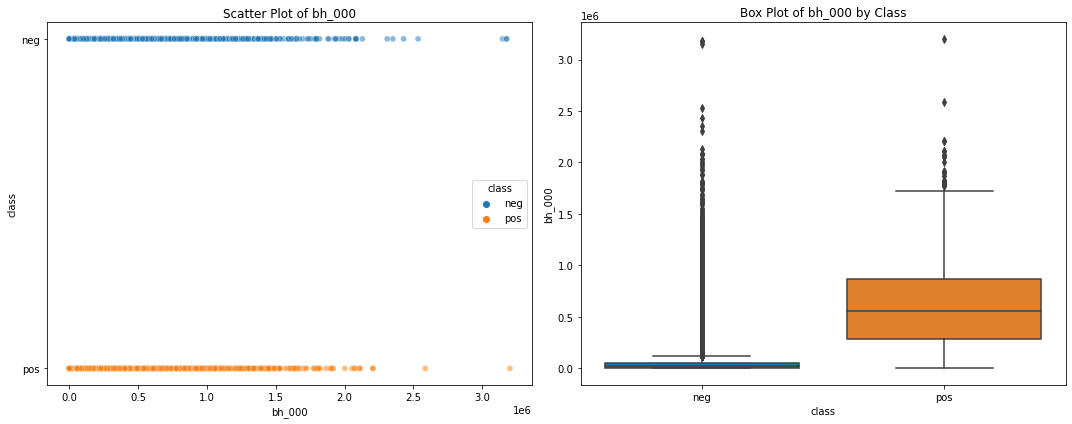

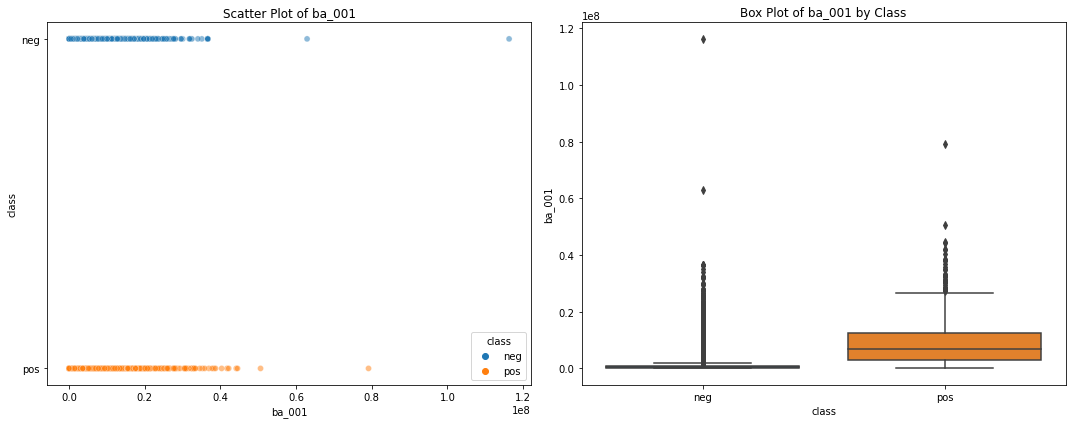

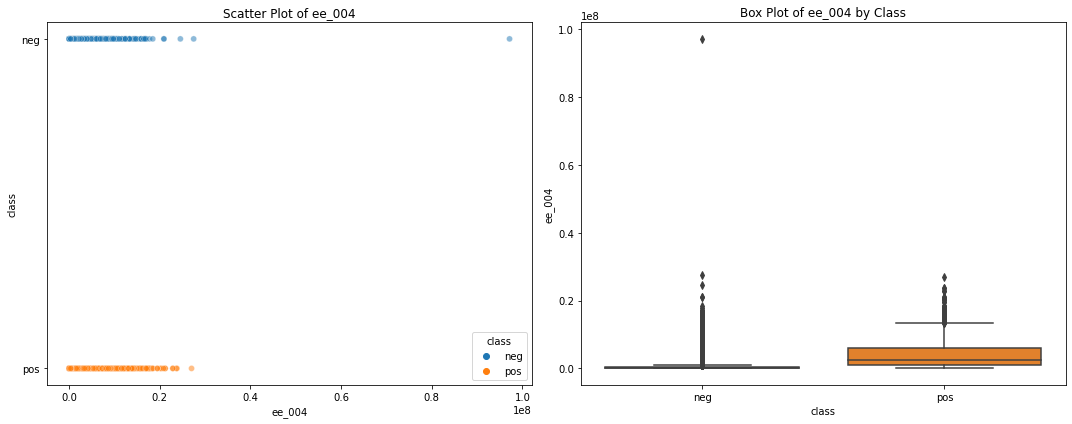

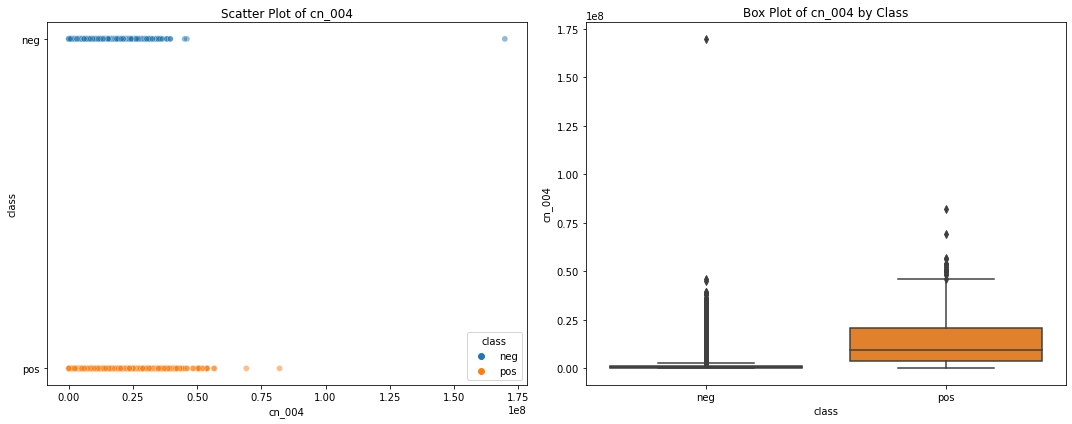

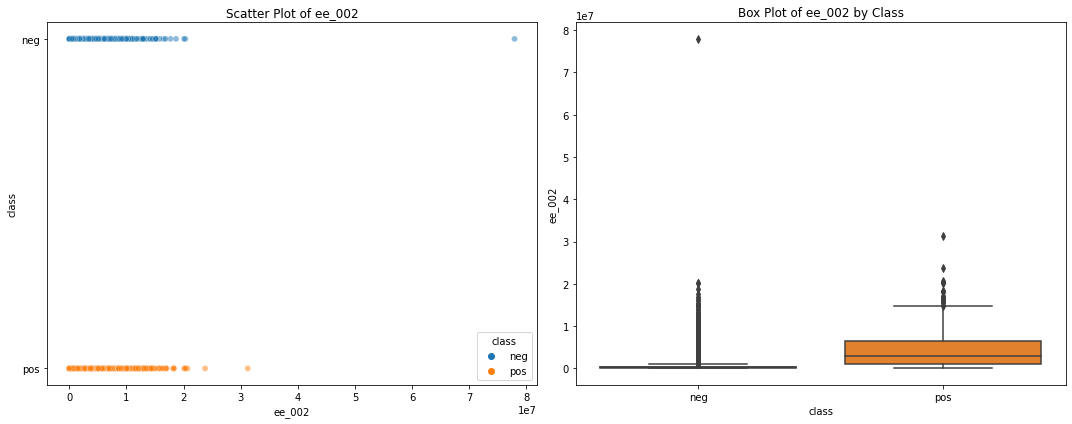

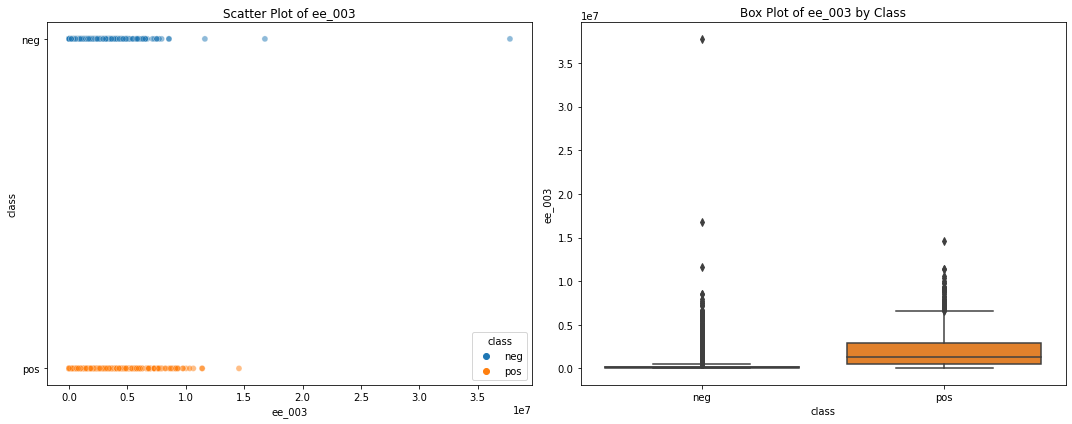

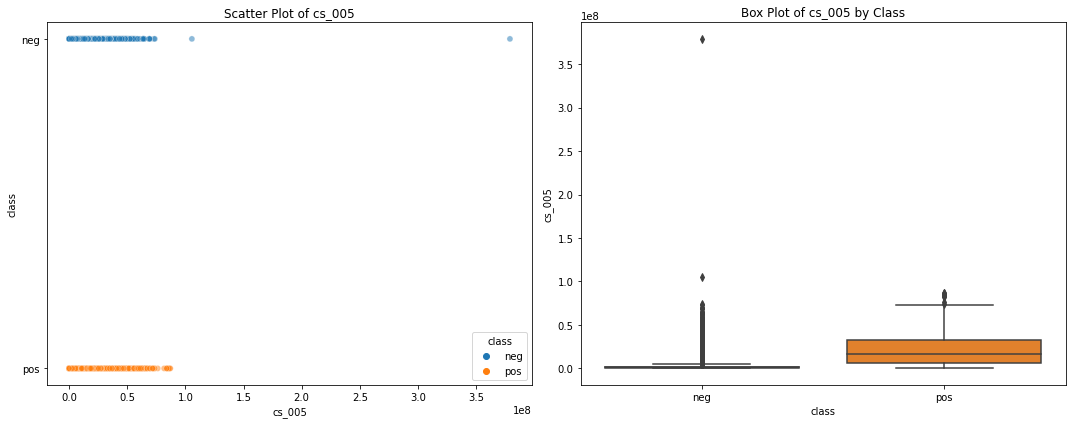

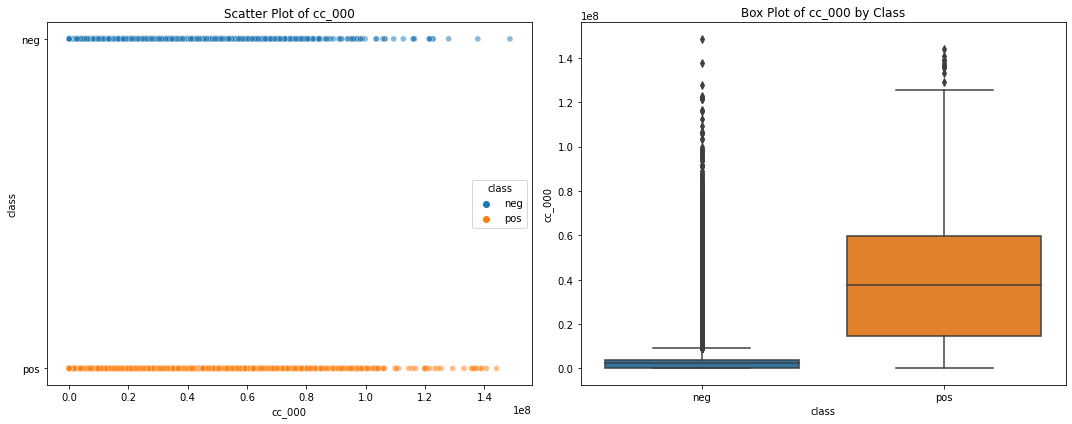

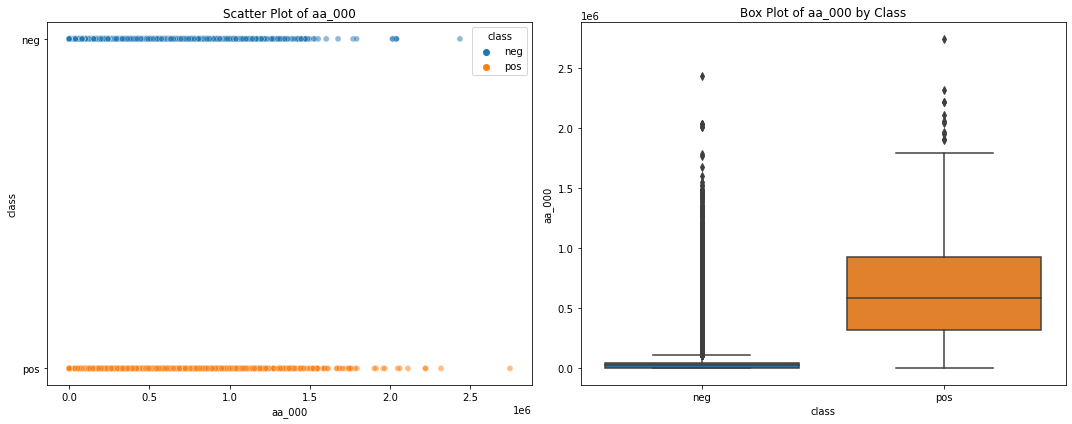

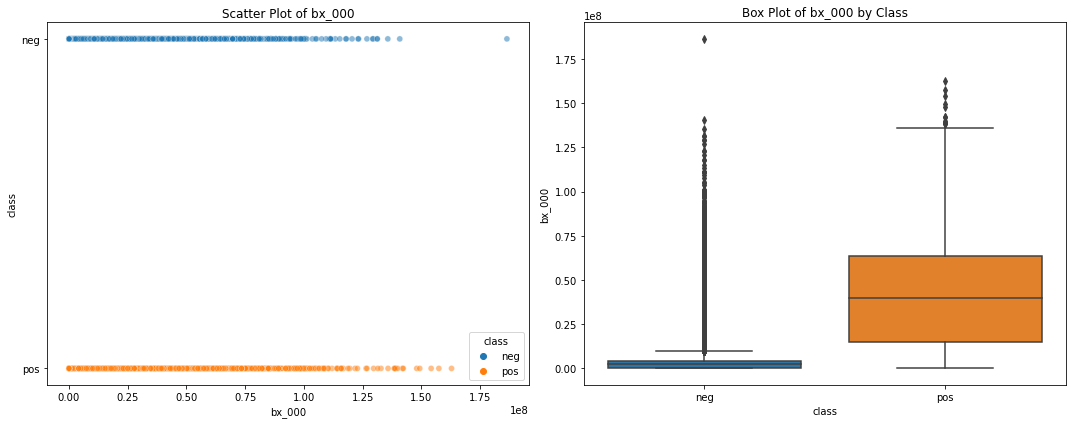

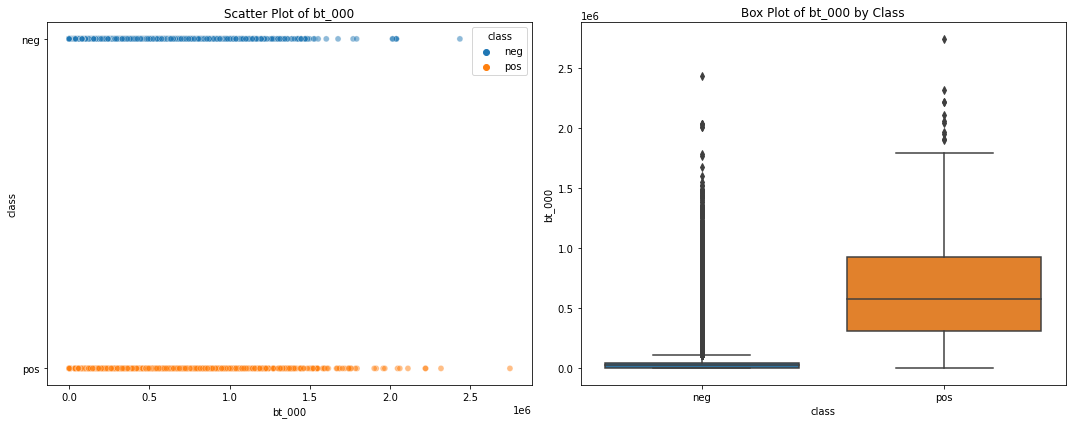

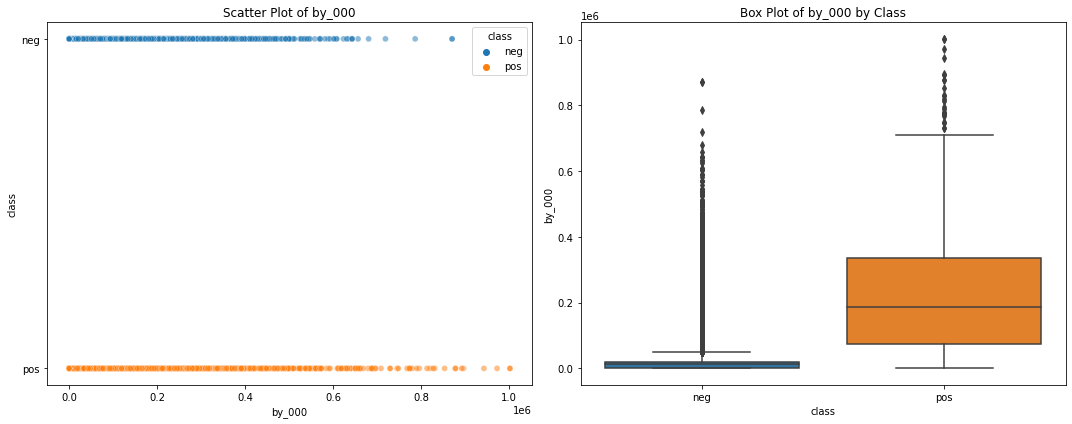

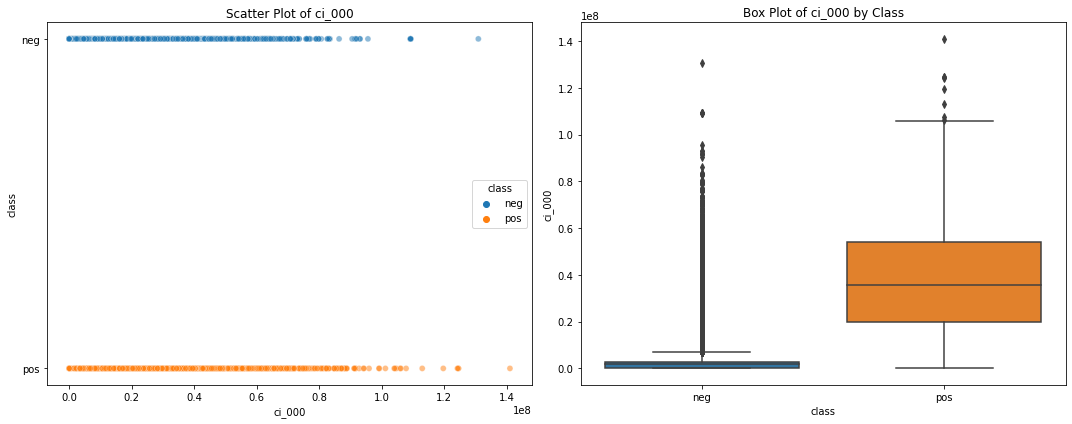

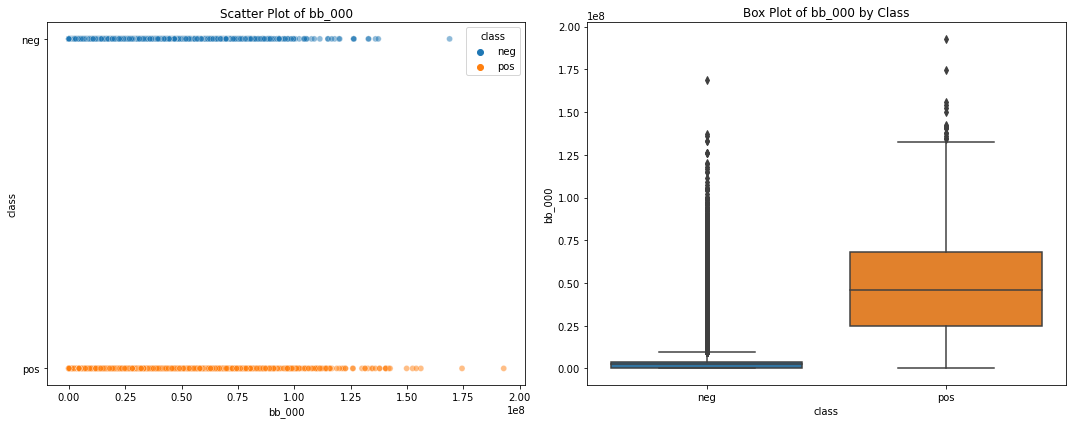

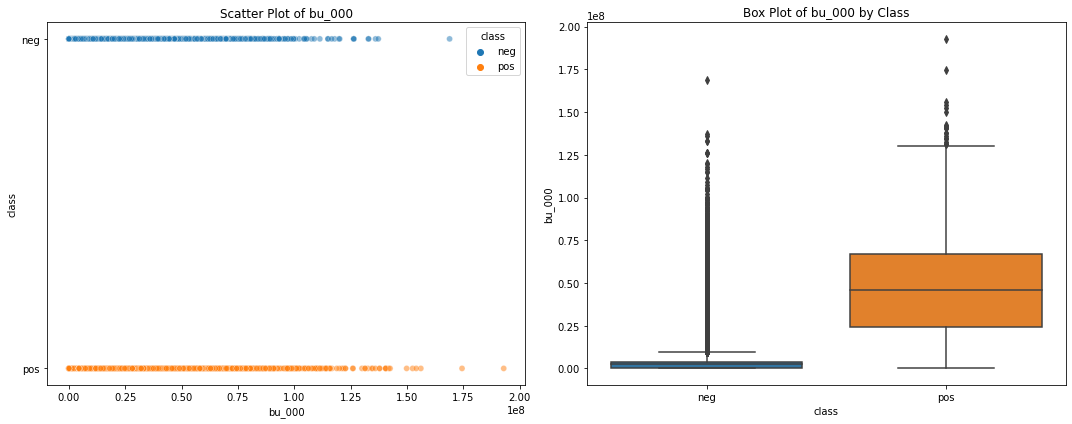

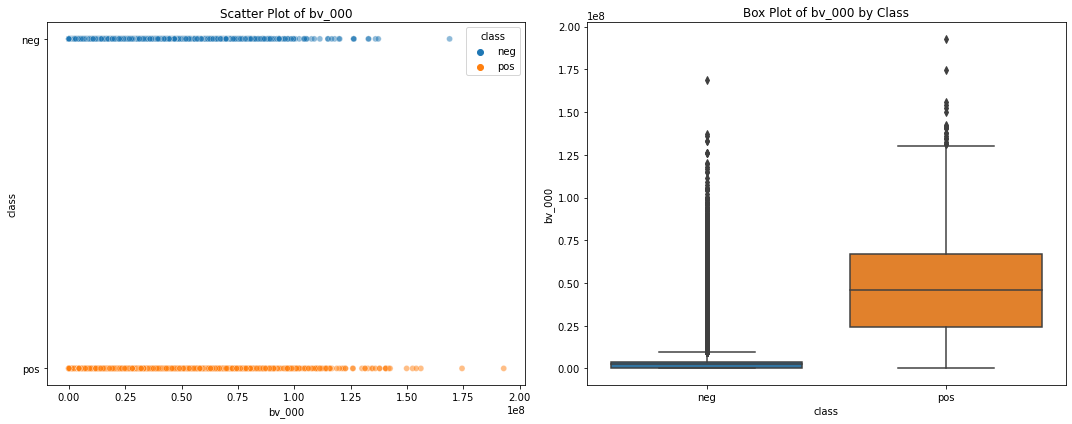

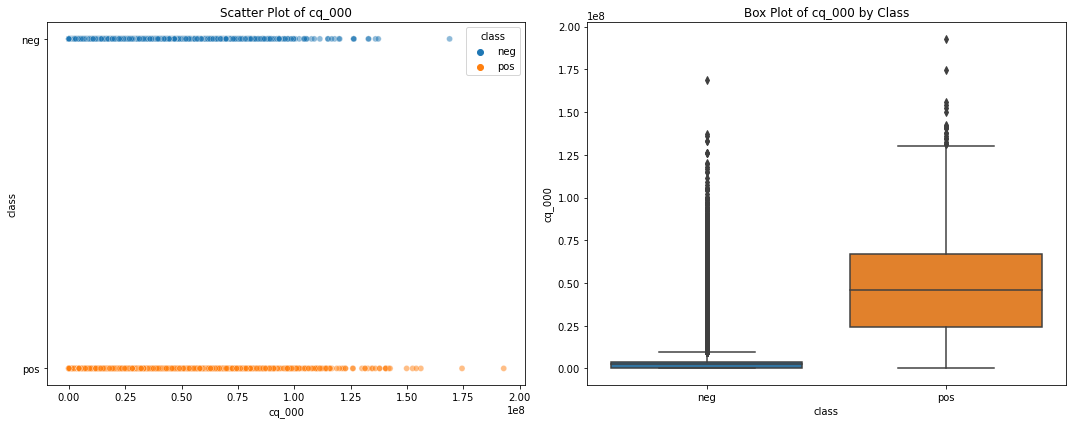

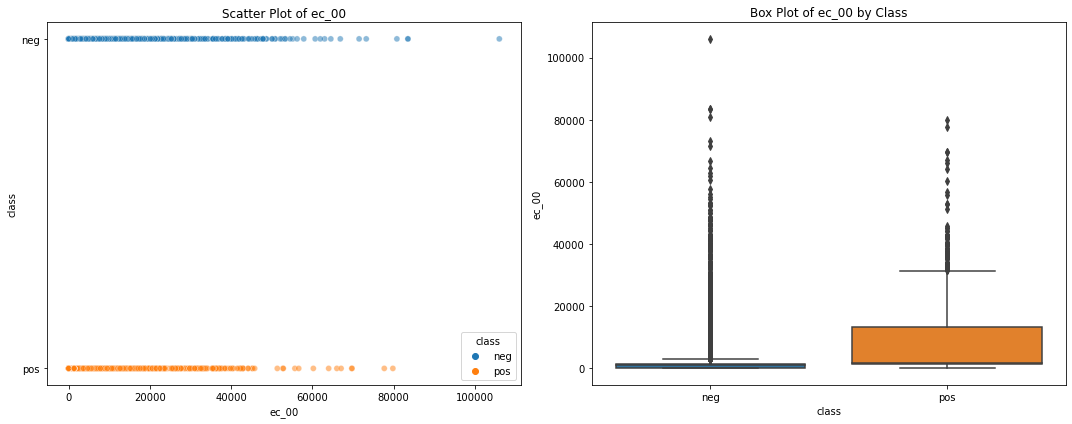

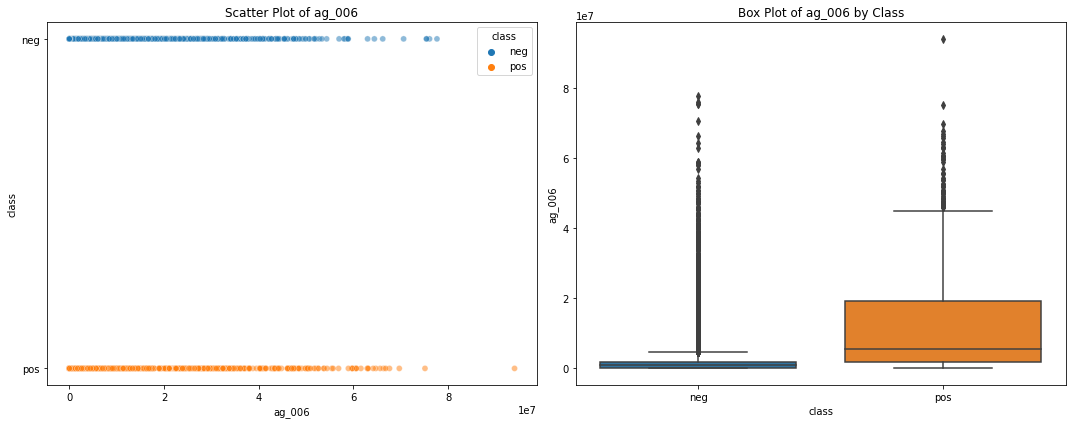

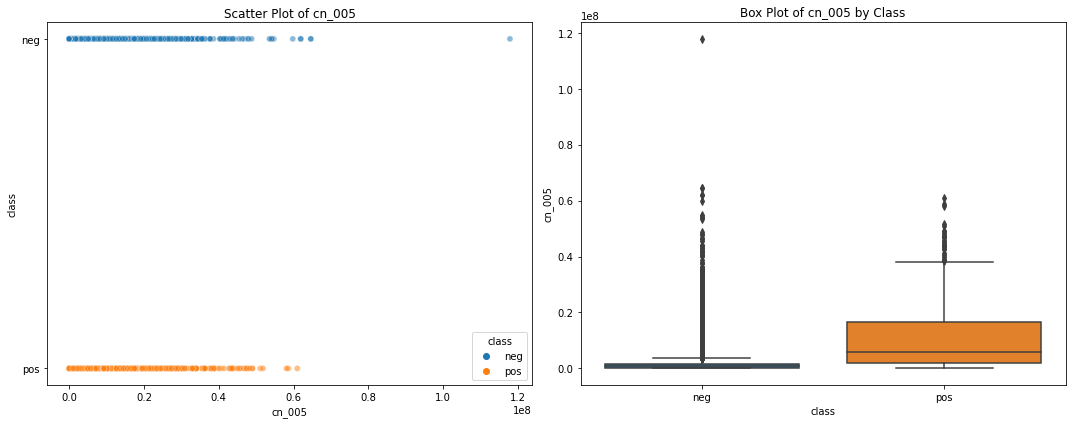

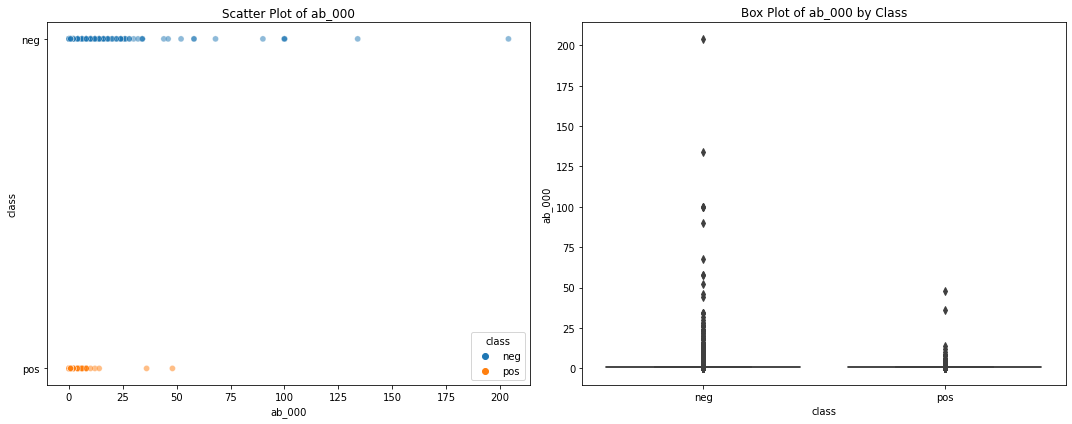

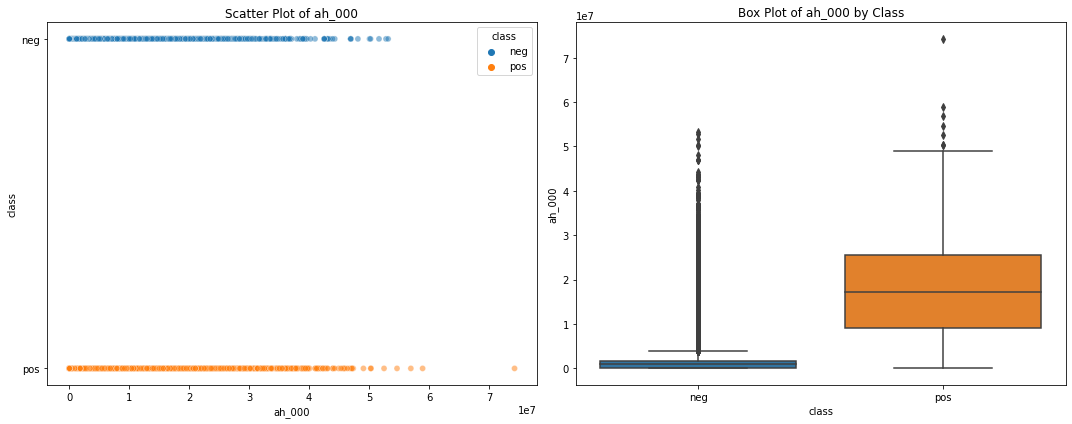

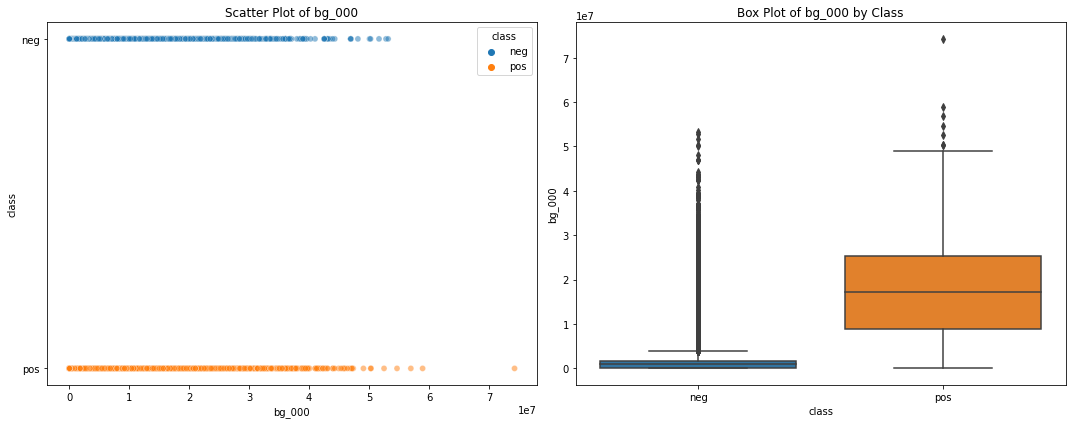

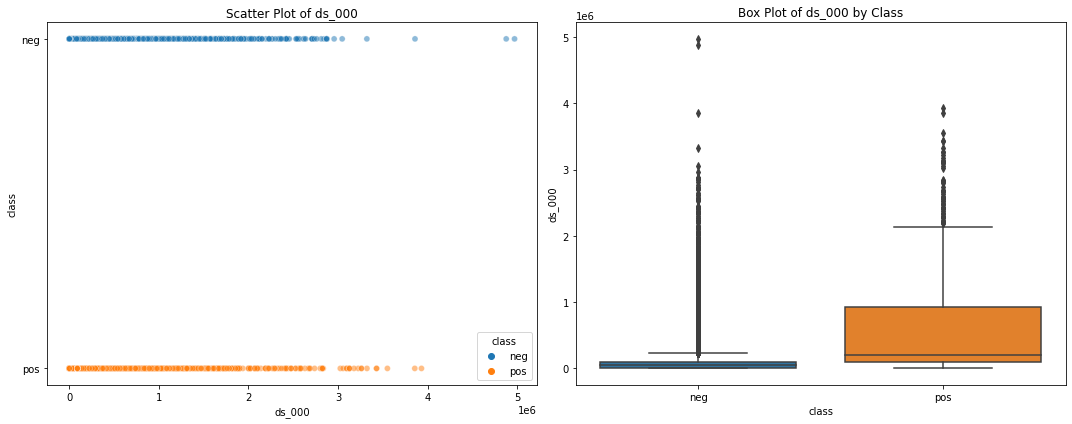

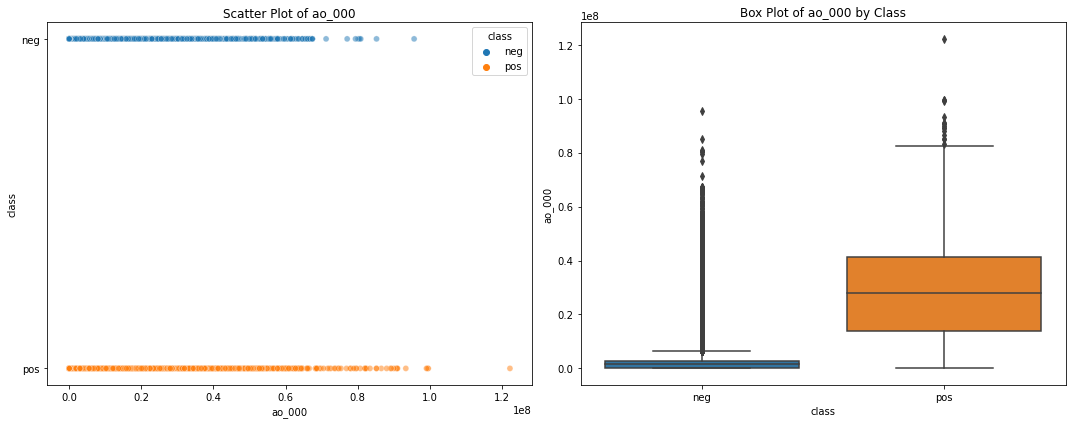

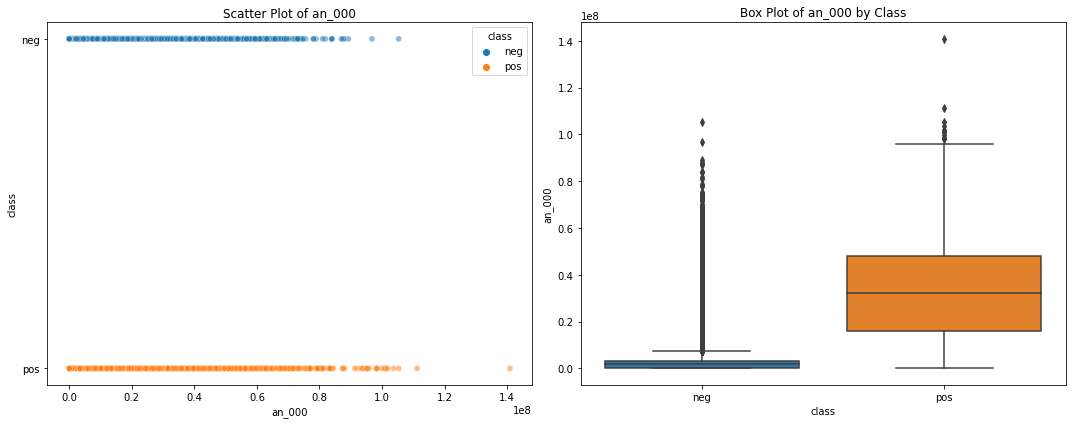

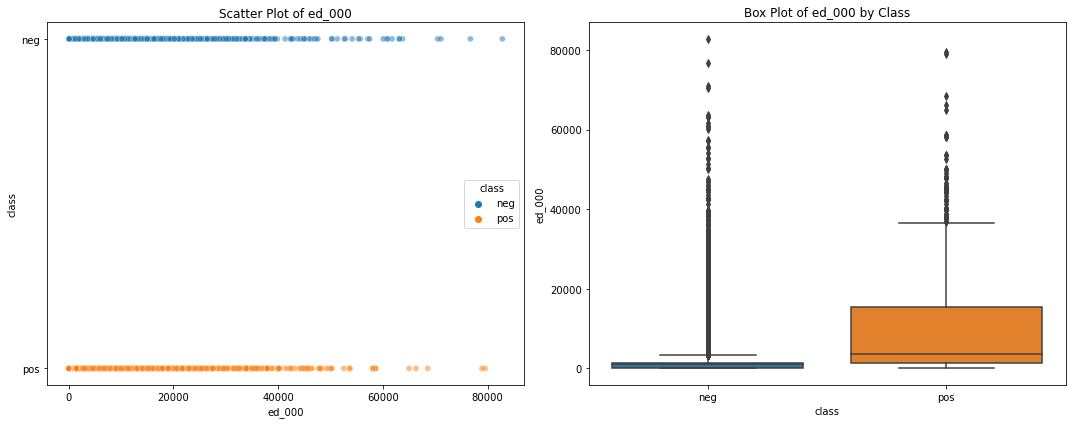

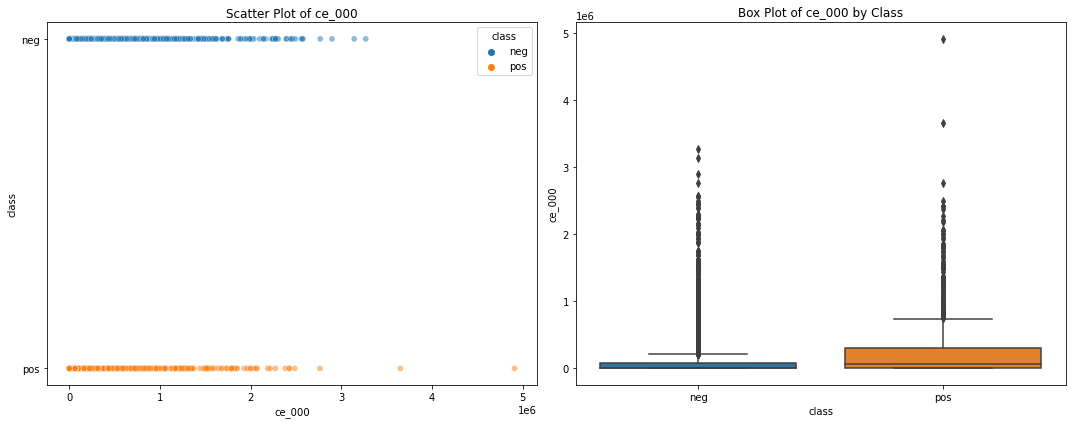

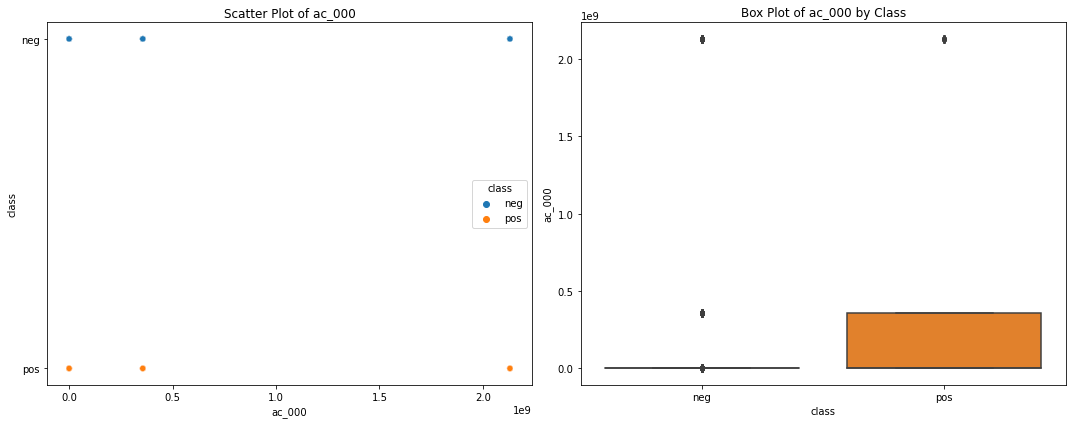

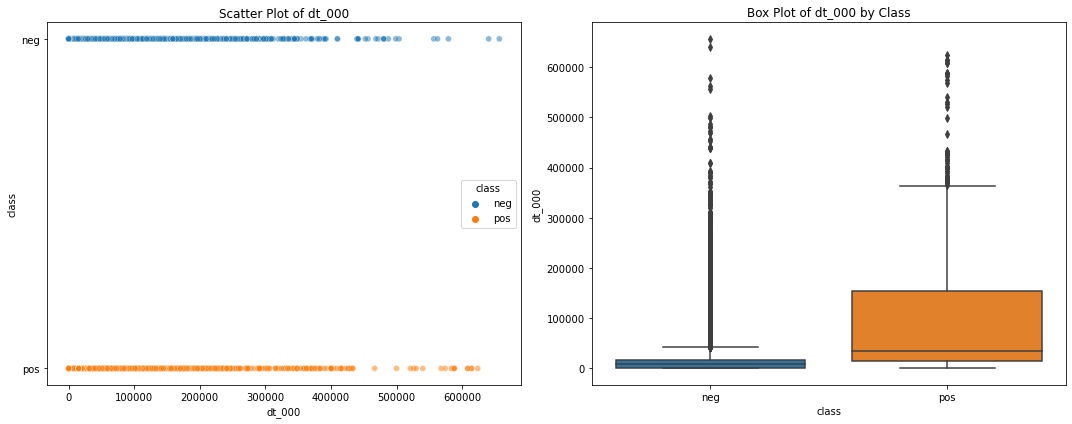

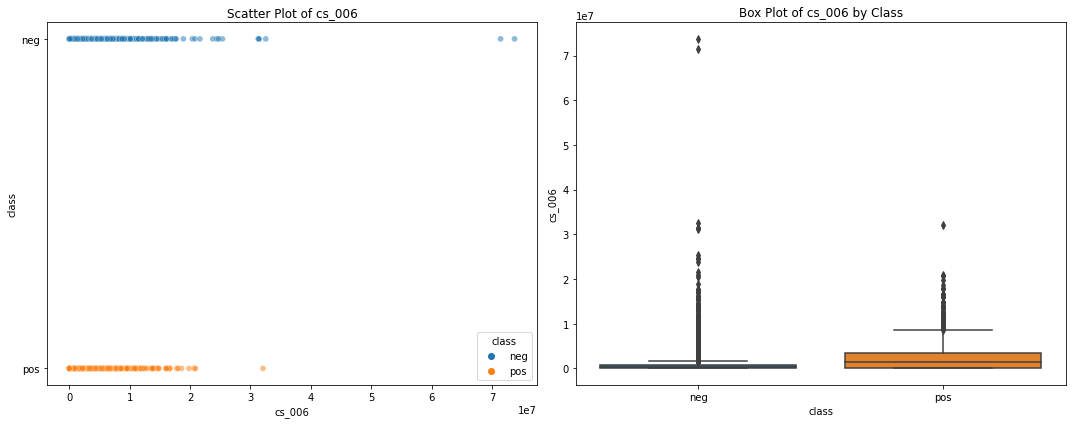

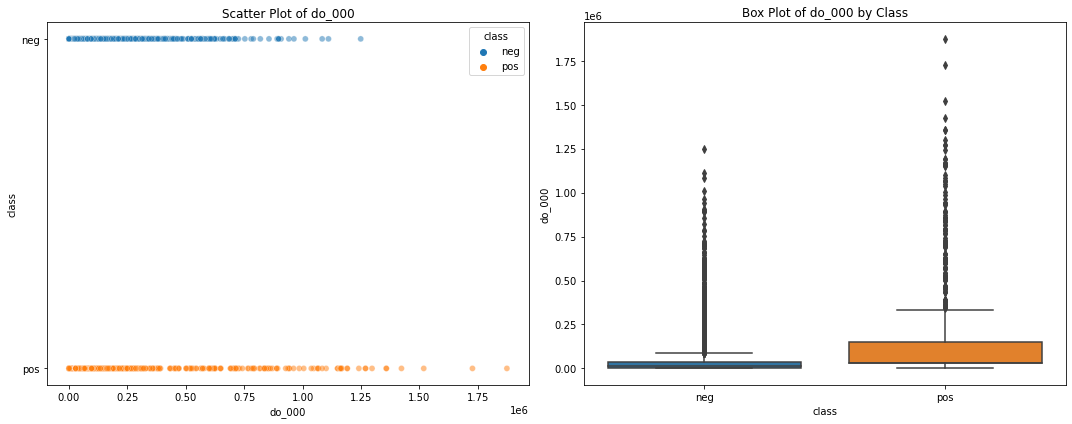

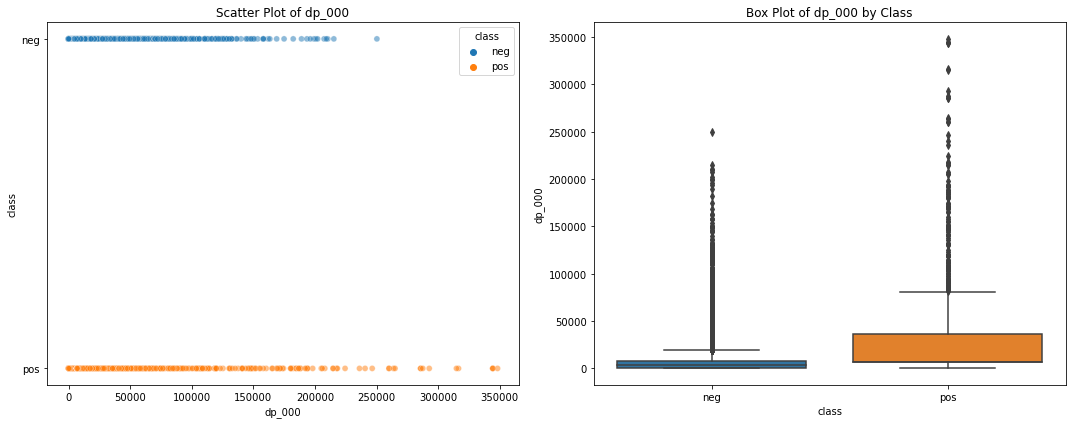

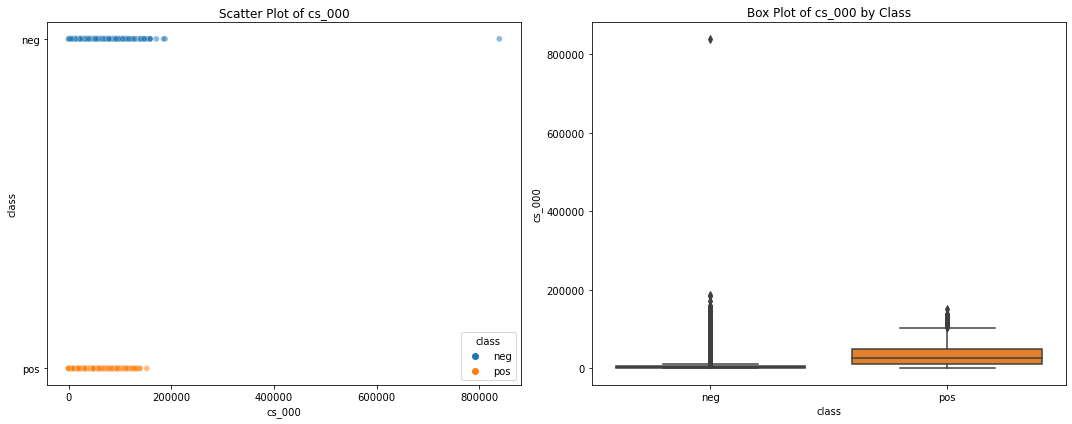

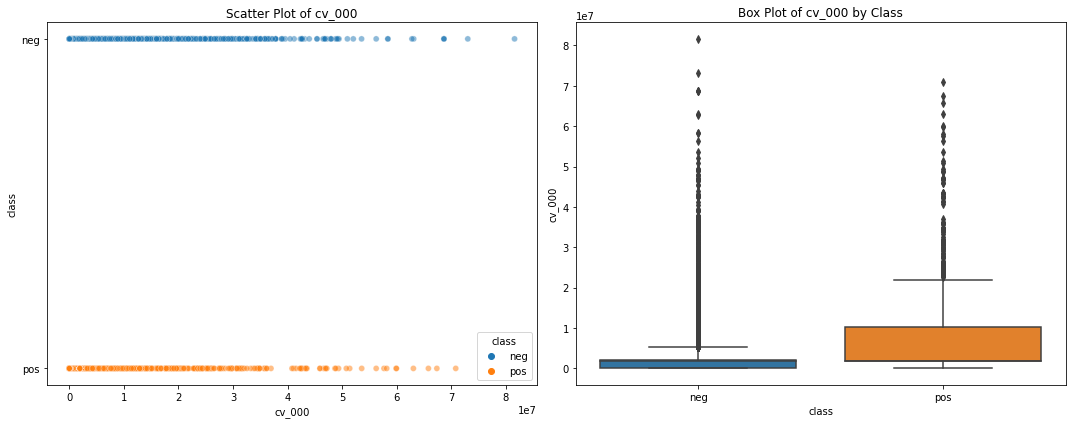

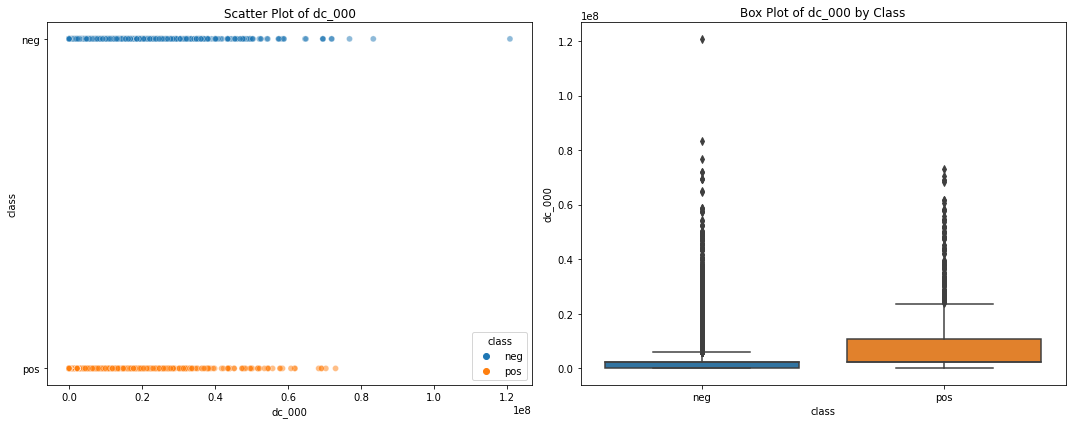

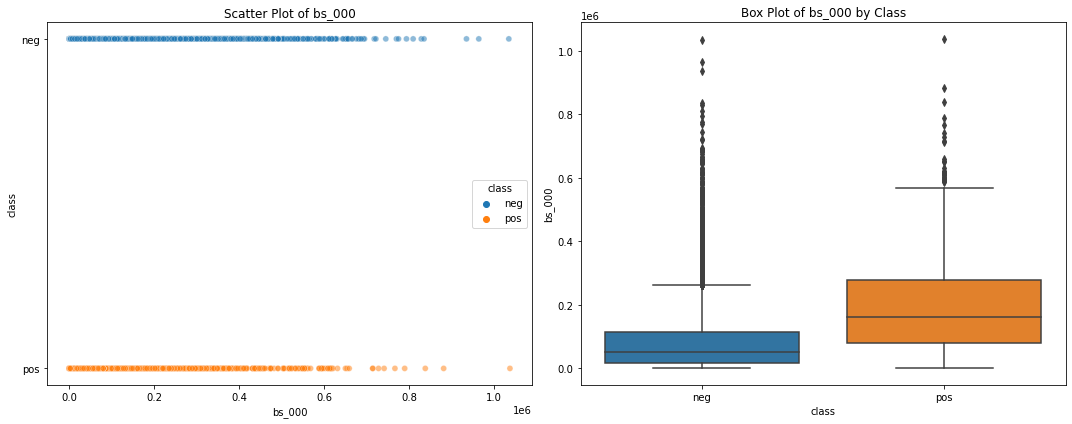

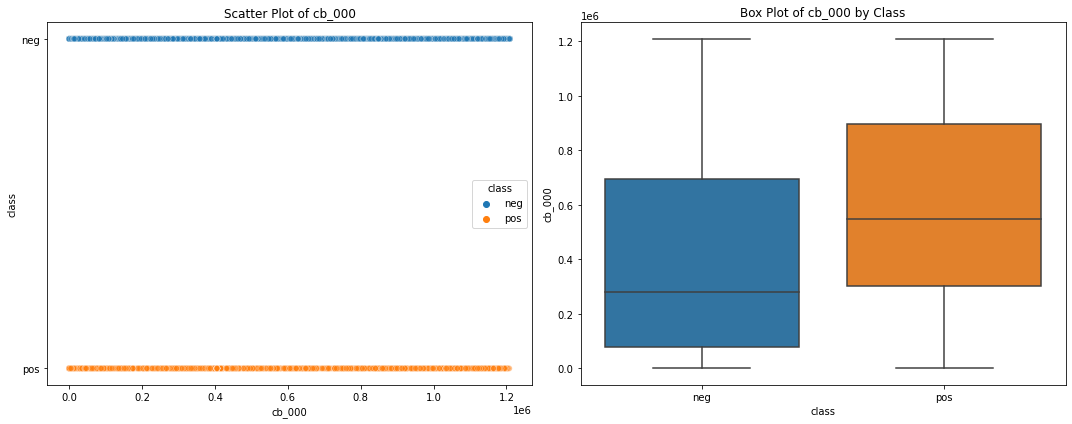

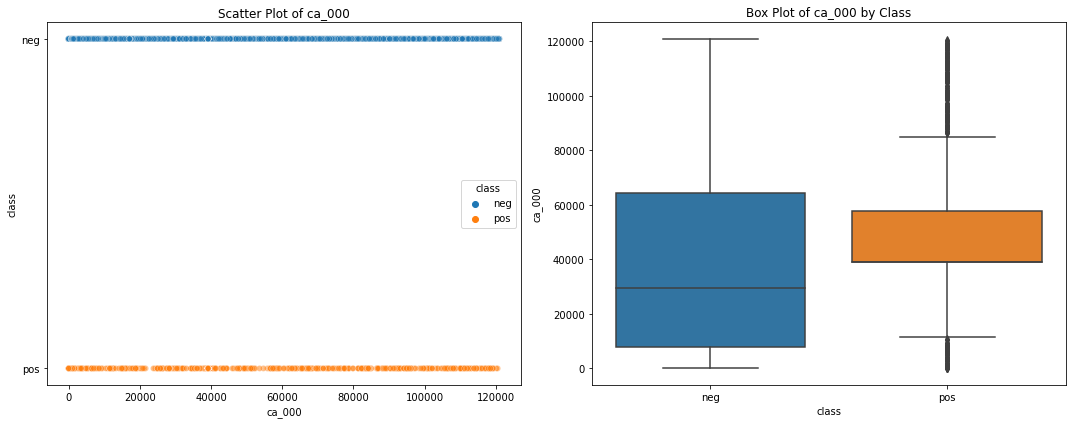

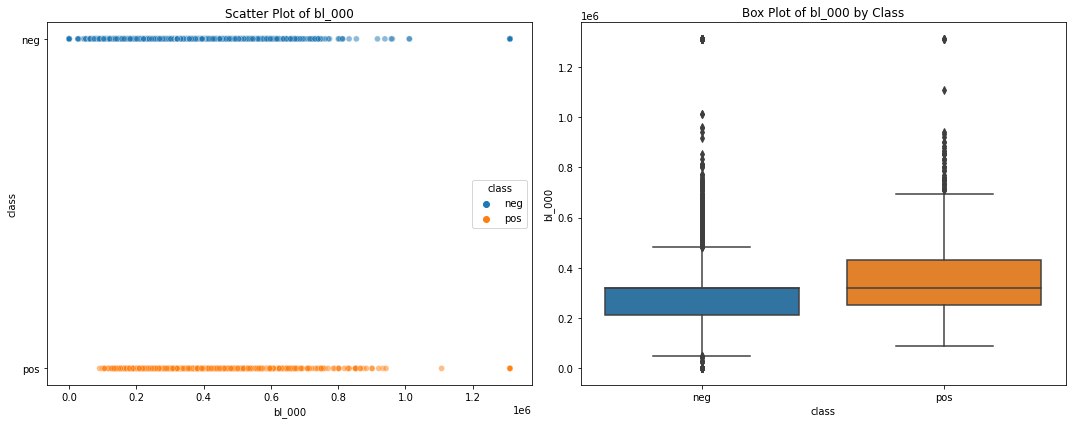

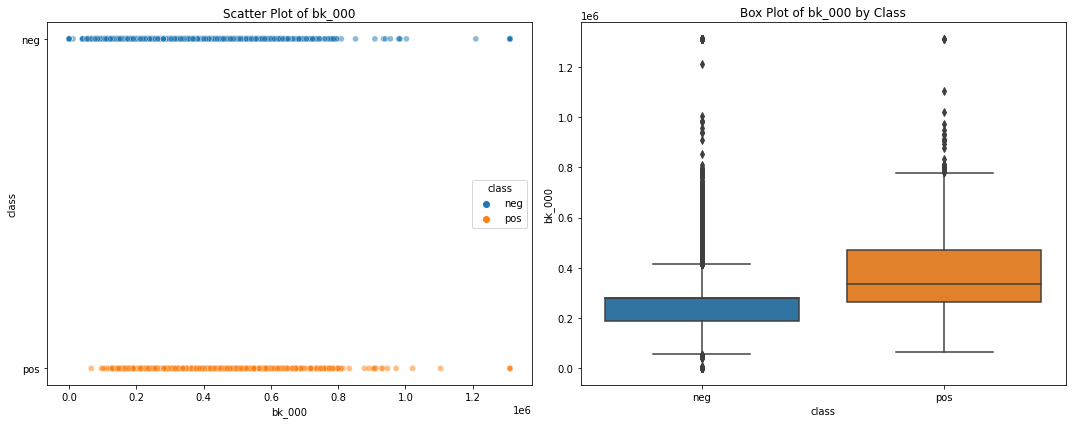

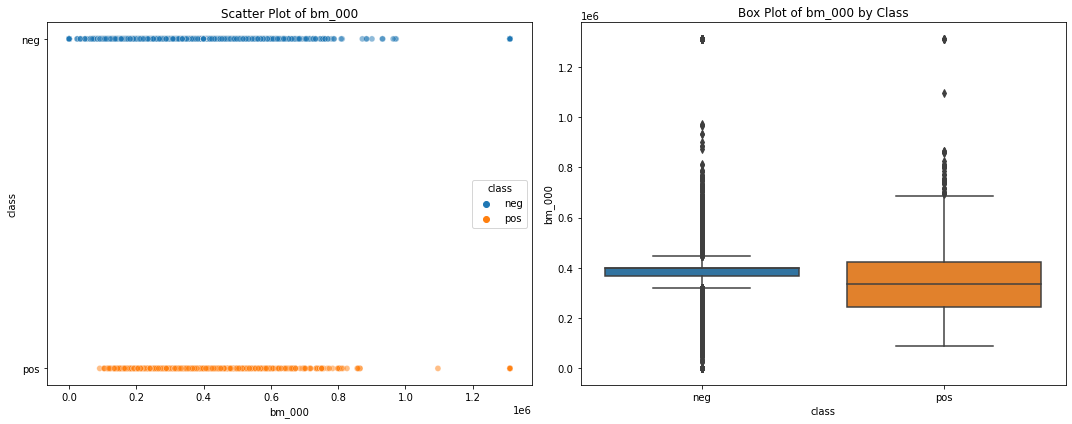

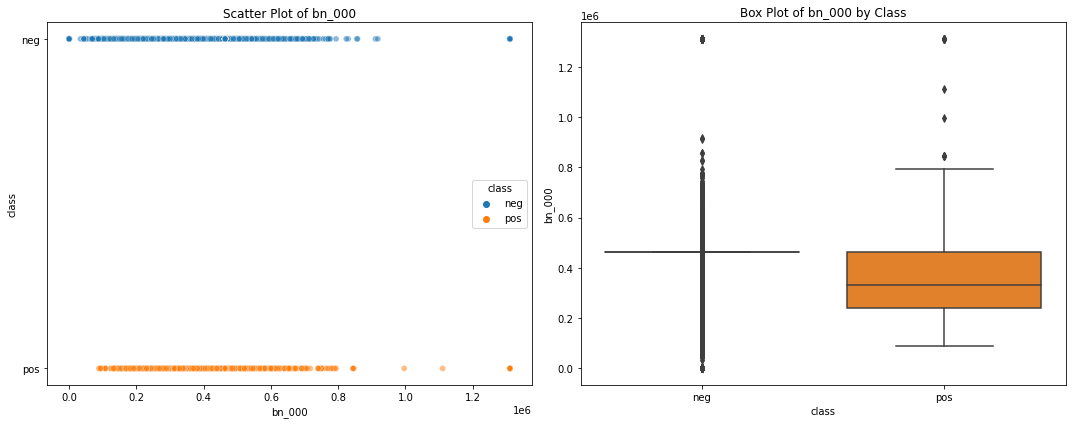

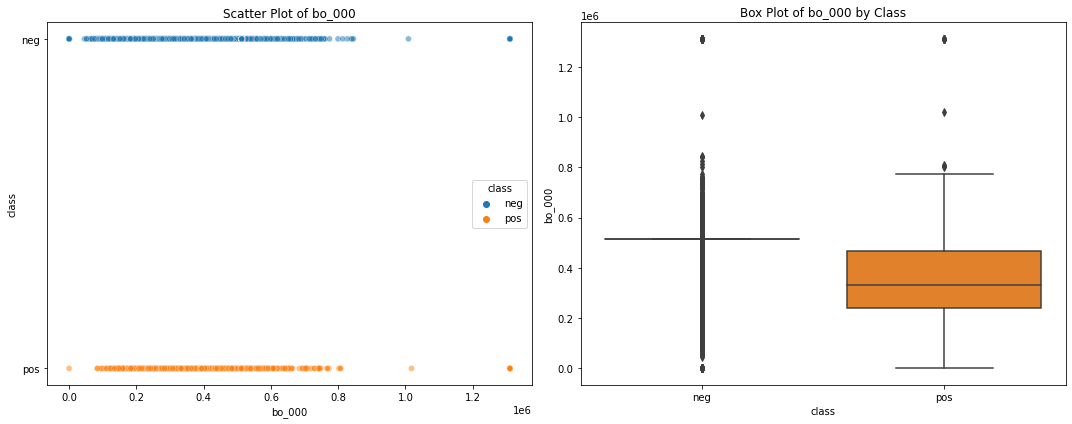

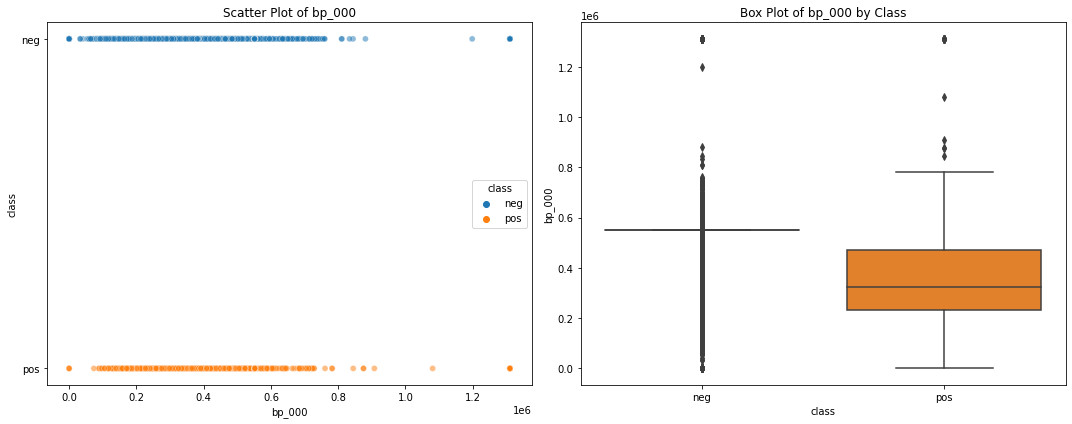

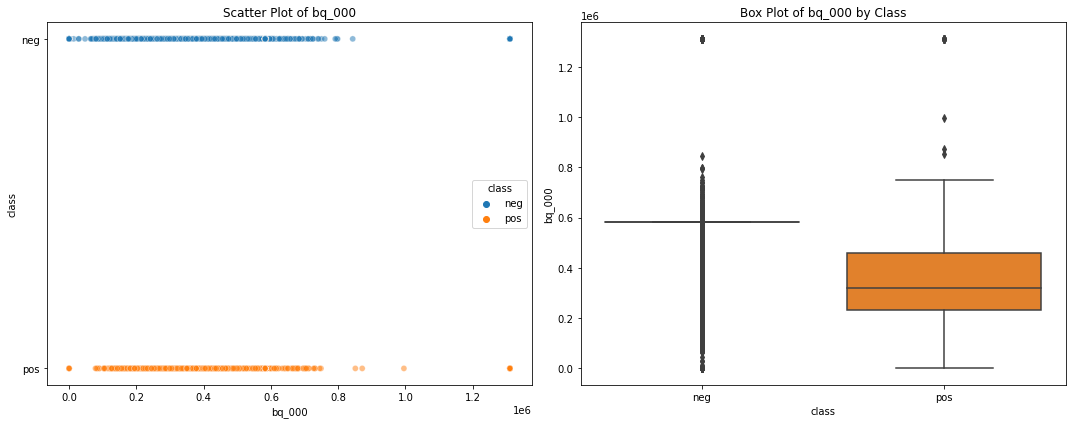

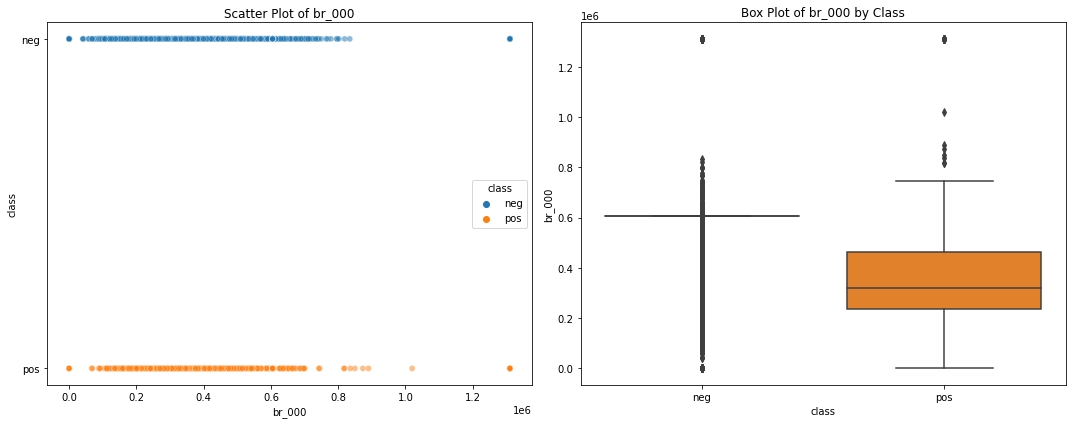

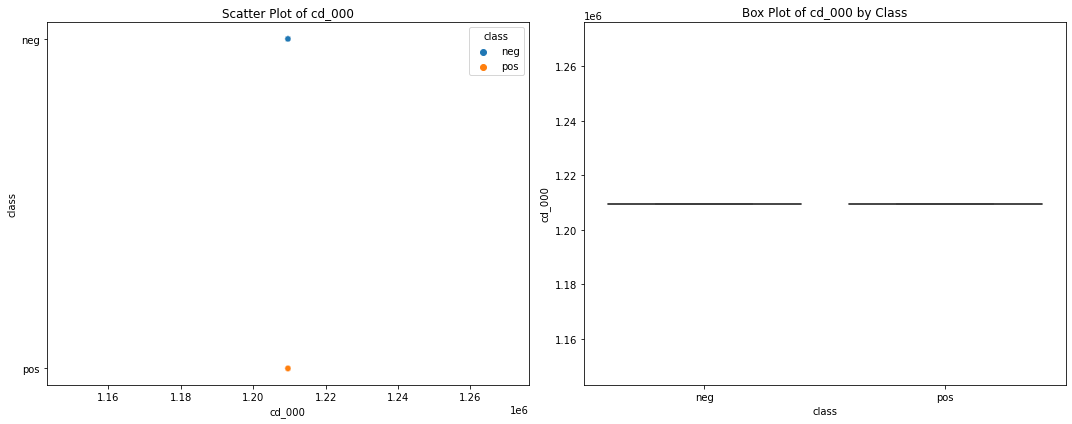

In [4]:
# Select the top floor(170) features
num_features = floor(170)
top_features = cv_values.head(num_features).index.tolist()

# Combined Scatter and Box plots
for feature in top_features:
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Scatter plot
    sns.scatterplot(x=feature, y='class', data=train_df, hue='class', alpha=0.5, ax=axes[0])
    axes[0].set_title(f'Scatter Plot of {feature}')
    
    # Box plot
    sns.boxplot(x='class', y=feature, data=train_df, ax=axes[1])
    axes[1].set_title(f'Box Plot of {feature} by Class')
    
    plt.tight_layout()
    plt.show()

### so you can't draw conclusion just looking at the scatter plot due to the following reason
From the scatter plots and box plots of the features with the highest CV:

Clear Separation: Features that show a distinct separation between classes in the scatter plots are potentially significant. A clear separation indicates that the feature might help distinguish between the classes effectively.

Spread and Variance: A broad spread in the data, as seen from both scatter plots and the box plots' interquartile ranges, may suggest that the feature carries varied information across data points. Features with higher variance can often be more informative.

Potential Outliers: Features with noticeable outliers might require further investigation. Outliers can impact the performance of certain algorithms, and understanding their origin (e.g., data errors, genuine rare occurrences) is crucial.

Relationships Between Features: If two features show a trend or pattern when plotted against each other, they might be correlated. While correlation doesn't imply causation, understanding these relationships can be crucial for feature engineering or selection, especially to avoid multicollinearity in some models.

Concentration of Data Points: Features where most data points are concentrated in specific regions, with only a few points outside, might be indicating categorical or binary data. The significance of such features would need further analysis, possibly backed by domain knowledge.



#### (v) Is this data set imbalanced?

In [5]:
# Count the number of positive and negative samples in the training data
class_counts = train_df['class'].value_counts()

# Print the counts
print(class_counts)

# Check for imbalance
if class_counts[0] / class_counts[1] > 2 or class_counts[1] / class_counts[0] > 2:
    print("The dataset is imbalanced.")
else:
    print("The dataset is balanced.")

neg    59000
pos     1000
Name: class, dtype: int64
The dataset is imbalanced.


### (c) Train a random forest

Training Confusion Matrix:
[[59000     0]
 [    1   999]]

Test Confusion Matrix:
[[15605    20]
 [  101   274]]


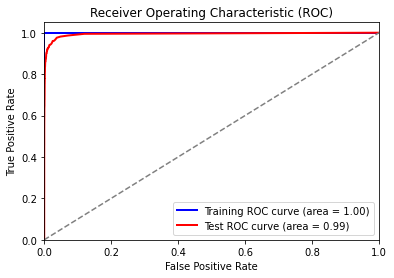

Training Misclassification Rate: 0.000
Test Misclassification Rate: 0.008
OOB Error: 0.006
Test Error: 0.008


In [6]:

# Split data into features and target
X_train = train_df.drop(columns=['class'])
y_train = train_df['class']

X_test = test_df.drop(columns=['class'])
y_test = test_df['class']

# Train a random forest classifier
clf = RandomForestClassifier(oob_score=True, random_state=42)  # Enable OOB scoring
clf.fit(X_train, y_train)

# Predict on training and test datasets
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

# Confusion matrices
print("Training Confusion Matrix:")
print(confusion_matrix(y_train, y_train_pred))

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

# ROC & AUC for Training data
fpr_train, tpr_train, _ = roc_curve(y_train, clf.predict_proba(X_train)[:,1], pos_label='pos')
roc_auc_train = auc(fpr_train, tpr_train)

# ROC & AUC for Test data
fpr_test, tpr_test, _ = roc_curve(y_test, clf.predict_proba(X_test)[:,1], pos_label='pos')
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure()
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label='Training ROC curve (area = %0.2f)' % roc_auc_train)
plt.plot(fpr_test, tpr_test, color='red', lw=2, label='Test ROC curve (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Misclassification rates
misclassification_train = 1 - accuracy_score(y_train, y_train_pred)
misclassification_test = 1 - accuracy_score(y_test, y_test_pred)
print(f"Training Misclassification Rate: {misclassification_train:.3f}")
print(f"Test Misclassification Rate: {misclassification_test:.3f}")

# OOB error
oob_error = 1 - clf.oob_score_
print(f"OOB Error: {oob_error:.3f}")

# Compare OOB error with test error
print(f"Test Error: {misclassification_test:.3f}")

### (d) Research class imbalance in random forest

In [7]:
# Split the data into features and target
X_train = train_df.drop(columns=['class'])
y_train = train_df['class']
X_test = test_df.drop(columns=['class'])
y_test = test_df['class']

# Initialize a Random Forest Classifier with class_weight set to 'balanced'
clf_balanced = RandomForestClassifier(oob_score=True, class_weight='balanced', random_state=42)

# Train the classifier on the training data
clf_balanced.fit(X_train, y_train)

# Predict on the training and test data
train_preds_balanced = clf_balanced.predict(X_train)
test_preds_balanced = clf_balanced.predict(X_test)

# Confusion matrices for training and test sets
train_confusion_balanced = confusion_matrix(y_train, train_preds_balanced)
test_confusion_balanced = confusion_matrix(y_test, test_preds_balanced)

# Misclassification rates
train_misclass_balanced = 1 - accuracy_score(y_train, train_preds_balanced)
test_misclass_balanced = 1 - accuracy_score(y_test, test_preds_balanced)

# Extract Out-Of-Bag error from the classifier
oob_error_balanced = 1 - clf_balanced.oob_score_

# Print results
print("Balanced Training Confusion Matrix:")
print(train_confusion_balanced)
print("\nBalanced Test Confusion Matrix:")
print(test_confusion_balanced)
print(f"Balanced Training Misclassification Rate: {train_misclass_balanced:.3f}")
print(f"Balanced Test Misclassification Rate: {test_misclass_balanced:.3f}")
print(f"Balanced OOB Error: {oob_error_balanced:.3f}")

Balanced Training Confusion Matrix:
[[59000     0]
 [    1   999]]

Balanced Test Confusion Matrix:
[[15612    13]
 [  171   204]]
Balanced Training Misclassification Rate: 0.000
Balanced Test Misclassification Rate: 0.011
Balanced OOB Error: 0.008


Comparison with the results from 1c:

The balanced model shows a slight degradation in performance on the test set compared to the non-balbalanced model.
While the overall misclassification rate and OOB error are higher for the balanced model, the true test lies in how the model identifies the minority class, which is the primary reason for balancing.
There's a decrease in the number of 'pos' instances misclassified as 'neg' in the balanced model (171 compared to 101 in the non-balanced model). This suggests that even though the overall performance is slightly degraded, the balanced model is potentially more reliable for identifying positive cases in imbalanced scenarios.
Conclusion:
Balancing can sometimes lead to a trade-off. In this case, the overall accuracy slightly decreased, but the model became more sensitive to the minority class. Depending on the context, this could be more valuable, especially in cases where failing to identify a 'pos' instance could have severe consequences.

### (e) XGBoost and Model Trees

Training Confusion Matrix:
[[59000     0]
 [    1   999]]

Test Confusion Matrix:
[[15609    16]
 [   82   293]]

Training AUC Score: 0.9999899999999999
Test AUC Score: 0.9946972159999999


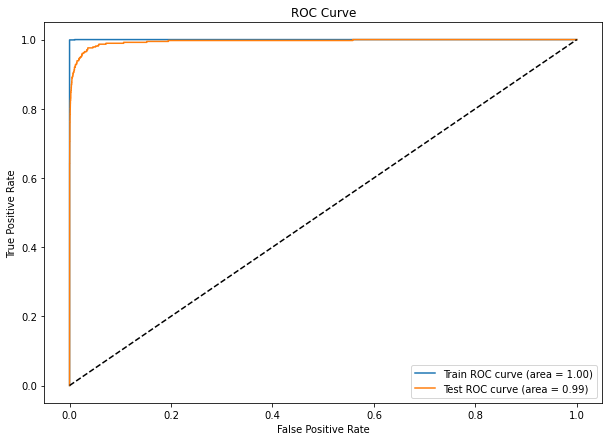

In [8]:
# Define X and y for training data
X_train = train_df.drop(columns=['class'])
y_train = train_df['class'].map({'neg': 0, 'pos': 1})

# Define X and y for testing data
X_test = test_df.drop(columns=['class'])
y_test = test_df['class'].map({'neg': 0, 'pos': 1})

# Create a DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define XGBoost parameters
params = {
    'max_depth': 6,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'alpha': 1  # L1 regularization term on weight (analogous to Lasso regression)
}
num_round = 100

# Train the XGBoost model
bst = xgb.train(params, dtrain, num_round)

# Predictions
train_preds_prob = bst.predict(dtrain)
test_preds_prob = bst.predict(dtest)

# Convert probabilities to class labels
train_preds = [1 if prob > 0.5 else 0 for prob in train_preds_prob]
test_preds = [1 if prob > 0.5 else 0 for prob in test_preds_prob]

# Confusion matrices
print("Training Confusion Matrix:")
print(confusion_matrix(y_train, train_preds))
print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, test_preds))

# AUC scores
print("\nTraining AUC Score:", roc_auc_score(y_train, train_preds_prob))
print("Test AUC Score:", roc_auc_score(y_test, test_preds_prob))

# ROC Curve for training set
fpr, tpr, thresholds = roc_curve(y_train, train_preds_prob)
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label='Train ROC curve (area = %0.2f)' % roc_auc_score(y_train, train_preds_prob))

# ROC Curve for test set
fpr, tpr, thresholds = roc_curve(y_test, test_preds_prob)
plt.plot(fpr, tpr, label='Test ROC curve (area = %0.2f)' % roc_auc_score(y_test, test_preds_prob))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

### (f) Use SMOTE to pre-process your data

Training Confusion Matrix (SMOTE):
[[47048     0]
 [    1 47351]]

Test Confusion Matrix (SMOTE):
[[15394   231]
 [   49   326]]

Training AUC Score (SMOTE): 1.0
Test AUC Score (SMOTE): 0.99028224


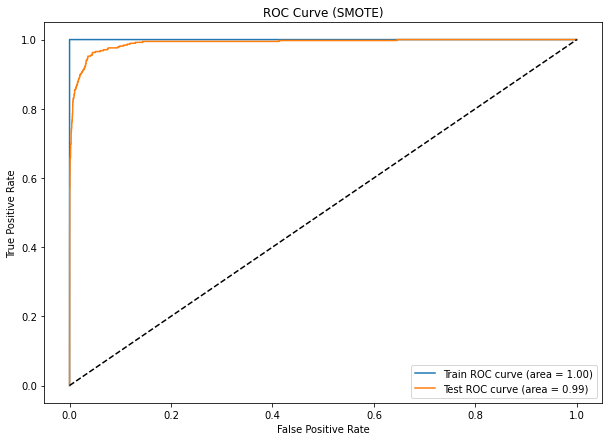

In [9]:
# Define X and y for training data
X = train_df.drop(columns=['class'])
y = train_df['class'].map({'neg': 0, 'pos': 1})

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

# Split the data into training and validation sets
X_train_smote, X_val_smote, y_train_smote, y_val_smote = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

# Create a DMatrix for XGBoost
dtrain_smote = xgb.DMatrix(X_train_smote, label=y_train_smote)
dval_smote = xgb.DMatrix(X_val_smote, label=y_val_smote)
dtest = xgb.DMatrix(X_test, label=y_test)  # using the original test set

# Define XGBoost parameters
params = {
    'max_depth': 6,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'alpha': 1
}
num_round = 100

# Train the XGBoost model
bst_smote = xgb.train(params, dtrain_smote, num_round, evals=[(dval_smote, 'val')], early_stopping_rounds=10, verbose_eval=False)

# Predictions
train_preds_prob_smote = bst_smote.predict(dtrain_smote)
test_preds_prob_smote = bst_smote.predict(dtest)

# Convert probabilities to class labels
train_preds_smote = [1 if prob > 0.5 else 0 for prob in train_preds_prob_smote]
test_preds_smote = [1 if prob > 0.5 else 0 for prob in test_preds_prob_smote]

# Confusion matrices
print("Training Confusion Matrix (SMOTE):")
print(confusion_matrix(y_train_smote, train_preds_smote))
print("\nTest Confusion Matrix (SMOTE):")
print(confusion_matrix(y_test, test_preds_smote))

# AUC scores
print("\nTraining AUC Score (SMOTE):", roc_auc_score(y_train_smote, train_preds_prob_smote))
print("Test AUC Score (SMOTE):", roc_auc_score(y_test, test_preds_prob_smote))

# ROC Curve for training set
fpr, tpr, thresholds = roc_curve(y_train_smote, train_preds_prob_smote)
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label='Train ROC curve (area = %0.2f)' % roc_auc_score(y_train_smote, train_preds_prob_smote))

# ROC Curve for test set
fpr, tpr, thresholds = roc_curve(y_test, test_preds_prob_smote)
plt.plot(fpr, tpr, label='Test ROC curve (area = %0.2f)' % roc_auc_score(y_test, test_preds_prob_smote))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (SMOTE)')
plt.legend(loc="lower right")
plt.show()

(a) As we increase s from 0, the training RSS will: iv. Steadily decrease.
(b) For test RSS: ii. Decrease initially, and then eventually start increasing in a U shape.
(c) For variance: iii. Steadily increase.
(d) For (squared) bias:iv. Steadily decrease.
(e) For the irreducible error:v. Remain constant.

**Given:**
\begin{align*}
n &= 2 \\
\hat{\beta}_0 &= 0 \\
p &= 2 \\
x_{11} &= x_{12} \\
x_{21} &= x_{22} = 0 \\
y_1 + y_2 &= 0
\end{align*}

**(a)** The ridge regression optimization problem is:
$$
\text{Minimize} \ \sum_{i=1}^{n} \left( y_i - \beta_0 - \sum_{j=1}^{p} \beta_j x_{ij} \right)^2 + \lambda \sum_{j=1}^{p} \beta_j^2
$$
Given the constraints and knowing \( \beta_0 \) is 0, this becomes:
$$
\text{Minimize} \ \left( y_1 - \beta_1 x_{11} - \beta_2 x_{12} \right)^2 + \left( y_2 - \beta_1 x_{21} - \beta_2 x_{22} \right)^2 + \lambda (\beta_1^2 + \beta_2^2)
$$

**(b)** For ridge regression: Given that \( x_{11} = x_{12} \) and \( x_{21} = x_{22} \), the penalty will be symmetrical for \( \beta_1 \) and \( \beta_2 \) because of the squared penalty term. This symmetry, combined with the constraints, means \( \hat{\beta}_1 \) and \( \hat{\beta}_2 \) will be the same in order to minimize the problem. Hence, \( \hat{\beta}_1 = \hat{\beta}_2 \).

**(c)** The lasso optimization problem is:
$$
\text{Minimize} \ \sum_{i=1}^{n} \left( y_i - \beta_0 - \sum_{j=1}^{p} \beta_j x_{ij} \right)^2 + \lambda \sum_{j=1}^{p} | \beta_j |
$$
With the constraints and \( \beta_0 = 0 \), this is:
$$
\text{Minimize} \ \left( y_1 - \beta_1 x_{11} - \beta_2 x_{12} \right)^2 + \left( y_2 - \beta_1 x_{21} - \beta_2 x_{22} \right)^2 + \lambda (| \beta_1 | + | \beta_2 |)
$$

**(d)** For lasso: Given \( x_{11} = x_{12} \) and \( x_{21} = x_{22} \), it's possible to transfer weight between \( \beta_1 \) and \( \beta_2 \) without affecting the loss due to the absolute penalty. This means multiple \( \beta_1 \) and \( \beta_2 \) combinations can have the same minimum loss, making them non-unique. The solutions range from \( \beta_1 \) having full value with \( \beta_2 = 0 \) to \( \beta_2 \) having full value with \( \beta_1 = 0 \), and any combination in between.

\begin{align*}
\textbf{Given Probabilities:} & \quad 0.1, 0.15, 0.2, 0.2, 0.55, 0.6, 0.6, 0.65, 0.7, 0.75 \\
\\
\textbf{1. Majority Vote Approach:} \\
\text{Predictions based on the given probabilities:} & \quad \text{Green, Green, Green, Green, Red, Red, Red, Red, Red, and Red} \\
\text{There are 4 predictions for "Green" and 6 predictions for "Red".} \\
\textbf{Final Classification (Majority Vote):} & \quad \text{Red} \\
\\
\textbf{2. Average Probability Approach:} \\
\text{Average probability} & = \frac{0.1 + 0.15 + 0.2 + 0.2 + 0.55 + 0.6 + 0.6 + 0.65 + 0.7 + 0.75}{10} \\
\text{Average probability} & = \frac{4.35}{10} \\
\text{Average probability} & = 0.435 \\
\text{Since 0.435 is less than 0.5,} \\
\textbf{Final Classification (Average Probability):} & \quad \text{Green}
\end{align*}

**(a)** Plot the given observations on a 2D plane using $X_1$ and $X_2$ as the axes.

**(b)** The optimal separating hyperplane will be the one that perfectly separates the two classes while maximizing the margin between them.

**(c)** The classification rule for the maximal margin classifier can be expressed as: "Classify to Red if $\beta_0 + \beta_1X_1 + \beta_2X_2 > 0$, and classify to Blue otherwise". To determine the exact values for $\beta_0$, $\beta_1$, and $\beta_2$, we'll need to compute the maximal margin classifier using a tool like SVM.

**(d)** On the plot, the margin for the maximal margin hyperplane is the perpendicular distance from the hyperplane to the nearest data point from either class.

**(e)** The support vectors are the observations that lie on or are closest to the hyperplane. They are critical in defining the hyperplane.

**(f)** A slight movement of the seventh observation wouldn't change the maximal margin hyperplane as long as it remains on the correct side of the hyperplane and doesn't become a closer point than the current support vectors.

**(g)** There are many possible hyperplanes that are not the optimal separating hyperplane. An example might be one that doesn't perfectly separate the two classes or doesn't maximize the margin.

**(h)** Adding an observation within the margin or on the opposite class's side can make the two classes non-separable by a hyperplane.

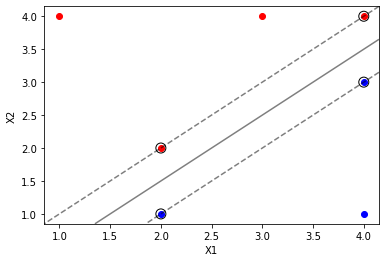

beta_0: 0.9997070312500025
beta_1: -1.9994140625000014
beta_2: 1.9994140625000014


In [10]:
# Given data
X = np.array([[3,4],[2,2],[4,4],[1,4],[2,1],[4,3],[4,1]])
Y = ['red', 'red', 'red', 'red', 'blue', 'blue', 'blue']

# Convert string labels to integers
labels = [1 if y == 'red' else -1 for y in Y]

# Create SVM classifier
clf = svm.SVC(kernel='linear', C=1e5)
clf.fit(X, labels)

# Plot data points
for i, label in enumerate(Y):
    plt.scatter(X[i,0], X[i,1], c=label)

# Plot the decision boundary
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# Plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

# Highlight the support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100, facecolors='none', edgecolors='k')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

beta_0 = clf.intercept_[0]
beta_1, beta_2 = clf.coef_[0]

print(f"beta_0: {beta_0}")
print(f"beta_1: {beta_1}")
print(f"beta_2: {beta_2}")